In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *
from fastai.vision import *
import fastai.distributed
from pathlib import Path
import pdb
import re
import seaborn as sns
from IPython.display import SVG, display
from wand.image import Image as WImage
import wand
import os
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]=""

In [3]:
# enter your path here
path = Path("../google-fonts-data")

In [4]:
svgDF = pickle.load(Path("svgdf.pkl").open("rb"))

In [5]:
def render_path(path,bbox_x,bbox_y):
    bbox_x,bbox_y = int(bbox_x),int(bbox_y)
    st = f'<svg viewBox="0 0 {bbox_x} {bbox_y}" xmlns="http://www.w3.org/2000/svg"><path d="{path}"/></svg>'
#     img = WImage(blob=str.encode(st),format="svg",width=128,height=128)
    return st

In [6]:
def render_path_wand(path,bbox_x,bbox_y):
    bbox_x,bbox_y = int(bbox_x),int(bbox_y)
    st = f'<svg viewBox="0 0 {bbox_x} {bbox_y}" xmlns="http://www.w3.org/2000/svg"><path d="{path}"/></svg>'
    img = WImage(blob=str.encode(st),format="svg",width=64,height=64)
    return img

In [7]:
def wand_to_tensor(wimage):
    wimage.depth = 8
    wimage.background_color = wand.color.Color("white")
    wimage.alpha_channel = "remove"
    blob = wimage.make_blob(format="RGB")
    pixels = []
    for cursor in range(0,64*64*3,3):
        pixels.append((blob[cursor],
                       blob[cursor + 1],
                       blob[cursor + 2]))
    return torch.tensor(pixels).view(64,64,3).float().permute(2,0,1)[0] / 255.0

In [8]:
tool_dict = {"P": [], "M": ["x","y"], "m": ["x","y"], "L": ["x","y"], "l": ["x","y"], "H": ["x"], "h": ["x"], 
             "V": ["y"], "v": ["y"], "C": ["x","y","x","y","x","y"], "c": ["x","y","x","y","x","y"], "S": ["x","y","x","y"], 
             "s": ["x","y","x","y"], "Q": ["x","y","x","y"], "q": ["x","y","x","y"], "T": ["x","y"], "t": ["x","y"],
             "A": ["x","y","","","","x","y"], "a": ["x","y","","","","x","y"], "Z": [], "z": [], "START": [], "END": [], "PAD": []}


class TokenizeSVGProcessor(PreProcessor):
    
    def tokenize(self,path,box_x,box_y,xform,label):
        out = []
        for match in re.findall("([MmLlHhVvCcSsQqTtAaZz])([0-9\.\-\s]*)",path):
            token, pen = match
            td = tool_dict[token]
            xs = []
            for coord,x in zip(td,re.findall("((\-{0,1}\.[0-9]+)|(\-{0,1}[0-9]+\.{0,1}[0-9]*))\s*",pen)):
                x = x[0]
                if coord == "x" and token.isupper():
                    xs.append((float(x) + (box_y - box_x) / 2.0)/float(box_y))
                elif coord == "x":
                    xs.append(float(x)/float(box_y))
                elif coord == "y" and token.isupper():
                    value = (float(xform)-float(x))/float(box_y)
                    xs.append(value)
                elif coord == "y" and xform > 0:
                    value = -float(x)/float(box_y)
                    xs.append(value)
                else:
                    xs.append(float(x))
            assert len(td) == 0 or (len(xs) % len(td) == 0)
            if len(td) == 0:
                out.append((token,[-2.0]*4))
            else:
                for i in range(0,len(xs),len(td)):
                    s = xs[i:i+len(td)]
                    if token == "h":
                        s = [s[0], 0]
                        token = "l"
                    elif token == "v":
                        s = [0, s[0]]
                        token = "l"
                    if len(s) < 4: s += [-2.0] * (4-len(s))
                    out.append((token,s))
        return out,label
    
    def process(self, ds):
        ds.items = array([self.process_one(item) for item in ds.items])

    def process_one(self, item):
        return self.tokenize(*item)
    
class NumericalizeSVGProcessor(PreProcessor):
    def process_one(self,item):
        item,label = item
        return [(self.stoi["START"],[-2.0]*4)
               ] + [(self.stoi[t],n) for t,n in item] + [(self.stoi["END"],[-2.0]*4)],label
            
    def process(self,ds):
        if not hasattr(self,"vocab"):
            vocab = ["PAD"] + list("Mqlthzv") + ["START","END"]
            stoi = {s:i for i,s in enumerate(vocab)}
            self.vocab = ds.vocab = vocab
            self.stoi = ds.stoi = stoi
        super().process(ds)

In [9]:
class SVGList(ItemList):
    _processor = [TokenizeSVGProcessor,NumericalizeSVGProcessor]
    
    def get(self, i):
        item = self.items[i]
        item,label = item
        return [t[0] for t in item], np.stack([t[1] for t in item]), label

In [10]:
def npad_collate(samples:BatchSamples, pad_idx:int=0) -> Tuple[LongTensor, LongTensor]:
    samples = to_data(samples)
    max_len = max([len(s[1][0]) for s in samples])
    res_tokens = torch.zeros(len(samples), max_len).long() + pad_idx
    res_numbers = torch.zeros(len(samples),max_len, 4) - 2.0
    for i,s in enumerate(samples):
        res_tokens[i,:len(s[1][0])] = LongTensor(s[1][0])
        res_numbers[i,:len(s[1][0])] = FloatTensor(s[1][1])
    return torch.stack([s[0] for s in samples]), (res_tokens,res_numbers,torch.tensor([s[1][2] for s in samples]))

In [11]:
dataAE = (ImageList.from_df(svgDF,path="",cols="png",convert_mode="L")
          .split_none()
          .label_from_df(cols=["label"],label_cls=CategoryList)
          .transform(size=64)
          .databunch(bs=256))

In [12]:
bs = 64
svgDF["label_codes"] = svgDF.label.apply(lambda x: dataAE.train_ds.y.c2i[x])
data = (ImageList.from_df(svgDF,path="",cols="png",convert_mode="L")
        .filter_by_rand(0.01,seed=3442)
        .split_none()
        .label_from_df(cols=["path","box_x","box_y","xform","label_codes"],label_cls=SVGList)
        .transform(size=64)
        .databunch(bs=bs,collate_fn=npad_collate))

In [13]:
class UpBlock(nn.Module):
    def __init__(self, up_in_c:int,final_div:bool=True, blur:bool=False, leaky:float=None,self_attention:bool=False, **kwargs):
        super().__init__()
        self.shuf = PixelShuffle_ICNR(up_in_c, up_in_c//2, blur=blur, leaky=leaky, **kwargs)
        ni = up_in_c//2
        nf = ni if final_div else ni//2
        self.conv1 = conv_layer(ni, nf, leaky=leaky, **kwargs)
        self.conv2 = conv_layer(nf, nf, leaky=leaky, self_attention=self_attention, **kwargs)
        self.relu = relu(leaky=leaky)

    def forward(self, up_in:Tensor) -> Tensor:
        up_out = self.shuf(up_in)
        return self.conv2(self.conv1(up_out))
    
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb = nn.Embedding(62,16)
        self.encoder = nn.Sequential(
            conv2d(1,32,5,1,2),
            nn.InstanceNorm2d(32,affine=True),
            nn.ReLU(),
            conv2d(32,32,5,2,2),
            nn.InstanceNorm2d(32,affine=True),
            nn.ReLU(),
            conv2d(32,64,5,1,2),
            nn.InstanceNorm2d(64,affine=True),
            nn.ReLU(),
            conv2d(64,64,5,2,2),
            nn.InstanceNorm2d(64,affine=True),
            nn.ReLU(),
            conv2d(64,64,3,2,1),
            nn.InstanceNorm2d(64,affine=True),
            nn.ReLU(),
            conv2d(64,64,3,2,1),
            nn.InstanceNorm2d(64,affine=True),
            nn.ReLU())
        
        self.z_mean = nn.Linear(64*16,32)
        self.z_logvar = nn.Linear(64*16,32)
        
        self.z_to_dec = nn.Linear(32+16,128*16)
        
        nf = [128,64,32,16]
        #nf = [2048,1024,512,256,128]
        self.decoder = nn.Sequential(*[UpBlock(f, blur=(False if f != 32 else False)) for f in nf])
        self.final_conv = conv_layer(8, 1, ks=1, use_activ=False)
        
    def get_z(self,x,char_class,stoc=True):
        u = self.encoder(x)
        u = u.view(x.shape[0],-1)
        mean, logvar = self.z_mean(u), self.z_logvar(u)
        
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = mean
        if stoc:
            z = z + eps*std
            
        z = torch.cat([z,self.emb(char_class)],dim=1)
        return z
    
    def forward(self,x,char_class):
        u = self.encoder(x)
        u = u.view(x.shape[0],-1)
        mean, logvar = self.z_mean(u), self.z_logvar(u)
        
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = mean
        #if self.training:
        z = z + eps*std
            
        z = torch.cat([z,self.emb(char_class)],dim=1)
        ls = z
        
        z = self.z_to_dec(z)
        z = z.view(x.shape[0],128,4,4)
        
        return torch.sigmoid(self.final_conv(self.decoder(z))), mean, logvar, ls
        
class VAELoss(nn.Module):
    def forward(self, preds, target):
        rec, mean, logvar,_ = preds
        KLD = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
        self.kld = KLD / (rec.shape[0] * 64 * 64)
        self.bce = F.binary_cross_entropy(rec.view(rec.shape[0],-1),target.view(target.shape[0],-1))
        return self.bce + self.kld

class VAETrainer(LearnerCallback):
    _order=-20
    def on_train_begin(self,**kwargs):
        self.smoothBCE, self.smoothKLD = SmoothenValue(0.98), SmoothenValue(0.98)
        self.learn.recorder.add_metric_names(["bce","kld"])
        
    def on_batch_begin(self, last_input, last_target, **kwargs):
        return {"last_input": (last_input,last_target), "last_target": last_input}
    
    def on_batch_end(self,**kwargs):
        self.smoothBCE.add_value(self.learn.loss_func.bce.item())
        self.smoothKLD.add_value(self.learn.loss_func.kld.item())
        
    def on_epoch_end(self, last_metrics, **kwargs):
        return add_metrics(last_metrics,[self.smoothBCE.smooth,self.smoothKLD.smooth])

In [14]:
learnAE = Learner(dataAE,VAE(),loss_func=VAELoss(),callback_fns=[VAETrainer])

In [15]:
learnAE.load("ae");

/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type VAELoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type VAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type UpBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [16]:
def dropout_mask(x:Tensor, sz:Collection[int], p:float):
    "Return a dropout mask of the same type as `x`, size `sz`, with probability `p` to cancel an element."
    return x.new(*sz).bernoulli_(1-p).div_(1-p)

class RNNDropout(nn.Module):
    "Dropout with probability `p` that is consistent on the seq_len dimension."

    def __init__(self, p:float=0.5):
        super().__init__()
        self.p=p

    def forward(self, x:Tensor)->Tensor:
        if not self.training or self.p == 0.: return x
        m = dropout_mask(x.data, (x.size(0), 1, x.size(2)), self.p)
        return x * m

class WeightDropout(nn.Module):
    "A module that warps another layer in which some weights will be replaced by 0 during training."

    def __init__(self, module:nn.Module, weight_p:float, layer_names:Collection[str]=['weight_hh_l0']):
        super().__init__()
        self.module,self.weight_p,self.layer_names = module,weight_p,layer_names
        for layer in self.layer_names:
            #Makes a copy of the weights of the selected layers.
            w = getattr(self.module, layer)
            self.register_parameter(f'{layer}_raw', nn.Parameter(w.data))
            self.module._parameters[layer] = F.dropout(w, p=self.weight_p, training=False)

    def _setweights(self):
        "Apply dropout to the raw weights."
        for layer in self.layer_names:
            raw_w = getattr(self, f'{layer}_raw')
            self.module._parameters[layer] = F.dropout(raw_w, p=self.weight_p, training=self.training)

    def forward(self, *args:ArgStar):
        self._setweights()
        with warnings.catch_warnings():
            #To avoid the warning that comes because the weights aren't flattened.
            warnings.simplefilter("ignore")
            return self.module.forward(*args)

    def reset(self):
        for layer in self.layer_names:
            raw_w = getattr(self, f'{layer}_raw')
            self.module._parameters[layer] = F.dropout(raw_w, p=self.weight_p, training=False)
        if hasattr(self.module, 'reset'): self.module.reset()

class EmbeddingDropout(nn.Module):
    "Apply dropout with probabily `embed_p` to an embedding layer `emb`."

    def __init__(self, emb:nn.Module, embed_p:float):
        super().__init__()
        self.emb,self.embed_p = emb,embed_p
        self.pad_idx = self.emb.padding_idx
        if self.pad_idx is None: self.pad_idx = -1

    def forward(self, words:LongTensor, scale:Optional[float]=None)->Tensor:
        if self.training and self.embed_p != 0:
            size = (self.emb.weight.size(0),1)
            mask = dropout_mask(self.emb.weight.data, size, self.embed_p)
            masked_embed = self.emb.weight * mask
        else: masked_embed = self.emb.weight
        if scale: masked_embed.mul_(scale)
        return F.embedding(words, masked_embed, self.pad_idx, self.emb.max_norm,
                           self.emb.norm_type, self.emb.scale_grad_by_freq, self.emb.sparse)

class AWD_LSTM(nn.Module):
    "AWD-LSTM/QRNN inspired by https://arxiv.org/abs/1708.02182."

    initrange=0.1

    def __init__(self, vocab_sz:int, emb_sz:int, n_hid:int, n_layers:int, pad_token:int=1, hidden_p:float=0.3,
                 input_p:float=0.6, embed_p:float=0.1, weight_p:float=0.5, bidir:bool=False):
        super().__init__()
        self.bs,self.emb_sz,self.n_hid,self.n_layers = 1,emb_sz,n_hid,n_layers
        self.n_dir = 2 if bidir else 1
        self.encoder = nn.Embedding(vocab_sz, emb_sz, padding_idx=pad_token)
        self.encoder_dp = EmbeddingDropout(self.encoder, embed_p)
       
        self.rnns = [nn.LSTM(emb_sz if l == 0 else n_hid, n_hid, 1,
                             batch_first=True, bidirectional=bidir) for l in range(n_layers)]
        self.rnns = [WeightDropout(rnn, weight_p) for rnn in self.rnns]
        self.rnns = nn.ModuleList(self.rnns)
        self.encoder.weight.data.uniform_(-self.initrange, self.initrange)
        self.input_dp = RNNDropout(input_p)
        self.hidden_dps = nn.ModuleList([RNNDropout(hidden_p) for l in range(n_layers)])

    def forward(self, input:Tensor, hs, from_embeddings:bool=False)->Tuple[Tensor,Tensor]:
        if from_embeddings: bs,sl,es = input.size()
        else: bs,sl = input.size()
        if bs!=self.bs:
            self.bs=bs
            self.reset()
        raw_output = self.input_dp(input if from_embeddings else self.encoder_dp(input))
        new_hidden,raw_outputs,outputs = [],[],[]
        for l, (rnn,hid_dp) in enumerate(zip(self.rnns, self.hidden_dps)):
            raw_output, new_h = rnn(raw_output, (hs[0][[l]],hs[1][[l]]))
            new_hidden.append(new_h)
            raw_outputs.append(raw_output)
            if l != self.n_layers - 1: raw_output = hid_dp(raw_output)
            outputs.append(raw_output)
        #self.hidden = to_detach(new_hidden, cpu=False)
        return outputs[-1], (torch.cat([x[0] for x in new_hidden]),torch.cat([x[1] for x in new_hidden]))

    def _one_hidden(self, l:int)->Tensor:
        "Return one hidden state."
        nh = (self.n_hid if l != self.n_layers - 1 else self.emb_sz) // self.n_dir
        return one_param(self).new(self.n_dir, self.bs, nh).zero_()

    def select_hidden(self, idxs):
        self.hidden = [(h[0][:,idxs,:],h[1][:,idxs,:]) for h in self.hidden]
        self.bs = len(idxs)

    def reset(self):
        "Reset the hidden states."
        [r.reset() for r in self.rnns if hasattr(r, 'reset')]
        self.hidden = [(self._one_hidden(l), self._one_hidden(l)) for l in range(self.n_layers)]

In [17]:
ONEOVERSQRT2PI = 1.0 / math.sqrt(2*math.pi)

class MDN(nn.Module):
    """A mixture density network layer
    The input maps to the parameters of a MoG probability distribution, where
    each Gaussian has O dimensions and diagonal covariance.
    Arguments:
        in_features (int): the number of dimensions in the input
        out_features (int): the number of dimensions in the output
        num_gaussians (int): the number of Gaussians per output dimensions
    Input:
        minibatch (BxD): B is the batch size and D is the number of input
            dimensions.
    Output:
        (pi, sigma, mu) (BxG, BxGxO, BxGxO): B is the batch size, G is the
            number of Gaussians, and O is the number of dimensions for each
            Gaussian. Pi is a multinomial distribution of the Gaussians. Sigma
            is the standard deviation of each Gaussian. Mu is the mean of each
            Gaussian.
    """
    def __init__(self, in_features, out_features, num_gaussians, use_sigmoid=False, scale=1.0):
        super(MDN, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.num_gaussians = num_gaussians
        self.pi = nn.Sequential(nn.Linear(in_features,512),nn.ReLU(inplace=True),nn.Linear(512, out_features*num_gaussians))

        self.sigma = nn.Sequential(nn.Linear(in_features,512),nn.ReLU(inplace=True),nn.Linear(512, out_features*num_gaussians))
        self.mu = nn.Sequential(nn.Linear(in_features,512),nn.ReLU(inplace=True),nn.Linear(512, out_features*num_gaussians))
        self.use_sigmoid = use_sigmoid
        self.scale = scale

    def forward(self, minibatch):
        pi = self.pi(minibatch).view(minibatch.shape[0],minibatch.shape[1],self.out_features,self.num_gaussians)
        pi = torch.softmax(pi,dim=3)
        sigma = self.sigma(minibatch)
        if self.use_sigmoid:
            sigma = 0.1*torch.sigmoid(sigma) + 1e-5
        else:
            sigma = torch.exp(sigma) + 1e-5
        sigma = sigma.view(minibatch.shape[0], minibatch.shape[1], self.out_features,self.num_gaussians)
        mu = self.scale * torch.tanh(self.mu(minibatch))
        mu = mu.view(minibatch.shape[0],minibatch.shape[1], self.out_features, self.num_gaussians)
        return pi, sigma, mu

def mdn_loss(pi, sigma, mu, target):
    """Calculates the error, given the MoG parameters and the target
    The loss is the negative log likelihood of the data given the MoG
    parameters.
    """
    ntarget = target.unsqueeze(-1)
    m = torch.distributions.Normal(loc=mu, scale=sigma)
    loss = torch.exp(m.log_prob(ntarget))
    #loss = torch.softmax(m.log_prob(ntarget),dim=2)
    loss = torch.sum(loss * pi, dim=3)
    #print((loss > 1).sum())
    loss = -torch.log(loss+1e-8)
    loss = loss[target != -2.0]
    return loss.mean()

In [18]:
def sample(pi, sigma, mu):
    """Draw samples from a MoG.
    """
    dist = torch.distributions.Categorical(pi)
    s = dist.sample().cuda()
    mu = torch.gather(mu,3,s.unsqueeze(-1)).squeeze(-1)
    sigma = torch.gather(sigma,3,s.unsqueeze(-1)).squeeze(-1)
    dist_n = torch.distributions.Normal(mu,sigma)
    return dist_n.sample().cuda()

In [22]:
class SVGDecoder(nn.Module):
    def __init__(self,num_tokens,vae_sd):
        super().__init__()
        self.vae = VAE()
        self.vae.load_state_dict(vae_sd)
        requires_grad(self.vae,False)
        self.token_emb = nn.Embedding(num_tokens,4)
        #self.rnn = nn.GRU(4+4+32+16,1024,4,batch_first=True,dropout=0.3)
        #self.rnn = nn.LSTM(4+4+32+16,1024,4,batch_first=True,dropout=0.3)
        self.rnn = AWD_LSTM(62,4+4+32+16,1024,4,0,input_p=0.0)
        self.z_to_hidden = nn.Linear(32+16,1024)
        self.token = nn.Linear(1024,num_tokens)
#         #self.pen = nn.Linear(1024,4)
        self.pen = MDN(1024,4,512,use_sigmoid=True)
        self.mask = torch.tensor([[0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0]]).cuda()
        
    def get_preds(self, png, char_class, use_mean=False):
        #z (bsx48)
        z = self.vae.get_z(png,char_class).detach()
        hs = self.z_to_hidden(z).unsqueeze(0).expand(4,-1,-1).contiguous()
        cs = torch.zeros_like(hs)
        tools = [torch.zeros(z.shape[0],1,dtype=torch.long).fill_(8).cuda()]
        pens = [torch.zeros(z.shape[0],1,4).fill_(-2.0).cuda()]
        i = 0
        while i < 200:
            r_in = torch.cat([self.token_emb(tools[-1]),pens[-1],z.unsqueeze(1)],dim=2)
            output, (hs,cs) = self.rnn(r_in,(hs,cs),from_embeddings=True)
            tool = self.token(output)
            u = tool[tools[-1].squeeze() == 6]
            tool[tools[-1].squeeze() == 6] = torch.where(self.mask.unsqueeze(0).expand_as(u)==1.0,u,torch.zeros_like(u).fill_(-1e9))
            if use_mean:
                pi,_,pen = self.pen(output)
                pi = torch.argmax(pi,dim=3,keepdim=True)
                pen = torch.gather(pen,3,pi).squeeze(-1)
            else:            
                pen = self.pen(output)
                pen = sample(*pen)
            tools.append(torch.argmax(tool,dim=2))
            pens.append(pen)
            i += 1
            
        return torch.cat(tools,dim=1), torch.cat(pens,dim=1)

    def get_preds_mean(self, png, char_class):
        #z (bsx48)
        z = self.vae.get_z(png,char_class,False).detach()
        hs = self.z_to_hidden(z).unsqueeze(0).expand(4,-1,-1).contiguous()
        cs = torch.zeros_like(hs)
        tools = [torch.zeros(z.shape[0],1,dtype=torch.long).fill_(8).cuda()]
        pens = [torch.zeros(z.shape[0],1,4).fill_(-2.0).cuda()]
        i = 0
        while i < 200:
            r_in = torch.cat([self.token_emb(tools[-1]),pens[-1],z.unsqueeze(1)],dim=2)
            output, (hs,cs) = self.rnn(r_in,(hs,cs),from_embeddings=True)
            tool = self.token(output)
            u = tool[tools[-1].squeeze() == 6]
            tool[tools[-1].squeeze() == 6] = torch.where(self.mask.unsqueeze(0).expand_as(u)==1.0,u,torch.zeros_like(u).fill_(-1e9))
            pi,_,pen = self.pen(output)
            pi = torch.argmax(pi,dim=3,keepdim=True)
            pen = torch.gather(pen,3,pi).squeeze(-1)
            tools.append(torch.argmax(tool,dim=2))
            pens.append(pen)
            i += 1
        return torch.cat(tools,dim=1), torch.cat(pens,dim=1)
    
    def get_preds_from_output(self,tokens,pi,sigma,mu):
        tokens = torch.argmax(tokens,dim=2)
        pi = torch.argmax(pi,dim=3,keepdim=True)
        mu = torch.gather(mu,3,pi).squeeze(-1)
        return tokens,mu
    
    def forward(self, png, char_class,tokens, pen, return_preds=True):
        z = self.vae.get_z(png,char_class).detach()
        tokens = self.token_emb(tokens)
        hs = self.z_to_hidden(z).unsqueeze(0).expand(4,-1,-1).contiguous()
        r_in = torch.cat([tokens,pen,z.unsqueeze(1).expand(-1,tokens.shape[1],-1)],dim=2)
        #self.rnn.flatten_parameters()
        output, (hs,cs) = self.rnn(r_in,(hs,torch.zeros_like(hs)),from_embeddings=True)
        
        tokens = self.token(output)
        #pens = self.pen(output)
        #return tokens, pens
        pi,sigma,mu = self.pen(output)
        
        return tokens, (pi[:,:-1],sigma[:,:-1], mu[:,:-1]), self.get_preds_from_output(tokens,pi,sigma,mu), output
        #return tokens, (pi[:,:-1],sigma[:,:-1], mu[:,:-1]), output

In [23]:
class SVGDecoderLoss(nn.Module):
    def forward(self,preds,target_tokens,target_pen):
        tokens, pen, mpreds = preds
        mask = target_tokens != 0
        loss_token = 10.0*F.cross_entropy(tokens.transpose(1,2)[:,:,:-1],target_tokens,reduction="none")[mask].mean()
        #loss_token = 10*F.cross_entropy(tokens.transpose(1,2)[:,:,:-1],target_tokens)
        loss_pen = mdn_loss(*pen,target_pen)
        self.l_t = loss_token.item()
        self.l_p = loss_pen.item()
        with torch.no_grad():
            self.l_mse = F.mse_loss(mpreds[1][:,:-1],target_pen,reduction="none")[target_pen != -2.0].mean().item()
        #self.l_mse = 0.0
        return loss_token + loss_pen

class SVGDecoderTrainer(LearnerCallback):
    _order=-20
    def on_train_begin(self,**kwargs):
        self.smoothCE, self.smoothMDN, self.smoothMSE, self.smoothMu, self.smoothSigma = SmoothenValue(0.98), SmoothenValue(0.98), SmoothenValue(0.98), SmoothenValue(0.98), SmoothenValue(0.98)
        self.learn.recorder.add_metric_names(["ce","mdn", "mse", "mu", "sigma"])
        
    def on_batch_begin(self, last_input, last_target, **kwargs):
        self.last_target = last_target
        return {"last_input": (last_input,last_target[2],last_target[0],last_target[1]), "last_target": (last_target[0][:,1:],last_target[1][:,1:])}
    
    def on_loss_begin(self, last_output, **kwargs):
        self.smoothMu.add_value(last_output[1][2][self.last_target[1][:,1:].unsqueeze(-1).expand(-1,-1,-1,512)!=-2.0].abs().mean().item())
        self.smoothSigma.add_value(last_output[1][1][self.last_target[1][:,1:].unsqueeze(-1).expand(-1,-1,-1,512)!=-2.0].mean().item())
        self.out = last_output[3]
        return {"last_output": last_output[:3]}
    
    def on_backward_begin(self,last_loss, **kwargs):
        last_loss += 2.0 * self.out.float().pow(2).mean()
        return {"last_loss": last_loss}
       
    def on_batch_end(self,**kwargs):
        self.smoothCE.add_value(self.learn.loss_func.l_t)
        self.smoothMDN.add_value(self.learn.loss_func.l_p)
        self.smoothMSE.add_value(self.learn.loss_func.l_mse)
        
    def on_epoch_end(self, epoch, last_metrics, **kwargs):
        #self.learn.save("svg_awd_full")
        return add_metrics(last_metrics,[self.smoothCE.smooth,self.smoothMDN.smooth,self.smoothMSE.smooth,self.smoothMu.smooth,self.smoothSigma.smooth])

In [24]:
learnSVG = Learner(data,SVGDecoder(len(data.vocab),learnAE.model.state_dict()),loss_func=SVGDecoderLoss(),callback_fns=[SVGDecoderTrainer])

In [25]:
learnSVG.load("svg_awd");

/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type RNNDropout. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type SVGDecoderLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type SVGDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type VAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/op

In [26]:
def get_pred_path(x,labels,mean=False,i=0):
    learnSVG.model.eval()
    with torch.no_grad():
        if mean:
            tools, pens = learnSVG.model.get_preds_mean(x,labels)
        else:
            tools, pens = learnSVG.model.get_preds(x,labels)
    out = []
    for t,p in zip(tools[i,1:-1],pens[i,1:-1]):
        t = data.vocab[t]
        out.append(t)
        out.append(" ".join([str(int(np.rint(500*n.item()))) for n in p[:len(tool_dict[t])]]))
    return " ".join(out)

In [27]:
def path_from_tensors(tools,pens,i=0):
    p = ""
    for t,pen in zip(tools[i,1:],pens[i,1:]):
        tool = data.vocab[t]
        if tool == "END": break
        pen = [str(int(np.rint(x.item()))) for x in pen*500]
        p = p + tool + " " + " ".join(pen[:len(tool_dict[tool])]) + " "
    return p

In [28]:
class Agent(nn.Module):
    def __init__(self,num_tools,encoder_sd=None,tool_emb_sd=None):
        super().__init__()
        self.cnn = nn.Sequential(
            conv2d(1,32,5,1,2),
            nn.InstanceNorm2d(32,affine=True),
            nn.ReLU(),
            conv2d(32,32,5,2,2),
            nn.InstanceNorm2d(32,affine=True),
            nn.ReLU(),
            conv2d(32,64,5,1,2),
            nn.InstanceNorm2d(64,affine=True),
            nn.ReLU(),
            conv2d(64,64,5,2,2),
            nn.InstanceNorm2d(64,affine=True),
            nn.ReLU(),
            conv2d(64,64,3,2,1),
            nn.InstanceNorm2d(64,affine=True),
            nn.ReLU(),
            conv2d(64,64,3,2,1),
            nn.InstanceNorm2d(64,affine=True),
            nn.ReLU())
        
        if encoder_sd is not None: self.cnn.load_state_dict(encoder_sd)
        self.cnn = self.cnn[:-2]
        #requires_grad(self.cnn,False)
        
        self.flatten = nn.Sequential(AdaptiveConcatPool2d(1),Flatten())
        self.tool_emb = nn.Embedding(num_tools,4)
        if tool_emb_sd is not None: self.tool_emb.load_state_dict(tool_emb_sd)
        requires_grad(self.tool_emb,False)
        self.sv_to_hs = nn.Linear(128,1024)
        #self.path_encoder = nn.LSTM(128+4+4,1024,2,batch_first=True)
        self.path_encoder = AWD_LSTM(62,128+128+4+4,1024,3,0,input_p=0.0)
        self.tool_sel = nn.Linear(1024,1)
        self.num_tools = num_tools
        self.adjust_mean = nn.Sequential(nn.Linear(1024,512),nn.ReLU(inplace=True),nn.Linear(512,num_tools*4))
        self.adjust_std = nn.Sequential(nn.Linear(1024,512),nn.ReLU(inplace=True),nn.Linear(512,num_tools*4))
        #self.adjust = MDN(1024,4,64,scale=0.03,use_sigmoid=True)
        self.template = torch.arange(0,201).unsqueeze(0).expand(64,-1).cuda()
        
        
    def get_log_probs(self, state, target, tools, pens, pens_comp, action, npen, real_pens, seq_mask=None):
        sv = self.flatten(self.cnn(state))
        tv = self.flatten(self.cnn(target))
        u = torch.cat([tv.unsqueeze(1).expand(-1,tools.shape[1],-1),sv.unsqueeze(1).expand(-1,tools.shape[1],-1),self.tool_emb(tools),pens],dim=2)
        hs = self.sv_to_hs(tv).unsqueeze(0).expand(3,-1,-1).contiguous()
        output,_ = self.path_encoder(u,(hs,torch.zeros_like(hs)),from_embeddings=True)
        
        actions = torch.softmax(self.tool_sel(output).squeeze(-1),dim=1)
        mean = 0.025*torch.tanh(self.adjust_mean(output).view(tools.shape[0],-1,self.num_tools,4))
        std = 0.02*torch.sigmoid(self.adjust_std(output).view(tools.shape[0],-1,self.num_tools,4))
        mask = (tools != 0) & (tools != 8) & (tools != 9) & (tools != 6)
        first_end = torch.argmax(tools==9,dim=1,keepdim=True)
        self.template = torch.arange(0,tools.shape[1]).unsqueeze(0).expand(tools.shape[0],-1).cuda()
        mask = mask & (self.template < first_end)
        if seq_mask is not None: mask = mask & seq_mask
        actions = torch.where(mask,actions,torch.zeros_like(actions))
        actions = actions / actions.sum(dim=1,keepdim=True)

        dist_action = torch.distributions.Categorical(actions)
        action_log_probs = dist_action.log_prob(action)
        t = tools[torch.arange(tools.shape[0]),action]
        delta = torch.zeros_like(pens)
        mean,std = [p[torch.arange(p.shape[0]),action,t] for p in [mean,std]]

        normals_dist = torch.distributions.Normal(mean,std)
        pen_log_probs = normals_dist.log_prob(npen)
               
        pens_comp = pens_comp[torch.arange(pens_comp.shape[0]),action]
        
        real_diff = real_pens - pens_comp
        real_log_probs = normals_dist.log_prob(real_diff)
        
        return action_log_probs, pen_log_probs, real_log_probs
               
        
    def forward(self, state, target, tools, pens, explore=True, seq_mask=None, sigma_mult=1.0):
        sv = self.flatten(self.cnn(state))
        tv = self.flatten(self.cnn(target))
        u = torch.cat([tv.unsqueeze(1).expand(-1,tools.shape[1],-1),sv.unsqueeze(1).expand(-1,tools.shape[1],-1),self.tool_emb(tools),pens],dim=2)
        hs = self.sv_to_hs(tv).unsqueeze(0).expand(3,-1,-1).contiguous()
        output,_ = self.path_encoder(u,(hs,torch.zeros_like(hs)),from_embeddings=True)
        
        actions = torch.softmax(self.tool_sel(output).squeeze(-1),dim=1)
        mean = 0.025*torch.tanh(self.adjust_mean(output).view(tools.shape[0],-1,self.num_tools,4))
        std = 0.02*torch.sigmoid(self.adjust_std(output).view(tools.shape[0],-1,self.num_tools,4))
        mask = (tools != 0) & (tools != 8) & (tools != 9) & (tools != 6)
        first_end = torch.argmax(tools==9,dim=1,keepdim=True)
        self.template = torch.arange(0,tools.shape[1]).unsqueeze(0).expand(64,-1).cuda()
        mask = mask & (self.template < first_end)
        if seq_mask is not None: mask = mask & seq_mask
        actions = torch.where(mask,actions,torch.zeros_like(actions))
        actions = actions / actions.sum(dim=1,keepdim=True)

        if torch.isnan(actions).sum() > 0:
            return
        #action_probs,action = torch.max(actions,dim=1)
        dist_action = torch.distributions.Categorical(actions)
        action = dist_action.sample()
        action_log_probs = dist_action.log_prob(action)
        action_entropy = dist_action.entropy()
        #action = torch.zeros_like(action).fill_(2)
        #print(action)
        #print(tools.shape,action.shape,action.max())
        t = tools[torch.arange(tools.shape[0]),action]
        #mean = mean[torch.arange(mean.shape[0]),action,t]
        #std = std[torch.arange(std.shape[0]),action,t]
        delta = torch.zeros_like(pens)
        mean,std = [p[torch.arange(p.shape[0]),action,t] for p in [mean,std]]
               
        if explore:
            #std = torch.where(torch.rand_like(std) < 0.35,std,torch.zeros_like(std).fill_(0.015))
            dist = torch.distributions.Normal(mean,std)
            d = dist.sample()
            delta[torch.arange(tools.shape[0]),action] = d
            #print(f"am: {adjust[1].min()}")
            l = dist.log_prob(d)
            if torch.isnan(l).sum() > 0:
                print("nan loss")
            return torch.clamp((pens + delta),-1.0,1.0), d, action_log_probs, l, action, action_entropy, dist.entropy(), mean, std
        else:
            d = torch.gather(adjust[2],2,torch.argmax(adjust[0],dim=2,keepdim=True)).squeeze(-1)
            delta[torch.arange(tools.shape[0]),action] = d
            return torch.clamp((pens + delta),-1.0,1.0), action

In [29]:
class Critic(nn.Module):
    def __init__(self,num_tools,encoder_sd=None,tool_emb_sd=None):
        super().__init__()
#         self.cnn = nn.Sequential(
#             conv2d(1,32,5,1,2),
#             nn.InstanceNorm2d(32,affine=True),
#             nn.Dropout(0.2),
#             nn.ReLU(),
#             conv2d(32,64,5,2,2),
#             nn.InstanceNorm2d(64,affine=True),
#             nn.Dropout(0.2),
#             nn.ReLU(),
#             conv2d(64,128,5,1,2),
#             nn.InstanceNorm2d(128,affine=True),
#             nn.Dropout(0.2),
#             nn.ReLU(),
#             conv2d(128,256,5,2,2),
#             nn.InstanceNorm2d(256,affine=True),
#             nn.Dropout(0.2),
#             nn.ReLU(),
#             conv2d(256,512,3,2,1))

        self.cnn = create_body(models.resnet34,pretrained=False)
        if encoder_sd is not None: self.cnn.load_state_dict(encoder_sd)
 
        self.flatten = nn.Sequential(AdaptiveConcatPool2d(1),Flatten())
        self.out = nn.Sequential(nn.Linear(512*2*2,256),nn.ReLU(inplace=True),nn.Linear(256,1))
        
    def forward(self, state, target, tools, pens, npens):
        sv = self.flatten(self.cnn(state.expand(-1,3,-1,-1)))
        tv = self.flatten(self.cnn(target.expand(-1,3,-1,-1)))
        u = torch.cat([sv,tv],dim=1)
        u = self.out(u).squeeze(-1)
        return u
        #return torch.where(u > 0,torch.tanh(u),u)

In [30]:
learnInit = Learner(dataAE,nn.Sequential(Lambda(lambda x: x.expand(-1,3,-1,-1)),create_body(models.resnet34,pretrained=True),create_head(512*2,dataAE.c)),metrics=accuracy)

In [31]:
learnInit.model[1].load_state_dict(torch.load("init-sd"))

In [32]:
def tensors_to_path_string(tools,pens):
    paths = []
    for i in range(tools.shape[0]):
        out = []
        for t,p in zip(tools[i],pens[i]):
            t = data.vocab[t]
            out.append(t)
            out.append(" ".join([str(int(np.rint(500*n.item()))) for n in p[:len(tool_dict[t])]]))
        path = " ".join(out)
        path = path[:path.find("END")-1]
        paths.append(path)
    return paths

In [33]:
def get_pred_paths(x,labels,mean=True):
    learnSVG.model.eval()
    with torch.no_grad():
        if mean:
            tools, pens = learnSVG.model.get_preds_mean(x,labels)
        else:
            tools, pens = learnSVG.model.get_preds(x,labels)
        
    paths = tensors_to_path_string(tools[:,1:-1],pens[:,1:-1])
    return paths,tools,pens

In [34]:
def render_path(path):
    return wand_to_tensor(render_path_wand(path,500,500))

def render_paths(paths):
    return torch.stack([render_path(p) for p in paths]).unsqueeze(1).cuda()

In [47]:
x,y = next(iter(data.train_dl))
labels = y[2]
po = path_from_tensors(y[0],y[1])
po

'M 203 74 l 60 191 l 96 -191 l 76 0 l -30 326 l -56 0 l 22 -245 l -101 210 l -36 0 l -64 -218 l -24 253 l -55 0 l 30 -326 l 78 0 z  '

In [58]:
#x,y = next(iter(data.train_dl))
target_paths = [path_from_tensors(y[0],y[1],i) for i in range(x.shape[0])]
targets = render_paths(target_paths)[[0]].expand(64,-1,-1,-1)
target_pens = y[1][[0]].expand(64,-1,-1)

paths, tools, pens = get_pred_paths(x,y[2])
start_state = render_paths(paths)[[0]].expand(64,-1,-1,-1)
start_state_tools = tools[[0]].expand(64,-1)
start_state_pens = pens[[0]].expand(64,-1,-1)

# corrupted_pens = y[1] + torch.zeros_like(y[1]).normal_(0.0,0.03)
# corrupted_pens[y[1]==-2.0] = -2.0
# c_paths = [path_from_tensors(y[0],corrupted_pens,i) for i in range(x.shape[0])]
# start_state = render_paths(c_paths)[[0]].expand(64,-1,-1,-1)
# start_state_tools = y[0][[0]].expand(64,-1)
# start_state_pens = corrupted_pens[[0]].expand(64,-1,-1)

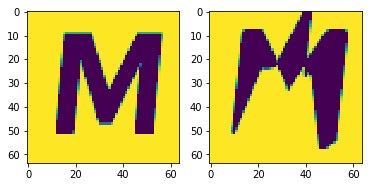

In [62]:
fig,axes = plt.subplots(1,2)
axes[0].imshow(targets[0,0])
axes[1].imshow(start_state[0,0])

In [52]:
def nparallel(func, arr:Collection, max_workers:int=None, leave=False):
    "Call `func` on every element of `arr` in parallel using `max_workers`."
    max_workers = ifnone(max_workers, defaults.cpus)
    if max_workers<2: results = [func(o,i) for i,o in progress_bar(enumerate(arr), total=len(arr), leave=leave)]
    else:
        with ThreadPoolExecutor(max_workers=max_workers) as ex:
            results = list(ex.map(func,arr))
    return results

def set_lr(opt,lr):
    for pg in opt.param_groups:
        pg["lr"] = lr

In [53]:
# feature_encoder = nn.Sequential(
#     conv2d(1,32,5,1,2),
#     nn.InstanceNorm2d(32,affine=True),
#     nn.ReLU(),
#     conv2d(32,32,5,2,2),
#     nn.InstanceNorm2d(32,affine=True),
#     nn.ReLU(),
#     conv2d(32,64,5,1,2),
#     nn.InstanceNorm2d(64,affine=True),
#     nn.ReLU(),
#     conv2d(64,64,5,2,2),
#     nn.InstanceNorm2d(64,affine=True),
#     nn.ReLU(),
#     conv2d(64,64,3,2,1),
#     nn.InstanceNorm2d(64,affine=True),
#     nn.ReLU(),
#     conv2d(64,64,3,2,1),
#     nn.InstanceNorm2d(64,affine=True),
#     nn.ReLU()).cuda()
# feature_encoder.load_state_dict(learnAE.model.encoder.state_dict())
# feature_encoder = feature_encoder[:-2]
# requires_grad(feature_encoder,False)

feature_encoder = nn.Sequential(Lambda(lambda x: x.expand(-1,3,-1,-1)),create_body(models.resnet34,pretrained=False)).cuda()
feature_encoder[1].load_state_dict(learnInit.model[1].state_dict())
requires_grad(feature_encoder,False)

def eval_pen(x,tool,tools,pen,target,target_features,l=2):
    pens = pen.clone()
    pens[tool,:l] += x[:l]
    paths = tensors_to_path_string(tools[1:].unsqueeze(0),pens[1:].unsqueeze(0))
    s = render_path(paths[0])
    return F.mse_loss(s,target).mean().item(), 0.0, s#F.mse_loss(feature_encoder(s[None,None]),target_features), s

def eval_pen_kernel(x,tool,tools,pen,target,target_features,l=10,ks=3):
    pens = pen.clone()
    if tool - ks//2 < 0:
        x = x[(ks//2) - tool:]
    elif tool + ks//2 >= l:
        x = x[:ks//2+(l-tool)]
    #print(pens[max(tool-ks//2,0):min(tool+ks//2+1,l)].shape,x.shape)
    pens[max(tool-ks//2,0):min(tool+ks//2+1,l)] += x
    paths = tensors_to_path_string(tools[1:].unsqueeze(0),pens[1:].unsqueeze(0))
    s = render_path(paths[0]).cuda()
    return F.mse_loss(s,target).mean().item(), F.mse_loss(feature_encoder(s[None,None]),target_features), s

def eval_pens(x,tools,pens,target):
    u = x + pens
    paths = tensors_to_path_string(tools[1:].unsqueeze(0),pens[1:].unsqueeze(0))
    s = render_path(paths[0]).cuda()
    return F.mse_loss(s,target,reduction="none").mean().item(), s

In [54]:
# target_features = feature_encoder(targets[[0]])
# pen = start_state_pens[0].clone().cpu()
# l = torch.argmax(start_state_tools[0] == 9).item()
# state = start_state[0,0].cpu()
# target = targets[0].cpu()
# state_history = [state]
# pen = pen.cpu()
# state = state.cpu()
# target = target.cpu()
# init_mse, init_mse_feature = F.mse_loss(state,target), 1.0#F.mse_loss(feature_encoder(state[None,None]),target_features)

for pass_num in range(10):
    #mse_balance = 0.5 + 0.5*min(1.0,pass_num/10)
    mse_balance = 1.0
    print(f"Pass {pass_num}")
    for i in range(1,l):
        tl = len(tool_dict[data.vocab[start_state_tools[0][i]]])
        if tl == 0: continue
        adj = torch.zeros(4)#.normal_(0.0,0.03)
        npop = 32
        base_sigma = 1 #/ np.power(3,pass_num)
        lr = 1e-3
        base_mse, base_mse_feature = F.mse_loss(state,target) , 1.0# F.mse_loss(feature_encoder(state[None,None]),target_features)
        best_mse = 0.0
        prev_skip = False
        sigma = base_sigma
        for epoch in range(10):
            if prev_skip:
                sigma = sigma * 1.2
            else:
                sigma = max(sigma / 1.2,0.005)
            N = torch.randn(npop,4)
            R = torch.zeros(npop)
            def get_reward(j):
                w_try = 0.05*torch.tanh(adj + sigma*N[j])
                b,f,_ = eval_pen(w_try,tool=i,tools=start_state_tools[0].cpu(),pen=pen,target=target,target_features=target_features,l=tl)
                b = b / base_mse
                f = f / base_mse_feature
                return 1.0 - (mse_balance*b+(1-mse_balance)*f)
#             for j in range(npop):
#                 w_try = 0.05*torch.tanh(adj + sigma*N[j])
#                 b,f,_ = eval_pen(w_try,tool=i,tools=start_state_tools[0],pen=pen,target=targets[0],target_features=target_features,l=tl)
#                 b = b / base_mse
#                 f = f / base_mse_feature
#                 R[j] = 1.0 - (mse_balance*b+(1-mse_balance)*f)
            rs = nparallel(get_reward,range(npop))
            R = torch.tensor(rs)
            A = (R - R.mean()) / (R.std() + 1e-6)
            old_adj = adj
            adj = adj + (lr/(npop*sigma))*torch.mm(N.transpose(0,1),A.unsqueeze(1)).squeeze(-1)
            b,f,_ = eval_pen(0.05*torch.tanh(adj),tool=i,tools=start_state_tools[0].cpu(),pen=pen,target=target,target_features=target_features,l=tl)
            b = b / base_mse
            f = f / base_mse_feature
            mse = 1.0 - (mse_balance*b+(1-mse_balance)*f)
            if mse <= best_mse:
                adj = old_adj
                prev_skip = True
                continue
            else:
                prev_skip = False
                best_mse = mse
            print(f"Epoch {epoch} {mse}")
        mse_b,mse_f,state = eval_pen(0.05*torch.tanh(adj),tool=i,tools=start_state_tools[0].cpu(),pen=pen,target=target,target_features=target_features,l=tl)
        mse_b = mse_b / init_mse
        mse_f = mse_f / init_mse_feature
        state_history.append(state.detach().cpu())
        pen[i] += 0.05*torch.tanh(adj)
        mse = 1.0 - (mse_balance*mse_b + (1-mse_balance)*mse_f)
        print(f"{i} {1.0 - mse_b} {1.0 - mse_f}")
        plt.imshow(state)
        plt.show()

Pass 0


NameError: name 'l' is not defined

In [55]:
target_features = feature_encoder(targets[[0]])
pen = start_state_pens[0].clone()
l = torch.argmax(start_state_tools[0] == 9).item()
state = start_state[0,0]
init_mse, init_mse_feature = F.mse_loss(state,targets[0]), F.mse_loss(feature_encoder(state[None,None]),target_features)
state_history = [state]

for pass_num in range(10):
    #mse_balance = 0.5 + 0.5*min(1.0,pass_num/10)
    mse_balance = 1.0
    print(f"Pass {pass_num}")
    for i in range(1,l):
        #tl = len(tool_dict[data.vocab[start_state_tools[0][i]]])
        #if tl == 0: continue
        ks = 3
        adj = torch.zeros(ks,4).cuda()#.normal_(0.0,0.03)
        npop = 32
        base_sigma = 0.05 #/ np.power(3,pass_num)
        lr = 1e-4
        base_mse, base_mse_feature = F.mse_loss(state,targets[0]) , F.mse_loss(feature_encoder(state[None,None]),target_features)
        best_mse = 0.0
        prev_skip = False
        sigma = base_sigma
        for epoch in range(20):
            if prev_skip:
                sigma = sigma * 1.2
            else:
                sigma = max(sigma / 1.2,0.005)
            N = torch.randn(npop,ks,4).cuda()
            R = torch.zeros(npop).cuda()
            for j in range(npop):
                w_try = adj + sigma*N[j]
                b,f,_ = eval_pen_kernel(w_try,tool=i,tools=start_state_tools[0],pen=pen,target=targets[0],target_features=target_features,l=l,ks=ks)
                b = b / base_mse
                f = f / base_mse_feature
                R[j] = 1.0 - (mse_balance*b+(1-mse_balance)*f)
            A = (R - R.mean()) / (R.std() + 1e-6)
            old_adj = adj
            N = N.view(npop,-1)
            d = (lr/(npop*sigma))*torch.mm(N.transpose(0,1),A.unsqueeze(1)).view(ks,4)
            d = torch.where(d.abs() > 0.0005,torch.where(d<0,torch.clamp_max(d,-0.002),torch.clamp_min(d,0.002)),d)
            adj = adj + d
            #adj = adj + (lr/(npop*sigma))*torch.mm(N.transpose(0,1),A.unsqueeze(1)).view(ks,4)
            b,f,_ = eval_pen_kernel(adj,tool=i,tools=start_state_tools[0],pen=pen,target=targets[0],target_features=target_features,l=l,ks=ks)
            b = b / base_mse
            f = f / base_mse_feature
            mse = 1.0 - (mse_balance*b+(1-mse_balance)*f)
            if mse <= best_mse:
                adj = old_adj
                prev_skip = True
                continue
            else:
                prev_skip = False
                best_mse = mse
            print(f"Epoch {epoch} {mse} {adj.abs().mean().item()}")
        mse_b,mse_f,state = eval_pen_kernel(adj,tool=i,tools=start_state_tools[0],pen=pen,target=targets[0],target_features=target_features,l=l,ks=ks)
        mse_b = mse_b / init_mse
        mse_f = mse_f / init_mse_feature
        state_history.append(state.detach().cpu())

        if i - ks//2 < 0:
            adj= adj[(ks//2) - i:]
        elif i + ks//2 >= l:
            adj = adj[:i + ks//2]
        print(adj.shape,pen[max(i-ks//2,0):min(i+ks//2+1,l)].shape,i,l)
        pen[max(i-ks//2,0):min(i+ks//2+1,l)] += adj
        mse = 1.0 - (mse_balance*mse_b + (1-mse_balance)*mse_f)
        print(f"{i} {1.0 - mse_b} {1.0 - mse_f}")
        plt.imshow(state)
        plt.show()

Pass 0
Epoch 0 0.0035532712936401367 0.0008678105659782887
Epoch 1 0.02004343271255493 0.0017700920579954982
Epoch 2 0.027082383632659912 0.002952755428850651
Epoch 3 0.03818756341934204 0.003134483937174082
Epoch 4 0.04754120111465454 0.004061941988766193
Epoch 5 0.06190770864486694 0.00511067733168602
Epoch 6 0.07950055599212646 0.006079220678657293
Epoch 7 0.08655327558517456 0.006668099667876959


KeyboardInterrupt: 

Pass 0
Epoch 0 0.0 0.00027301660156808794
Epoch 1 0.0 0.0004082046216353774
Epoch 2 0.0 0.0004674512310884893
Epoch 3 0.0 0.0005690724938176572
Epoch 4 -0.004495978355407715 0.0006159052718430758
Epoch 5 -0.004495978355407715 0.0006734965136274695
Epoch 6 -0.004495978355407715 0.0007066424004733562
Epoch 7 -0.004495978355407715 0.000716733920853585
Epoch 8 0.007729947566986084 0.0007684204028919339
Epoch 9 0.0027952194213867188 0.000925414904486388
Epoch 10 0.0027952194213867188 0.0009229021961800754
Epoch 11 0.0027952194213867188 0.0010172652546316385
Epoch 12 0.008006751537322998 0.0010561032686382532
Epoch 13 -0.011361241340637207 0.0011961746495217085
Epoch 14 -0.0021390914916992188 0.001253358437679708
Epoch 15 0.017081022262573242 0.0012025822652503848
Epoch 16 0.011390745639801025 0.0013965656980872154
Epoch 17 0.011390745639801025 0.0014605713076889515
Epoch 18 0.011390745639801025 0.001399508910253644
Epoch 19 -0.006772160530090332 0.0014155362732708454
torch.Size([3, 4]) torc

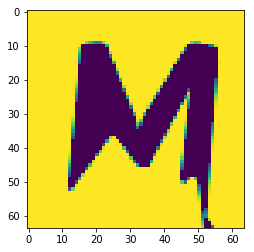

Epoch 0 0.00849771499633789 0.00022482851636596024
Epoch 1 5.960464477539063e-08 0.0002943583531305194
Epoch 2 5.960464477539063e-08 0.0004238507244735956
Epoch 3 0.009694516658782959 0.000561128428671509
Epoch 4 0.009694516658782959 0.000584131688810885
Epoch 5 0.02876293659210205 0.000689108797814697
Epoch 6 0.015088915824890137 0.0006825727177783847
Epoch 7 0.007582724094390869 0.0008278469904325902
Epoch 8 0.0274619460105896 0.0008863130933605134
Epoch 9 0.028642594814300537 0.0009474222897551954
Epoch 10 0.028642594814300537 0.0011903494596481323
Epoch 11 0.027653515338897705 0.0011892704060301185
Epoch 12 -0.06528675556182861 0.0011959956027567387
Epoch 13 0.015151679515838623 0.0011121818097308278
Epoch 14 0.027653515338897705 0.001035475404933095
Epoch 15 0.015151679515838623 0.0010197971714660525
Epoch 16 0.015151679515838623 0.0008860525558702648
Epoch 17 0.028593122959136963 0.0009555292199365795
Epoch 18 0.00186234712600708 0.0010296913096681237
Epoch 19 0.00186234712600708

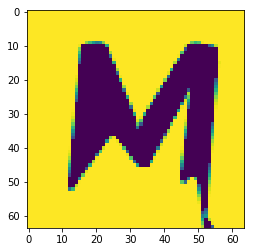

Epoch 0 0.009738802909851074 0.000306389934848994
Epoch 1 0.012213647365570068 0.0004098118224646896
Epoch 2 0.01198875904083252 0.0005721984780393541
Epoch 3 0.012066900730133057 0.0007687365869060159
Epoch 4 0.023326992988586426 0.0008496600203216076
Epoch 5 0.010212361812591553 0.0008793118176981807
Epoch 6 0.011805057525634766 0.0009652054868638515
Epoch 7 -0.006821870803833008 0.0010290887439623475
Epoch 8 -0.006821870803833008 0.001119277672842145
Epoch 9 -0.006821870803833008 0.0010650251060724258
Epoch 10 0.012880980968475342 0.0010730648646131158
Epoch 11 0.01907658576965332 0.001199569320306182
Epoch 12 0.01907658576965332 0.001128871226683259
Epoch 13 -0.006885886192321777 0.0012425323948264122
Epoch 14 -0.006885886192321777 0.0012456218246370554
Epoch 15 0.01968681812286377 0.001398321008309722
Epoch 16 0.013975322246551514 0.001342405448667705
Epoch 17 0.01452791690826416 0.0011755804298445582
Epoch 18 0.01452791690826416 0.0012481862213462591
Epoch 19 0.013222813606262207

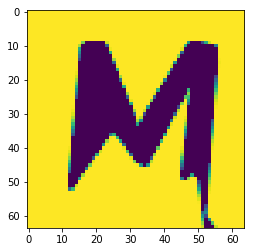

Epoch 0 0.0 0.0002537102554924786
Epoch 1 0.0 0.000300957151921466
Epoch 2 0.0 0.0004343166947364807
Epoch 3 0.004500925540924072 0.00048790802247822285
Epoch 4 0.005768716335296631 0.0005446129362098873
Epoch 5 0.009211957454681396 0.0006159176118671894
Epoch 6 0.009365558624267578 0.0006867952179163694
Epoch 7 0.009365558624267578 0.0008015203638933599
Epoch 8 0.009983539581298828 0.0009382920106872916
Epoch 9 0.00991600751876831 0.000957977375946939
Epoch 10 0.00578463077545166 0.0008985273307189345
Epoch 11 0.014824330806732178 0.0009520415915176272
Epoch 12 0.00991600751876831 0.0009792153723537922
Epoch 13 0.00991600751876831 0.0011564930900931358
Epoch 14 0.00991600751876831 0.0011227624490857124
Epoch 15 0.005864977836608887 0.0011758399195969105
Epoch 16 0.005864977836608887 0.0012602594215422869
Epoch 17 0.005864977836608887 0.0012882135342806578
Epoch 18 0.006589114665985107 0.0011210315860807896
Epoch 19 0.010647356510162354 0.0012249902356415987
torch.Size([3, 4]) torch.Si

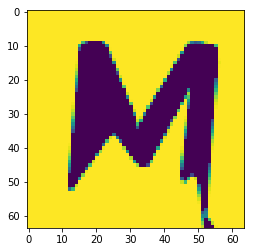

Epoch 0 -0.019124984741210938 0.0003112005942966789
Epoch 1 -0.019124984741210938 0.0004710572538897395
Epoch 2 0.0 0.0005681636976078153
Epoch 3 -0.019124984741210938 0.0007676928653381765
Epoch 4 -0.01921677589416504 0.0007565794512629509
Epoch 5 -0.020998358726501465 0.0007971517043188214
Epoch 6 -0.020998358726501465 0.000963508035056293
Epoch 7 -0.02115476131439209 0.0010770566295832396
Epoch 8 -0.02115476131439209 0.0008440078236162663
Epoch 9 -0.02097499370574951 0.000786591786891222
Epoch 10 -0.0027810335159301758 0.0007702141883783042
Epoch 11 -0.0001456737518310547 0.0005724624497815967
Epoch 12 -0.0033832788467407227 0.0005619829753413796
Epoch 13 -0.0033735036849975586 0.0005833156174048781
Epoch 14 -0.019085168838500977 0.0005650632083415985
Epoch 15 -0.019101619720458984 0.0006242238450795412
Epoch 16 -0.0026941299438476562 0.0005356263718567789
Epoch 17 0.009230196475982666 0.0005433802725747228
Epoch 18 0.009240150451660156 0.0006694106268696487
Epoch 19 0.0069392323493

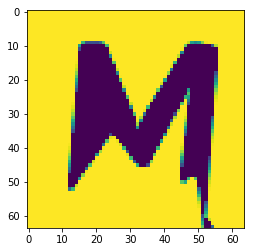

Epoch 0 0.006784200668334961 0.00034742659772746265
Epoch 1 -0.007323741912841797 0.000397817580960691
Epoch 2 -0.007323741912841797 0.0005660876631736755
Epoch 3 0.006609737873077393 0.0006285907584242523
Epoch 4 0.006609737873077393 0.0006393290823325515
Epoch 5 0.0039035677909851074 0.0007484451634809375
Epoch 6 0.0039035677909851074 0.0008138619596138597
Epoch 7 0.01074439287185669 0.0010274671949446201
Epoch 8 0.01074439287185669 0.0010828040540218353
Epoch 9 0.01074439287185669 0.0011565237073227763
Epoch 10 0.003077089786529541 0.001210362883284688
Epoch 11 0.006134450435638428 0.0014355664607137442
Epoch 12 0.006153225898742676 0.0013475398300215602
Epoch 13 -0.021291255950927734 0.0012844725279137492
Epoch 14 0.010868608951568604 0.0012923665344715118
Epoch 15 0.0063440799713134766 0.0012971707619726658
Epoch 16 0.006421029567718506 0.0012745168060064316
Epoch 17 -0.01959991455078125 0.00135823804885149
Epoch 18 0.0032160282135009766 0.0014445035485550761
Epoch 19 -0.023304939

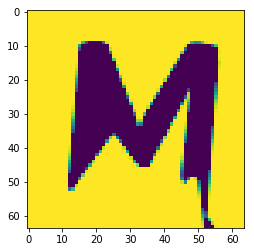

Epoch 0 0.03504347801208496 0.0002505717857275158
Epoch 1 0.014684498310089111 0.000317199039272964
Epoch 2 0.03504347801208496 0.0004575996135827154
Epoch 3 0.036087214946746826 0.0006380599224939942
Epoch 4 0.03504347801208496 0.0006369822658598423
Epoch 5 0.04252731800079346 0.0008126711472868919
Epoch 6 0.04267233610153198 0.0009223924716934562
Epoch 7 0.04180103540420532 0.0009206299437209964
Epoch 8 0.04667693376541138 0.001035588327795267
Epoch 9 0.04180103540420532 0.0010424666106700897
Epoch 10 0.05419278144836426 0.0012218691408634186
Epoch 11 0.05642217397689819 0.001257770461961627
Epoch 12 0.055001020431518555 0.0012382438872009516
Epoch 13 0.05577588081359863 0.001457354985177517
Epoch 14 0.07752656936645508 0.0015763184055685997
Epoch 15 0.055899858474731445 0.0016584102995693684
Epoch 16 0.07752656936645508 0.0016484621446579695
Epoch 17 0.07752656936645508 0.0017908004811033607
Epoch 18 0.07054823637008667 0.001878162263892591
Epoch 19 0.07054823637008667 0.00203547673

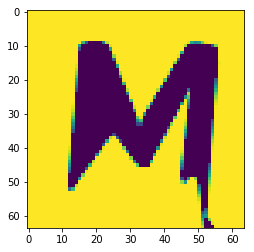

Epoch 0 0.023084640502929688 0.00039330669096671045
Epoch 1 0.015168309211730957 0.0003488004149403423
Epoch 2 0.015168309211730957 0.0004742172022815794
Epoch 3 0.023207783699035645 0.0005481698317453265
Epoch 4 0.025074243545532227 0.000554420636035502
Epoch 5 0.022814691066741943 0.0006673435564152896
Epoch 6 0.026739060878753662 0.000898427446372807
Epoch 7 0.026739060878753662 0.0008652596734464169
Epoch 8 0.026739060878753662 0.0009032824309542775
Epoch 9 0.03459721803665161 0.0011350056156516075
Epoch 10 0.03434687852859497 0.0011850217124447227
Epoch 11 0.023963451385498047 0.001409666845574975
Epoch 12 0.038301169872283936 0.0014677389990538359
Epoch 13 0.038301169872283936 0.0014276320580393076
Epoch 14 0.033340632915496826 0.0016230891924351454
Epoch 15 0.03357726335525513 0.001876892289146781
Epoch 16 0.05124795436859131 0.001892601139843464
Epoch 17 0.03357726335525513 0.001923330593854189
Epoch 18 0.03360331058502197 0.0019096131436526775
Epoch 19 0.03360331058502197 0.00

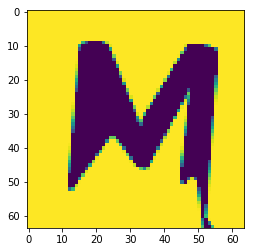

Epoch 0 -0.00016129016876220703 0.0002094532101182267
Epoch 1 0.01862436532974243 0.00044813574641011655
Epoch 2 0.01587235927581787 0.0005345930112525821
Epoch 3 0.01587235927581787 0.0007045721868053079
Epoch 4 0.017960965633392334 0.0008455830975435674
Epoch 5 0.017413020133972168 0.000698699033819139
Epoch 6 0.013799846172332764 0.000755265005864203
Epoch 7 0.01279979944229126 0.0009266327833756804
Epoch 8 0.012869834899902344 0.0008513812790624797
Epoch 9 0.012869834899902344 0.0007512957672588527
Epoch 10 0.012457966804504395 0.0008190433727577329
Epoch 11 0.012457966804504395 0.0008374815806746483
Epoch 12 0.007586240768432617 0.0008911752956919372
Epoch 13 -0.006322026252746582 0.0008462703553959727
Epoch 14 0.014646053314208984 0.0007743490277789533
Epoch 15 0.008562684059143066 0.0009421559516340494
Epoch 16 0.014044880867004395 0.0009510237723588943
Epoch 17 0.013880908489227295 0.000992568675428629
Epoch 18 0.013880908489227295 0.0013152685714885592
Epoch 19 0.0089543461799

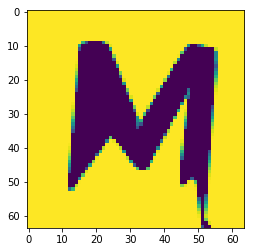

Epoch 0 -0.0014857053756713867 0.0002633621625136584
Epoch 1 -0.01461648941040039 0.00043284613639116287
Epoch 2 -0.014229416847229004 0.0006393451476469636
Epoch 3 -0.014327287673950195 0.0006153435097075999
Epoch 4 -0.015282034873962402 0.0006454226095229387
Epoch 5 0.0025110244750976562 0.0007182901026681066
Epoch 6 -0.007303953170776367 0.0007095180917531252
Epoch 7 -0.007779359817504883 0.0007851250702515244
Epoch 8 -0.007779359817504883 0.0007370204548351467
Epoch 9 0.0052301883697509766 0.0008881631074473262
Epoch 10 -0.005754590034484863 0.0008568059420213103
Epoch 11 -0.005754590034484863 0.0009956024587154388
Epoch 12 0.0034921765327453613 0.001079905079677701
Epoch 13 0.0034921765327453613 0.0011457205982878804
Epoch 14 0.002390921115875244 0.0012139646569266915
Epoch 15 -0.006479024887084961 0.001222159480676055
Epoch 16 0.002390921115875244 0.0012620406923815608
Epoch 17 -0.012737512588500977 0.001191847026348114
Epoch 18 -0.011779189109802246 0.0010951175354421139
Epoch 1

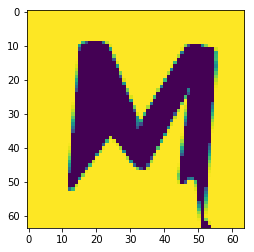

Epoch 0 0.0 0.00021315363119356334
Epoch 1 0.006137430667877197 0.00040335761150345206
Epoch 2 0.006137430667877197 0.00039597865543328226
Epoch 3 0.02170419692993164 0.0005927190650254488
Epoch 4 0.016165971755981445 0.0006952012772671878
Epoch 5 0.013653755187988281 0.0005913976347073913
Epoch 6 0.013653755187988281 0.0007444536313414574
Epoch 7 0.0183103084564209 0.0007780095911584795
Epoch 8 0.015938758850097656 0.001008894294500351
Epoch 9 -0.00019037723541259766 0.0010969731956720352
Epoch 10 0.006965517997741699 0.0010760953882709146
Epoch 11 0.02564561367034912 0.001031009596772492
Epoch 12 0.02564561367034912 0.0010909317061305046
Epoch 13 0.018281757831573486 0.0009739968809299171
Epoch 14 0.018613159656524658 0.0009452560334466398
Epoch 15 0.025280356407165527 0.0010795239359140396
Epoch 16 0.025280356407165527 0.0009798050159588456
Epoch 17 0.02484363317489624 0.001009249477647245
Epoch 18 0.01401454210281372 0.0012366131413727999
Epoch 19 0.023694097995758057 0.00120948790

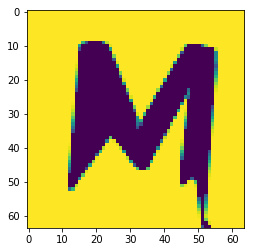

Epoch 0 0.0002924799919128418 0.00034966779639944434
Epoch 1 0.0035715699195861816 0.0004097572236787528
Epoch 2 0.0032596588134765625 0.0003473235701676458
Epoch 3 0.0037606358528137207 0.0003363852738402784
Epoch 4 0.004045248031616211 0.0004308598581701517
Epoch 5 -0.0013158321380615234 0.0004631106276065111
Epoch 6 0.009013772010803223 0.0007466993993148208
Epoch 7 0.007880926132202148 0.000910002738237381
Epoch 8 -0.019096016883850098 0.0009615948656573892
Epoch 9 -0.019096016883850098 0.0011676694266498089
Epoch 10 -0.002059340476989746 0.0010744365863502026
Epoch 11 0.007880926132202148 0.0011612685630097985
Epoch 12 -0.0040204524993896484 0.0012069891672581434
Epoch 13 0.003359854221343994 0.001176588935777545
Epoch 14 -0.0026830434799194336 0.0010437499731779099
Epoch 15 0.009462952613830566 0.001193028292618692
Epoch 16 0.009728074073791504 0.0012870708014816046
Epoch 17 0.009427547454833984 0.0012092081597074866
Epoch 18 0.008013308048248291 0.001351770362816751
Epoch 19 0.0

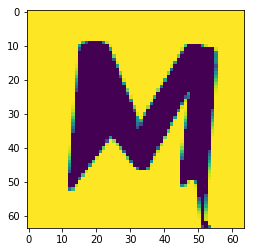

Epoch 0 0.0 0.00020000358927063644
Epoch 1 -0.0017316341400146484 0.000363746628863737
Epoch 2 -0.011535406112670898 0.0005832537426613271
Epoch 3 -0.0007735490798950195 0.0007335575064644217
Epoch 4 -0.0007735490798950195 0.0007934937020763755
Epoch 5 -0.0007735490798950195 0.000937020406126976
Epoch 6 -0.0007735490798950195 0.0009509025840088725
Epoch 7 -0.0007735490798950195 0.0010835378197953105
Epoch 8 -0.0007735490798950195 0.001179340062662959
Epoch 9 -0.0007735490798950195 0.0012138509191572666
Epoch 10 -0.0007735490798950195 0.0012225250247865915
Epoch 11 -1.9669532775878906e-05 0.001306250924244523
Epoch 12 0.00011563301086425781 0.0013232737546786666
Epoch 13 -0.01842200756072998 0.0014583239099010825
Epoch 14 -0.01842200756072998 0.0015594169963151217
Epoch 15 0.00743788480758667 0.0016482004430145025
Epoch 16 0.00743788480758667 0.0015080298762768507
Epoch 17 0.00743788480758667 0.0014550958294421434
Epoch 18 0.005170345306396484 0.0014595709508284926
Epoch 19 0.0051703453

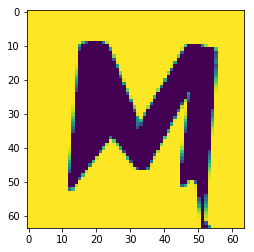

Epoch 0 -0.00038230419158935547 0.00044108059955760837
Epoch 1 -0.00038230419158935547 0.0004622036940418184
Epoch 2 0.0029054880142211914 0.0005524511798284948
Epoch 3 -0.015165209770202637 0.0007160803070291877
Epoch 4 -0.00038230419158935547 0.0004844514187425375
Epoch 5 -0.012349247932434082 0.0006244389223866165
Epoch 6 -0.011936783790588379 0.0007724249153397977
Epoch 7 0.006486237049102783 0.0008757069008424878
Epoch 8 0.00600278377532959 0.0011514911893755198
Epoch 9 0.006433665752410889 0.0010645078727975488
Epoch 10 0.0024875998497009277 0.000979190575890243
Epoch 11 0.009789228439331055 0.0009527252987027168
Epoch 12 0.014310240745544434 0.0010392473777756095
Epoch 13 0.013899803161621094 0.00120411510579288
Epoch 14 -0.00514066219329834 0.0011045009596273303
Epoch 15 -0.0017086267471313477 0.0011559491977095604
Epoch 16 -0.0017086267471313477 0.0011970358900725842
Epoch 17 -0.0017086267471313477 0.0012597148306667805
Epoch 18 -0.02761387825012207 0.0012956209247931838
Epoch

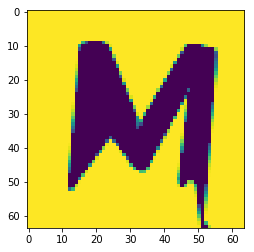

Epoch 0 0.015223026275634766 0.00041106887510977685
Epoch 1 0.012225091457366943 0.0005398020730353892
Epoch 2 0.004101574420928955 0.0006620261701755226
Epoch 3 0.004101574420928955 0.0008585910545662045
Epoch 4 0.0093003511428833 0.0007250303751789033
Epoch 5 0.017400741577148438 0.00086640112567693
Epoch 6 0.005593419075012207 0.0009697491186670959
Epoch 7 0.017400741577148438 0.0008940747939050198
Epoch 8 0.017400741577148438 0.00102045142557472
Epoch 9 0.017400741577148438 0.0010028433753177524
Epoch 10 0.017400741577148438 0.001261254190467298
Epoch 11 0.017400741577148438 0.0013426358345896006
Epoch 12 0.017400741577148438 0.0014266055077314377
Epoch 13 0.01735299825668335 0.001509501482360065
Epoch 14 0.01679515838623047 0.001556818257085979
Epoch 15 0.01679515838623047 0.0015174606814980507
Epoch 16 0.01679515838623047 0.001465698704123497
Epoch 17 0.01735299825668335 0.0014519831165671349
Epoch 18 0.01735299825668335 0.0014457788784056902
Epoch 19 0.01735299825668335 0.001508

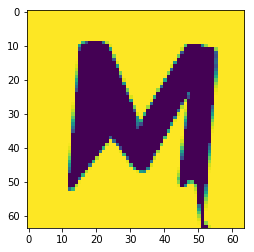

Epoch 0 -0.0033370256423950195 0.00041059378418140113
Epoch 1 0.0 0.0003402230213396251
Epoch 2 0.0002484321594238281 0.0004355630953796208
Epoch 3 0.0030999183654785156 0.0004200539260637015
Epoch 4 0.0030999183654785156 0.0005901510594412684
Epoch 5 0.0030999183654785156 0.0005991951329633594
Epoch 6 0.0030999183654785156 0.0005366328405216336
Epoch 7 0.0030999183654785156 0.0007001805934123695
Epoch 8 -0.0005280971527099609 0.0007705953903496265
Epoch 9 -0.0005280971527099609 0.0006846910109743476
Epoch 10 -0.002721548080444336 0.00070108228828758
Epoch 11 0.0033621788024902344 0.0009278759243898094
Epoch 12 0.0031613707542419434 0.0007508997223339975
Epoch 13 -0.009122610092163086 0.0008620644803158939
Epoch 14 0.00022017955780029297 0.0009842079598456621
Epoch 15 0.00022017955780029297 0.0010988975409418344
Epoch 16 0.00022017955780029297 0.0011471331818029284
Epoch 17 0.00038230419158935547 0.0011585676111280918
Epoch 18 0.00038230419158935547 0.001250005792826414
Epoch 19 0.0003

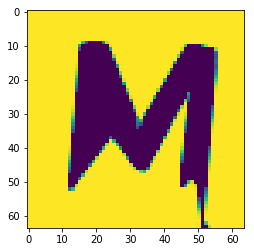

Epoch 0 0.0028285980224609375 0.00021946686320006847
Epoch 1 0.0028285980224609375 0.0004009494441561401
Epoch 2 0.0028285980224609375 0.0005033191409893334
Epoch 3 0.0028285980224609375 0.0004797553992830217
Epoch 4 0.0028285980224609375 0.0005023041157983243
Epoch 5 0.0028285980224609375 0.0006030602380633354
Epoch 6 0.0028285980224609375 0.0006427097832784057
Epoch 7 -0.0035969018936157227 0.0006541426992043853
Epoch 8 -0.014153122901916504 0.0006899269064888358
Epoch 9 -0.010961651802062988 0.0007830012473277748
Epoch 10 0.0001239180564880371 0.0007867816602811217
Epoch 11 -0.0003339052200317383 0.0008375283214263618
Epoch 12 -0.008595108985900879 0.0009974363492801785
Epoch 13 -0.006919264793395996 0.001020870404317975
Epoch 14 -0.010961651802062988 0.0010140064405277371
Epoch 15 -0.0002524852752685547 0.0010854370193555951
Epoch 16 -0.0002524852752685547 0.001177365193143487
Epoch 17 0.00020521879196166992 0.001202011713758111
Epoch 18 -0.00351560115814209 0.0012006659526377916
E

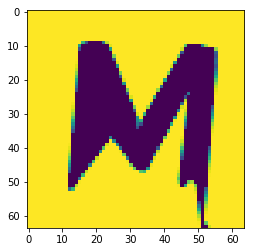

Epoch 0 0.0 0.0002488407480996102
Epoch 1 -0.003171682357788086 0.0002944256120827049
Epoch 2 0.0 0.00029814449953846633
Epoch 3 -0.0027126073837280273 0.00039217097219079733
Epoch 4 -0.005692243576049805 0.0005798297934234142
Epoch 5 -0.005692243576049805 0.0005753319128416479
Epoch 6 -0.005692243576049805 0.0005120662390254438
Epoch 7 -0.005692243576049805 0.0007723511080257595
Epoch 8 -0.0036399364471435547 0.0006730181048624218
Epoch 9 -0.005692243576049805 0.0005761979846283793
Epoch 10 -0.005692243576049805 0.0005005570128560066
Epoch 11 -0.005692243576049805 0.0006801319541409612
Epoch 12 -0.0027126073837280273 0.0006297981599345803
Epoch 13 -0.0036399364471435547 0.0007489743875339627
Epoch 14 -0.0027126073837280273 0.0006100250757299364
Epoch 15 -0.005567073822021484 0.0008257913868874311
Epoch 16 -0.0021131038665771484 0.0008763931691646576
Epoch 17 -0.005567073822021484 0.0008977510733529925
Epoch 18 -0.005692243576049805 0.001030667219310999
Epoch 19 -0.009420037269592285 0

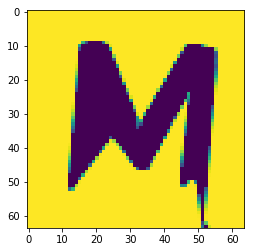

Epoch 0 -0.0004067420959472656 0.00028318274416960776
Epoch 1 0.0 0.00027891687932424247
Epoch 2 -0.0004067420959472656 0.0005545168532989919
Epoch 3 0.0072386860847473145 0.0005871480097994208
Epoch 4 0.0072386860847473145 0.0008198480936698616
Epoch 5 0.0072386860847473145 0.0008807658450677991
Epoch 6 0.0038170218467712402 0.0008795381290838122
Epoch 7 0.0072386860847473145 0.0010231274645775557
Epoch 8 0.0072386860847473145 0.000980700715444982
Epoch 9 0.0072386860847473145 0.0009758357773534954
Epoch 10 0.0072386860847473145 0.0008987061446532607
Epoch 11 0.0072386860847473145 0.0009237576159648597
Epoch 12 0.003692924976348877 0.0009175774175673723
Epoch 13 0.0038170218467712402 0.000962365185841918
Epoch 14 -0.007884860038757324 0.001098813721910119
Epoch 15 0.0072386860847473145 0.001093387953005731
Epoch 16 0.0072386860847473145 0.0010979919461533427
Epoch 17 0.0 0.0012330212630331516
Epoch 18 -0.017544269561767578 0.0011353249428793788
Epoch 19 0.0072386860847473145 0.0011849

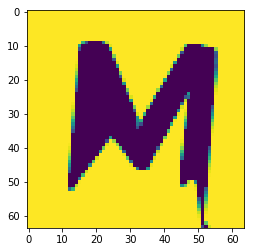

Epoch 0 -0.008217096328735352 0.0004166473518125713
Epoch 1 -0.0019407272338867188 0.0005206455825828016
Epoch 2 -0.008391380310058594 0.0005727423122152686
Epoch 3 -0.021140694618225098 0.0006437710835598409
Epoch 4 -0.0019407272338867188 0.0007160820532590151
Epoch 5 -0.008391380310058594 0.0006942464970052242
Epoch 6 -0.0019407272338867188 0.0006968325469642878
Epoch 7 -0.008391380310058594 0.0007508847629651427
Epoch 8 -0.0019407272338867188 0.0006873331731185317
Epoch 9 0.0 0.0007591743487864733
Epoch 10 0.002108633518218994 0.000990790082141757
Epoch 11 -0.0015236139297485352 0.0009798650862649083
Epoch 12 -0.0015236139297485352 0.0011350538115948439
Epoch 13 -0.0005983114242553711 0.001147731556557119
Epoch 14 -0.012002944946289062 0.0011986895697191358
Epoch 15 0.002108633518218994 0.0013089182320982218
Epoch 16 0.002108633518218994 0.0013720139395445585
Epoch 17 0.002108633518218994 0.0015309652080759406
Epoch 18 0.002108633518218994 0.0015677422052249312
Epoch 19 -0.004322171

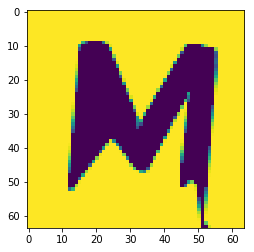

Epoch 0 -0.005829453468322754 0.0003029050421901047
Epoch 1 0.0 0.00032068410655483603
Epoch 2 -0.0032738447189331055 0.0004223193973302841
Epoch 3 -0.005829453468322754 0.00041881779907271266
Epoch 4 -0.0032738447189331055 0.000495175423566252
Epoch 5 -0.0032738447189331055 0.0005995812825858593
Epoch 6 0.006557285785675049 0.0008485766593366861
Epoch 7 0.00376737117767334 0.000749163213185966
Epoch 8 0.006557285785675049 0.0008981507271528244
Epoch 9 0.0007472038269042969 0.0009506386704742908
Epoch 10 0.0027864575386047363 0.0011125840246677399
Epoch 11 0.0007472038269042969 0.0011354124872013927
Epoch 12 0.0007472038269042969 0.0010228611063212156
Epoch 13 0.0027864575386047363 0.001177195692434907
Epoch 14 0.0027864575386047363 0.0013022359926253557
Epoch 15 0.006403028964996338 0.0012150865513831377
Epoch 16 0.006403028964996338 0.0013538887724280357
Epoch 17 0.0027864575386047363 0.001329726306721568
Epoch 18 0.0007472038269042969 0.0012207794934511185
Epoch 19 0.003767371177673

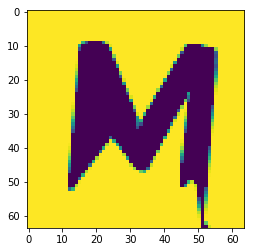

Epoch 0 0.007035791873931885 0.00032067191204987466
Epoch 1 0.0003160834312438965 0.00039069028571248055
Epoch 2 -0.0030945539474487305 0.00043294369243085384
Epoch 3 -0.0030945539474487305 0.0004538624198175967
Epoch 4 0.007362723350524902 0.0005749923875555396
Epoch 5 -0.004177093505859375 0.0006982923950999975
Epoch 6 0.006058394908905029 0.0007413050043396652
Epoch 7 0.008043944835662842 0.0007858388125896454
Epoch 8 0.008043944835662842 0.0007448354735970497
Epoch 9 0.004939913749694824 0.0008162723388522863
Epoch 10 -0.001116633415222168 0.0009918396826833487
Epoch 11 0.007239997386932373 0.0008512744097970426
Epoch 12 -0.01915132999420166 0.0009783664718270302
Epoch 13 -0.00024366378784179688 0.0011456252541393042
Epoch 14 0.007239997386932373 0.0011926597217097878
Epoch 15 0.007239997386932373 0.0011975237866863608
Epoch 16 0.007239997386932373 0.0013334713876247406
Epoch 17 0.01292651891708374 0.0013474260922521353
Epoch 18 0.01292651891708374 0.0013694784138351679
Epoch 19 0.

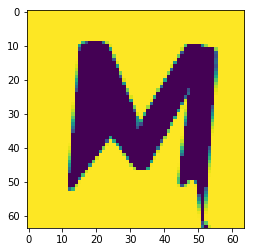

Epoch 0 0.00040781497955322266 0.0002660596219357103
Epoch 1 -0.00011277198791503906 0.0004308302595745772
Epoch 2 -0.00011277198791503906 0.0006740684621036053
Epoch 3 -0.00011277198791503906 0.0008122582221403718
Epoch 4 -0.00011277198791503906 0.0006509487866424024
Epoch 5 -0.00011277198791503906 0.0008051845943555236
Epoch 6 -0.014225006103515625 0.0009231487056240439
Epoch 7 -0.0046999454498291016 0.0008464423008263111
Epoch 8 -0.0046999454498291016 0.0008904151036404073
Epoch 9 0.0019556283950805664 0.0008703276980668306
Epoch 10 0.005577147006988525 0.0010444424115121365
Epoch 11 0.0010342597961425781 0.0009256518678739667
Epoch 12 0.007427990436553955 0.0008285294752568007
Epoch 13 0.0010342597961425781 0.0009069647057913244
Epoch 14 0.007427990436553955 0.000969500164501369
Epoch 15 0.010914981365203857 0.0010345412883907557
Epoch 16 0.0010342597961425781 0.001139471190981567
Epoch 17 0.0010342597961425781 0.0011085838777944446
Epoch 18 -0.007875919342041016 0.0010536130284890

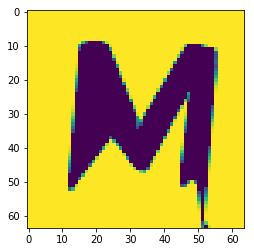

Epoch 0 0.0 0.0003082008333876729
Epoch 1 0.009029030799865723 0.00021309957082848996
Epoch 2 0.009312093257904053 0.0005082005518488586
Epoch 3 0.009312093257904053 0.0005238188314251602
Epoch 4 0.009312093257904053 0.0005333637818694115
Epoch 5 0.0024561285972595215 0.0005636337446048856
Epoch 6 0.0022590160369873047 0.0007136780768632889
Epoch 7 0.0022590160369873047 0.0006402416620403528
Epoch 8 0.009312093257904053 0.00055936467833817
Epoch 9 0.009312093257904053 0.0006780049297958612
Epoch 10 0.0024561285972595215 0.000666015490423888
Epoch 11 0.004141747951507568 0.0007322022574953735
Epoch 12 0.003646373748779297 0.0006763637065887451
Epoch 13 0.003646373748779297 0.0007762757013551891
Epoch 14 0.003646373748779297 0.0006990915862843394
Epoch 15 -0.0017186403274536133 0.0006127144442871213
Epoch 16 0.004622995853424072 0.0006004925817251205
Epoch 17 -0.003086686134338379 0.0006452828529290855
Epoch 18 0.007409811019897461 0.0006765766302123666
Epoch 19 0.0007835030555725098 0.0

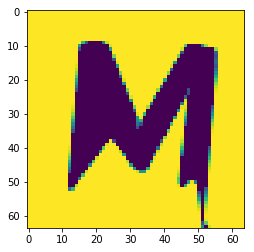

Epoch 0 0.0 0.00020775303710252047
Epoch 1 0.0 0.0003334557404741645
Epoch 2 0.0 0.0005205281777307391
Epoch 3 0.0 0.0005670747486874461
Epoch 4 0.0018341541290283203 0.000660506309941411
Epoch 5 0.009000957012176514 0.0006854397943243384
Epoch 6 0.003427743911743164 0.0007206988520920277
Epoch 7 0.003427743911743164 0.000770268845371902
Epoch 8 0.008514821529388428 0.0007662652060389519
Epoch 9 0.008514821529388428 0.0009023715974763036
Epoch 10 0.008514821529388428 0.0008511731284670532
Epoch 11 0.008514821529388428 0.0009925016202032566
Epoch 12 0.007515072822570801 0.001191539689898491
Epoch 13 0.0053604841232299805 0.0011784364469349384
Epoch 14 0.010821402072906494 0.0012775874929502606
Epoch 15 0.008897542953491211 0.001364056020975113
Epoch 16 0.0053604841232299805 0.001572506851516664
Epoch 17 0.010561168193817139 0.0015965690836310387
Epoch 18 0.0027361512184143066 0.001670507132075727
Epoch 19 -0.002209186553955078 0.0018818480893969536
torch.Size([3, 4]) torch.Size([3, 4]) 

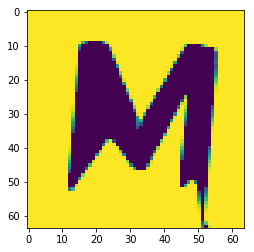

Epoch 0 0.009598195552825928 0.0002588145434856415
Epoch 1 0.009598195552825928 0.00033494073431938887
Epoch 2 0.012697935104370117 0.0005780658684670925
Epoch 3 0.012697935104370117 0.0006490190280601382
Epoch 4 0.012759625911712646 0.0007610454922541976
Epoch 5 0.012697935104370117 0.0007658735848963261
Epoch 6 0.009598195552825928 0.000778442423325032
Epoch 7 0.012721240520477295 0.0008463566191494465
Epoch 8 0.009309887886047363 0.001021737465634942
Epoch 9 0.011947095394134521 0.0009534244309179485
Epoch 10 0.011947095394134521 0.0010775242699310184
Epoch 11 0.011947095394134521 0.0012176157906651497
Epoch 12 0.011946141719818115 0.0012854347005486488
Epoch 13 0.01256650686264038 0.0012479263823479414
Epoch 14 0.01256650686264038 0.0013374402187764645
Epoch 15 0.01256650686264038 0.0011285593500360847
Epoch 16 0.011102080345153809 0.0013733695959672332
Epoch 17 0.012762069702148438 0.001323912525549531
Epoch 18 0.011102080345153809 0.0012335246428847313
Epoch 19 0.0070931911468505

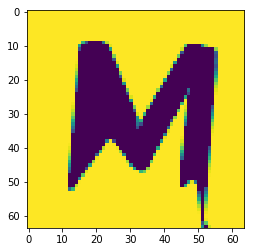

Epoch 0 -0.00160980224609375 0.00034902579500339925
Epoch 1 5.960464477539063e-08 0.0004570761229842901
Epoch 2 0.00216519832611084 0.0007304727332666516
Epoch 3 5.960464477539063e-08 0.0005563992890529335
Epoch 4 -0.006211400032043457 0.000581737607717514
Epoch 5 0.00539630651473999 0.000697434414178133
Epoch 6 0.0022745132446289062 0.0008353632292710245
Epoch 7 0.0022745132446289062 0.0008705497602932155
Epoch 8 0.00539630651473999 0.001116134226322174
Epoch 9 0.00548785924911499 0.0011959322728216648
Epoch 10 -0.0016019344329833984 0.00140733877196908
Epoch 11 0.00548785924911499 0.0013118943898007274
Epoch 12 0.004426777362823486 0.0013096857583150268
Epoch 13 0.0038160085678100586 0.0013095554895699024
Epoch 14 0.0022745132446289062 0.0011460867244750261
Epoch 15 0.0048642754554748535 0.0012973662232980132
Epoch 16 0.0036280155181884766 0.00123286759480834
Epoch 17 0.0048642754554748535 0.0012109968811273575
Epoch 18 0.0036280155181884766 0.0012211368884891272
Epoch 19 0.005531430

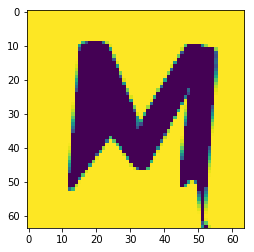

Epoch 0 0.0 0.00025462923804298043
Epoch 1 0.0 0.00038582945126108825
Epoch 2 0.0 0.0004212146159261465
Epoch 3 -0.0019140243530273438 0.00036816412466578186
Epoch 4 -0.0018224716186523438 0.0004690167843364179
Epoch 5 -0.0008127689361572266 0.0005271789850667119
Epoch 6 -0.0018224716186523438 0.0005689195240847766
Epoch 7 -0.0008127689361572266 0.0006237073102965951
Epoch 8 -0.0008127689361572266 0.0006262905080802739
Epoch 9 -0.0026481151580810547 0.0005890776519663632
Epoch 10 -0.0026481151580810547 0.0004902026848867536
Epoch 11 -0.0011962652206420898 0.0006163099315017462
Epoch 12 -0.0010472536087036133 0.000537735118996352
Epoch 13 -0.00013589859008789062 0.0005626402562484145
Epoch 14 -0.00013589859008789062 0.0005473081255331635
Epoch 15 -0.0032750368118286133 0.0007297955453395844
Epoch 16 -0.002908945083618164 0.0008065865840762854
Epoch 17 -0.0032750368118286133 0.0007326010381802917
Epoch 18 -0.00013589859008789062 0.000802157330326736
Epoch 19 -0.0011107921600341797 0.0007

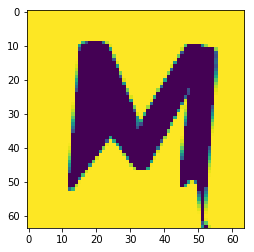

Epoch 0 0.000722348690032959 0.00030783668626099825
Epoch 1 0.00014352798461914062 0.0004026161041110754
Epoch 2 0.0016856193542480469 0.0004190129693597555
Epoch 3 0.00023448467254638672 0.0006330199539661407
Epoch 4 0.00023448467254638672 0.0008121795835904777
Epoch 5 -0.00021851062774658203 0.0010097530903294683
Epoch 6 0.00715559720993042 0.0011318523902446032
Epoch 7 0.00715559720993042 0.0011441807728260756
Epoch 8 0.008197367191314697 0.0010406486690044403
Epoch 9 0.008199512958526611 0.001256160088814795
Epoch 10 0.008197367191314697 0.0013623833656311035
Epoch 11 0.007959365844726562 0.0015967569779604673
Epoch 12 0.008660495281219482 0.001548450207337737
Epoch 13 0.009976565837860107 0.0015758492518216372
Epoch 14 0.007959365844726562 0.0018892459338530898
Epoch 15 0.008878171443939209 0.0018973611295223236
Epoch 16 0.009969174861907959 0.0019511230057105422
Epoch 17 0.008672654628753662 0.002194286324083805
Epoch 18 0.010718941688537598 0.0022718235850334167
Epoch 19 0.01331

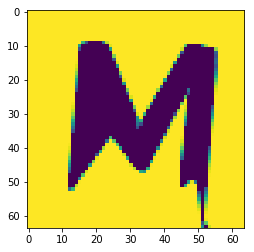

Epoch 0 0.0008842945098876953 0.00042908205068670213
Epoch 1 0.0008155703544616699 0.0006295327330008149
Epoch 2 0.0006054043769836426 0.0008347057737410069
Epoch 3 0.0029459595680236816 0.0012266484554857016
Epoch 4 0.0018817782402038574 0.0014550912892445922
Epoch 5 0.010459363460540771 0.0018813218921422958
Epoch 6 0.006575405597686768 0.001962922280654311
Epoch 7 0.012500166893005371 0.001958785578608513
Epoch 8 0.014606833457946777 0.002084453124552965
Epoch 9 0.02118605375289917 0.0022671555634588003
Epoch 10 0.022433936595916748 0.0023475573398172855
Epoch 11 0.022433936595916748 0.0025081816129386425
Epoch 12 0.026496589183807373 0.002654748735949397
Epoch 13 0.025321543216705322 0.002830975688993931
Epoch 14 0.025165796279907227 0.003022704040631652
Epoch 15 0.02951270341873169 0.003307193983346224
Epoch 16 0.03464400768280029 0.0034653088077902794
Epoch 17 0.03464400768280029 0.003684191033244133
Epoch 18 0.03653234243392944 0.003972112201154232
Epoch 19 0.038542747497558594 

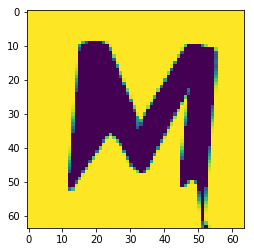

Epoch 0 0.0003394484519958496 0.00044727977365255356
Epoch 1 -0.00019657611846923828 0.0006551165133714676
Epoch 2 0.0013484358787536621 0.0010482992511242628
Epoch 3 0.006865382194519043 0.0013453473802655935
Epoch 4 0.012113392353057861 0.0015939108561724424
Epoch 5 0.017434239387512207 0.0019275903468951583
Epoch 6 0.02208256721496582 0.0022825615014880896
Epoch 7 0.02208256721496582 0.002492523519322276
Epoch 8 0.02307659387588501 0.002791690407320857
Epoch 9 0.024609863758087158 0.0031092469580471516
Epoch 10 0.028367578983306885 0.0035853253211826086
Epoch 11 0.02982938289642334 0.0038082709070295095
Epoch 12 0.028076529502868652 0.004067466594278812
Epoch 13 0.030637800693511963 0.004142550751566887
Epoch 14 0.03661221265792847 0.004498348571360111
Epoch 15 0.04313921928405762 0.0047773090191185474
Epoch 16 0.044057607650756836 0.004992585629224777
Epoch 17 0.04646581411361694 0.005360168404877186
Epoch 18 0.047399818897247314 0.005655701272189617
Epoch 19 0.04775112867355347 0.

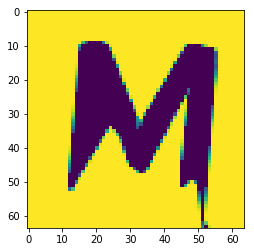

Epoch 0 -0.0012584924697875977 0.00042547236080281436
Epoch 1 0.0022243261337280273 0.0006505621131509542
Epoch 2 0.005758106708526611 0.0008658652077428997
Epoch 3 0.0054694414138793945 0.0011046133004128933
Epoch 4 0.010647952556610107 0.0013206828152760863
Epoch 5 0.01180410385131836 0.0015336915384978056
Epoch 6 0.010867416858673096 0.0017942975973710418
Epoch 7 0.012799084186553955 0.0021135169081389904
Epoch 8 0.013057231903076172 0.0022376510314643383
Epoch 9 0.012210607528686523 0.0025657331570982933
Epoch 10 0.01660299301147461 0.0029299291782081127
Epoch 11 0.01579451560974121 0.0032723438926041126
Epoch 12 0.02074563503265381 0.0034298624377697706
Epoch 13 0.021817445755004883 0.003632068634033203
Epoch 14 0.021817445755004883 0.003647248726338148
Epoch 15 0.027199149131774902 0.004095123149454594
Epoch 16 0.027199149131774902 0.004215286113321781
Epoch 17 0.027265310287475586 0.004491455387324095
Epoch 18 0.02690279483795166 0.0044288430362939835
Epoch 19 0.0279267430305480

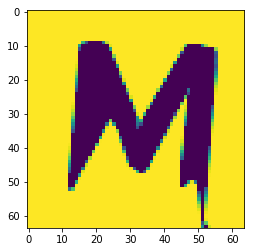

Epoch 0 0.0008053183555603027 0.00039283762453123927
Epoch 1 0.001073300838470459 0.0008256783476099372
Epoch 2 0.003710925579071045 0.00106246885843575
Epoch 3 0.0041844844818115234 0.0010585634736344218
Epoch 4 0.0042833685874938965 0.0013445951044559479
Epoch 5 0.0045566558837890625 0.0015582686755806208
Epoch 6 0.006226003170013428 0.0017306739464402199
Epoch 7 0.006852507591247559 0.0018346498254686594
Epoch 8 0.006669759750366211 0.0019580423831939697
Epoch 9 0.006304383277893066 0.001968187279999256
Epoch 10 0.006304383277893066 0.0021872897632420063
Epoch 11 0.005163133144378662 0.00234919018112123
Epoch 12 0.006616830825805664 0.0024838061071932316
Epoch 13 0.006616830825805664 0.0024961461313068867
Epoch 14 0.00847393274307251 0.002726063597947359
Epoch 15 0.00847393274307251 0.0028957815375179052
Epoch 16 0.013470232486724854 0.0029959320090711117
Epoch 17 0.013470232486724854 0.002894147764891386
Epoch 18 0.014366567134857178 0.0029103416018188
Epoch 19 0.01398622989654541 

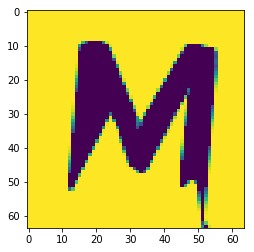

Pass 1
Epoch 0 0.0 0.00031488065724261105
Epoch 1 0.0 0.0005040478426963091
Epoch 2 0.023471951484680176 0.0006285975105129182
Epoch 3 0.023471951484680176 0.0007244630251079798
Epoch 4 0.02461230754852295 0.0007318248972296715
Epoch 5 0.0032786130905151367 0.0008992076618596911
Epoch 6 0.02461230754852295 0.000740611634682864
Epoch 7 0.023471951484680176 0.0007328497595153749
Epoch 8 0.023471951484680176 0.0007040725904516876
Epoch 9 -0.007337093353271484 0.0008016013307496905
Epoch 10 0.023471951484680176 0.0007933943998068571
Epoch 11 0.023471951484680176 0.0009061781456694007
Epoch 12 0.023471951484680176 0.0011182096786797047
Epoch 13 0.026723265647888184 0.0011954964138567448
Epoch 14 0.026723265647888184 0.0011477877851575613
Epoch 15 0.011715054512023926 0.0013014677679166198
Epoch 16 0.026723265647888184 0.0011836775811389089
Epoch 17 0.026723265647888184 0.0013484105002135038
Epoch 18 0.011166870594024658 0.0012622680515050888
Epoch 19 0.027032852172851562 0.00125795777421444

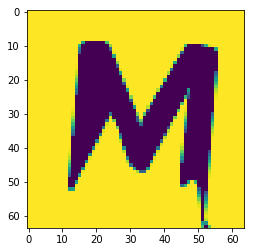

Epoch 0 -0.005481123924255371 0.00024343153927475214
Epoch 1 -0.005632996559143066 0.00037351096398197114
Epoch 2 -0.009253501892089844 0.0004633442440535873
Epoch 3 -0.06619060039520264 0.0006283280672505498
Epoch 4 -0.0004172325134277344 0.0006522692274302244
Epoch 5 -0.0006362199783325195 0.0005528429173864424
Epoch 6 -0.005653023719787598 0.0006338003440760076
Epoch 7 -0.013129830360412598 0.0007027137908153236
Epoch 8 -0.006994724273681641 0.000539354223292321
Epoch 9 -0.003864765167236328 0.0006897163111716509
Epoch 10 -0.05888640880584717 0.0009352997876703739
Epoch 11 -0.004300355911254883 0.0009507012437097728
Epoch 12 -0.004300355911254883 0.0008000963134691119
Epoch 13 -0.004300355911254883 0.0008891870966181159
Epoch 14 -0.12461566925048828 0.00104180455673486
Epoch 15 0.006529688835144043 0.0010670588817447424
Epoch 16 0.007196545600891113 0.0010087138507515192
Epoch 17 -0.008836030960083008 0.0009570943657308817
Epoch 18 -0.05919456481933594 0.0009722793474793434
Epoch 19

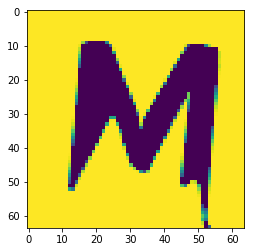

Epoch 0 0.07341361045837402 0.00023385601525660604
Epoch 1 0.11613237857818604 0.00046643856330774724
Epoch 2 0.13123315572738647 0.0007509772549383342
Epoch 3 0.13096308708190918 0.000809140270575881
Epoch 4 0.13123315572738647 0.000833483412861824
Epoch 5 0.11950600147247314 0.0007095595356076956
Epoch 6 0.13123315572738647 0.0008714848663657904
Epoch 7 0.10050290822982788 0.0009703208925202489
Epoch 8 0.13100981712341309 0.000884435954503715
Epoch 9 0.13127994537353516 0.0009520198218524456
Epoch 10 0.13100981712341309 0.0010449625551700592
Epoch 11 0.11788153648376465 0.0009567728266119957
Epoch 12 0.12285470962524414 0.001092506106942892
Epoch 13 0.12285470962524414 0.0009566161315888166
Epoch 14 0.12700426578521729 0.0009860792197287083
Epoch 15 0.12670522928237915 0.0011771747376769781
Epoch 16 0.12905144691467285 0.0011738972971215844
Epoch 17 0.12861311435699463 0.0012054569087922573
Epoch 18 0.12833905220031738 0.0012401614803820848
Epoch 19 0.12047064304351807 0.001467481488

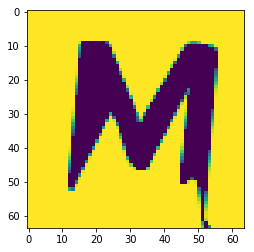

Epoch 0 -0.06945383548736572 0.0003629898128565401
Epoch 1 0.00929415225982666 0.00031723163556307554
Epoch 2 -0.023454904556274414 0.00046058458974584937
Epoch 3 -0.015822529792785645 0.0005268726381473243
Epoch 4 -0.03450191020965576 0.0006747342413291335
Epoch 5 0.007276177406311035 0.000707983854226768
Epoch 6 0.008343696594238281 0.0008951482595875859
Epoch 7 0.008343696594238281 0.0011128687765449286
Epoch 8 0.008343696594238281 0.0010219495743513107
Epoch 9 0.008316457271575928 0.0008839303045533597
Epoch 10 0.008316457271575928 0.0011437700595706701
Epoch 11 -2.1576881408691406e-05 0.0010999933583661914
Epoch 12 -2.1576881408691406e-05 0.0011678854934871197
Epoch 13 0.0016379952430725098 0.0011934922076761723
Epoch 14 -2.1576881408691406e-05 0.001257332623936236
Epoch 15 0.009113013744354248 0.00136886490508914
Epoch 16 0.007258594036102295 0.0014755588490515947
Epoch 17 -0.022025346755981445 0.0016030191909521818
Epoch 18 0.011861979961395264 0.0015508540673181415
Epoch 19 0.0

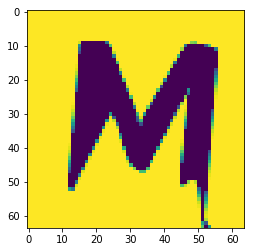

Epoch 0 -0.0010802745819091797 0.0003483779146336019
Epoch 1 -0.0010802745819091797 0.00034603336825966835
Epoch 2 0.0007932782173156738 0.0004739763680845499
Epoch 3 0.0009019374847412109 0.0005508320755325258
Epoch 4 -0.023952484130859375 0.000783567491453141
Epoch 5 0.0009019374847412109 0.0005993141676299274
Epoch 6 -0.023952484130859375 0.0008674556156620383
Epoch 7 -0.02338576316833496 0.000997705734334886
Epoch 8 0.002989351749420166 0.0008997318218462169
Epoch 9 -0.007820844650268555 0.0008115690434351563
Epoch 10 0.002989351749420166 0.0009604017250239849
Epoch 11 -0.024612069129943848 0.0009781138505786657
Epoch 12 -0.02456223964691162 0.0009731549653224647
Epoch 13 -0.008092045783996582 0.0009521389729343355
Epoch 14 0.0024549365043640137 0.001101920148357749
Epoch 15 -0.024599790573120117 0.0012795734219253063
Epoch 16 -0.008118271827697754 0.0014338544569909573
Epoch 17 -0.008133888244628906 0.001542317564599216
Epoch 18 0.0009782910346984863 0.0016413325211033225
Epoch 19

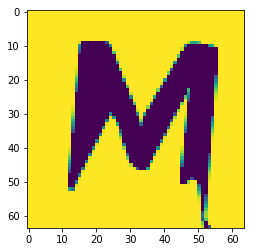

Epoch 0 -0.03456926345825195 0.0003912704414688051
Epoch 1 -0.08340394496917725 0.00047968837316147983
Epoch 2 -0.03456926345825195 0.0005864326958544552
Epoch 3 0.0 0.00039720660424791276
Epoch 4 0.0 0.0003630222927313298
Epoch 5 -0.03456926345825195 0.0004438063479028642
Epoch 6 0.0 0.0005784863024018705
Epoch 7 0.0 0.0005984345334582031
Epoch 8 -0.0017299652099609375 0.0005499936523847282
Epoch 9 -0.0017299652099609375 0.0006444454193115234
Epoch 10 0.0 0.0006070997915230691
Epoch 11 -0.027330994606018066 0.0005386332049965858
Epoch 12 0.008500277996063232 0.0007901288336142898
Epoch 13 -0.003609895706176758 0.0008205321501009166
Epoch 14 0.00697481632232666 0.0009458378772251308
Epoch 15 0.007741034030914307 0.0010434434516355395
Epoch 16 0.007026731967926025 0.0011563105508685112
Epoch 17 0.007581889629364014 0.0011018614750355482
Epoch 18 0.00927954912185669 0.0012167494278401136
Epoch 19 0.011256694793701172 0.0011882279068231583
torch.Size([3, 4]) torch.Size([3, 4]) 6 34
6 0.82

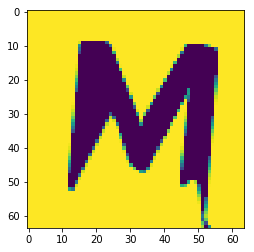

Epoch 0 -0.005491971969604492 0.00042412299080751836
Epoch 1 -0.003529071807861328 0.0006788790924474597
Epoch 2 -0.005491971969604492 0.0004344174521975219
Epoch 3 -0.005337715148925781 0.000757708097808063
Epoch 4 0.004142045974731445 0.0006259912624955177
Epoch 5 0.0038637518882751465 0.0006728324806317687
Epoch 6 -0.05394923686981201 0.0008366353577002883
Epoch 7 0.00368577241897583 0.0009415291133336723
Epoch 8 0.00368577241897583 0.0007658584509044886
Epoch 9 0.00368577241897583 0.0009058061405085027
Epoch 10 0.00368577241897583 0.0010272569488734007
Epoch 11 0.0018960833549499512 0.0011710179969668388
Epoch 12 0.02064669132232666 0.001473833341151476
Epoch 13 0.009696424007415771 0.001491700066253543
Epoch 14 0.0313262939453125 0.0016282135620713234
Epoch 15 0.018317043781280518 0.0018265172839164734
Epoch 16 0.0375216007232666 0.0019552677404135466
Epoch 17 0.008489429950714111 0.002020574174821377
Epoch 18 0.008489429950714111 0.0021090013906359673
Epoch 19 0.04811573028564453

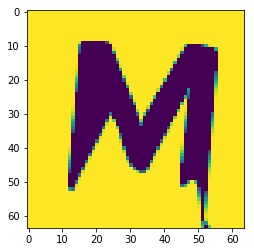

Epoch 0 -0.003777623176574707 0.0004155298229306936
Epoch 1 -0.03418314456939697 0.0006710148300044239
Epoch 2 -0.02417147159576416 0.0006648716516792774
Epoch 3 -0.00023853778839111328 0.0007254082011058927
Epoch 4 -0.03418314456939697 0.000873795710504055
Epoch 5 -0.02417147159576416 0.0007746777264401317
Epoch 6 -0.03418314456939697 0.0008641890017315745
Epoch 7 -0.02356743812561035 0.0009876075200736523
Epoch 8 4.106760025024414e-05 0.0010578199289739132
Epoch 9 4.106760025024414e-05 0.0010671227937564254
Epoch 10 -0.013786792755126953 0.0012182663194835186
Epoch 11 4.106760025024414e-05 0.001305588986724615
Epoch 12 4.106760025024414e-05 0.0013953916495665908
Epoch 13 0.002243220806121826 0.0013727260520681739
Epoch 14 0.002243220806121826 0.0013494337908923626
Epoch 15 -0.0069075822830200195 0.0013505036476999521
Epoch 16 -0.004893064498901367 0.0012512938119471073
Epoch 17 -0.004893064498901367 0.0011802311055362225
Epoch 18 -0.03389310836791992 0.0010987387504428625
Epoch 19 0.

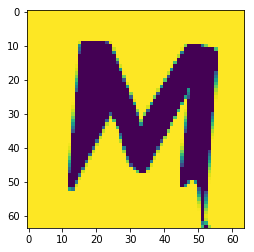

Epoch 0 -0.03809690475463867 0.00026176622486673295
Epoch 1 -0.10218703746795654 0.00033595762215554714
Epoch 2 -0.04105818271636963 0.0004480190691538155
Epoch 3 -0.004105567932128906 0.0005034759524278343
Epoch 4 -0.004105567932128906 0.0005174885736778378
Epoch 5 -0.004105567932128906 0.0006071152747608721
Epoch 6 -0.04352211952209473 0.0006319672102108598
Epoch 7 -0.004685044288635254 0.000785064126830548
Epoch 8 -0.004517793655395508 0.0007381114992313087
Epoch 9 -0.004517793655395508 0.0007423751521855593
Epoch 10 -0.004685044288635254 0.0009153271093964577
Epoch 11 -0.0039261579513549805 0.0009705115808174014
Epoch 12 -0.0038597583770751953 0.0010762372985482216
Epoch 13 -0.0039261579513549805 0.001081755617633462
Epoch 14 -0.004381418228149414 0.0011358556803315878
Epoch 15 -0.004381418228149414 0.0008646484347991645
Epoch 16 -0.004520297050476074 0.0009035597322508693
Epoch 17 -0.004517793655395508 0.0008799011702649295
Epoch 18 -0.004685044288635254 0.0009090417879633605
Epoc

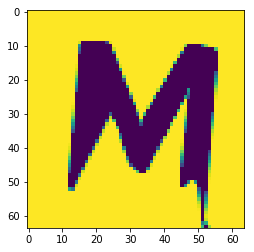

Epoch 0 -0.0003179311752319336 0.0002387580316280946
Epoch 1 -0.0003179311752319336 0.00036145519698038697
Epoch 2 0.00043767690658569336 0.0004025413072668016
Epoch 3 0.0005567669868469238 0.0004357835277915001
Epoch 4 -0.0003179311752319336 0.0005424206028692424
Epoch 5 -0.0003179311752319336 0.0006123678758740425
Epoch 6 -0.021004676818847656 0.0006419412675313652
Epoch 7 -0.021123886108398438 0.0007068958948366344
Epoch 8 -0.0003179311752319336 0.0006162021891213953
Epoch 9 -0.0003179311752319336 0.0008288288372568786
Epoch 10 -0.0004781484603881836 0.000921239610761404
Epoch 11 -0.0003179311752319336 0.0008290950208902359
Epoch 12 -0.008487343788146973 0.000748566584661603
Epoch 13 -0.008257389068603516 0.0008007920696400106
Epoch 14 -0.008383631706237793 0.0007773461984470487
Epoch 15 2.658367156982422e-05 0.0007290731882676482
Epoch 16 2.658367156982422e-05 0.0008240902679972351
Epoch 17 -0.008410215377807617 0.0008593634702265263
Epoch 18 -0.008410215377807617 0.000977585092186

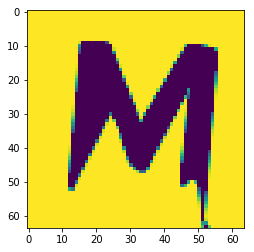

Epoch 0 -0.001816391944885254 0.000343585095833987
Epoch 1 0.0 0.00044931922457180917
Epoch 2 0.0 0.00033831445034593344
Epoch 3 0.0 0.0005334262968972325
Epoch 4 0.0 0.0005695028230547905
Epoch 5 0.00011926889419555664 0.0006578931352123618
Epoch 6 -0.005279064178466797 0.0007096931803971529
Epoch 7 0.00011926889419555664 0.0007436483865603805
Epoch 8 -0.024720072746276855 0.000887736096046865
Epoch 9 -0.024720072746276855 0.0009256203193217516
Epoch 10 -0.003906369209289551 0.0010828657541424036
Epoch 11 -0.030487656593322754 0.0012948343064635992
Epoch 12 -0.09017026424407959 0.0013398489682003856
Epoch 13 -0.004949331283569336 0.0014158360427245498
Epoch 14 -0.03775978088378906 0.0013964844401925802
Epoch 15 -0.03680241107940674 0.001301249605603516
Epoch 16 -0.03775978088378906 0.0012130322866141796
Epoch 17 -0.0005993843078613281 0.0012815592344850302
Epoch 18 -0.0037213563919067383 0.0013932052534073591
Epoch 19 -0.0037213563919067383 0.0013203343842178583
torch.Size([3, 4]) tor

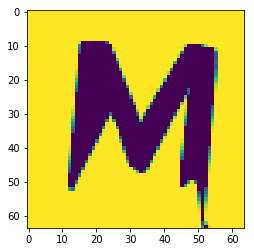

Epoch 0 0.0017910599708557129 0.0002867546572815627
Epoch 1 0.0017910599708557129 0.00044188619358465075
Epoch 2 0.0017910599708557129 0.00045569491339847445
Epoch 3 -0.0017840862274169922 0.000597440346609801
Epoch 4 0.0019288063049316406 0.0005512843490578234
Epoch 5 0.0037633180618286133 0.0005443992558866739
Epoch 6 0.002501845359802246 0.0005313560832291842
Epoch 7 0.0026394128799438477 0.0006720574456267059
Epoch 8 0.002501845359802246 0.0006626052781939507
Epoch 9 0.007291257381439209 0.0007377061992883682
Epoch 10 0.007291257381439209 0.0006757277878932655
Epoch 11 0.0032216310501098633 0.0006239517242647707
Epoch 12 0.005723237991333008 0.0007223376887850463
Epoch 13 0.005583584308624268 0.000819444889202714
Epoch 14 -0.026768922805786133 0.0010326937772333622
Epoch 15 -0.024599432945251465 0.0011413905303925276
Epoch 16 -0.0337597131729126 0.0011015844065696
Epoch 17 -0.0337597131729126 0.0011665265774354339
Epoch 18 0.004009127616882324 0.0011407386045902967
Epoch 19 -0.0337

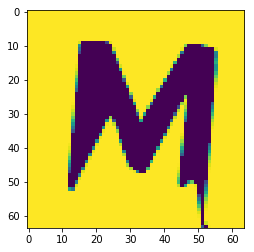

Epoch 0 0.02681124210357666 0.0004168445011600852
Epoch 1 0.027145802974700928 0.0003818906261585653
Epoch 2 0.027145802974700928 0.00041979909292422235
Epoch 3 0.03197038173675537 0.000514499144628644
Epoch 4 0.03197038173675537 0.0006589362747035921
Epoch 5 0.03197038173675537 0.0006813675863668323
Epoch 6 0.032167792320251465 0.0006146181840449572
Epoch 7 0.03691774606704712 0.0005985990865156054
Epoch 8 0.03675103187561035 0.0007024813676252961
Epoch 9 0.03656738996505737 0.000741691910661757
Epoch 10 0.03675103187561035 0.0007844984065741301
Epoch 11 0.03623002767562866 0.0007884844089858234
Epoch 12 0.03223073482513428 0.0009568732930347323
Epoch 13 0.02842128276824951 0.0010894237784668803
Epoch 14 0.025315403938293457 0.0010571186430752277
Epoch 15 0.005803048610687256 0.0010930709540843964
Epoch 16 0.03853809833526611 0.001049522077664733
Epoch 17 0.010844707489013672 0.0011443628463894129
Epoch 18 0.010335803031921387 0.0011359334457665682
Epoch 19 0.03896307945251465 0.00116

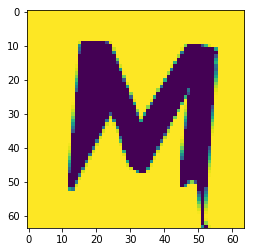

Epoch 0 -0.0005464553833007812 0.00017648492939770222
Epoch 1 -0.026584506034851074 0.00041987557779066265
Epoch 2 -0.032590508460998535 0.0005027860170230269
Epoch 3 -0.00044214725494384766 0.0006373796495608985
Epoch 4 -0.00044214725494384766 0.0007331524975597858
Epoch 5 -0.0035756826400756836 0.0009854859672486782
Epoch 6 -0.0035756826400756836 0.0009676315821707249
Epoch 7 0.004509866237640381 0.0011223690817132592
Epoch 8 0.003531038761138916 0.001260120770893991
Epoch 9 0.0030134916305541992 0.0012178278993815184
Epoch 10 -0.007387042045593262 0.001412251964211464
Epoch 11 0.005488038063049316 0.0013008395908400416
Epoch 12 0.005488038063049316 0.0012238584458827972
Epoch 13 0.005488038063049316 0.0013155767228454351
Epoch 14 0.005488038063049316 0.0013841213658452034
Epoch 15 0.005488038063049316 0.0013558671344071627
Epoch 16 0.005488038063049316 0.0012974103447049856
Epoch 17 0.005488038063049316 0.001327409758232534
Epoch 18 0.005488038063049316 0.0012845371384173632
Epoch 1

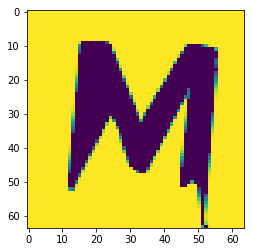

Epoch 0 -0.017281651496887207 0.00033876183442771435
Epoch 1 0.011288225650787354 0.0005735335871577263
Epoch 2 0.011288225650787354 0.0006790757179260254
Epoch 3 0.024461805820465088 0.0006275071646086872
Epoch 4 0.02158069610595703 0.0006978848250582814
Epoch 5 0.024461805820465088 0.0007526598637923598
Epoch 6 0.024461805820465088 0.0006726931314915419
Epoch 7 0.016536056995391846 0.0007306898478418589
Epoch 8 0.011111140251159668 0.0007329769432544708
Epoch 9 0.016536056995391846 0.0007331307861022651
Epoch 10 0.014142990112304688 0.0006869608769193292
Epoch 11 0.024461805820465088 0.0007603203412145376
Epoch 12 0.009433865547180176 0.0008335473830811679
Epoch 13 0.024461805820465088 0.0008084484725259244
Epoch 14 0.028225958347320557 0.0009843824664130807
Epoch 15 0.028225958347320557 0.0009519673767499626
Epoch 16 0.009620189666748047 0.0010256485547870398
Epoch 17 -0.01657712459564209 0.001091905403882265
Epoch 18 0.028395473957061768 0.001209366018883884
Epoch 19 0.009815096855

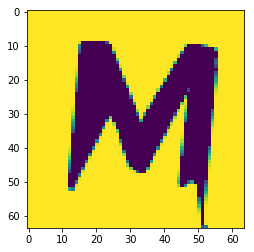

Epoch 0 0.0 0.00026504124980419874
Epoch 1 0.0077173709869384766 0.00034306090674363077
Epoch 2 0.006664395332336426 0.00045101268915459514
Epoch 3 0.020451247692108154 0.0005107087781652808
Epoch 4 0.006664395332336426 0.0006101664621382952
Epoch 5 0.0 0.0006875639664940536
Epoch 6 0.020451247692108154 0.0008568327175453305
Epoch 7 0.006664395332336426 0.0008127117762342095
Epoch 8 0.006664395332336426 0.0007025571539998055
Epoch 9 0.006664395332336426 0.0006963943014852703
Epoch 10 0.020451247692108154 0.0007987241260707378
Epoch 11 0.020125508308410645 0.0007994691841304302
Epoch 12 0.020125508308410645 0.0008817650377750397
Epoch 13 0.019741535186767578 0.0008890260360203683
Epoch 14 0.019741535186767578 0.000735160312615335
Epoch 15 0.020125508308410645 0.0008547228644602001
Epoch 16 0.020125508308410645 0.0008345383103005588
Epoch 17 0.0009145140647888184 0.0008161570876836777
Epoch 18 0.009336650371551514 0.0008424270781688392
Epoch 19 0.020451247692108154 0.0007468605763278902


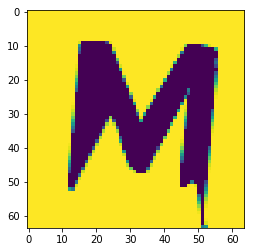

Epoch 0 -0.009548425674438477 0.00037698354572057724
Epoch 1 -0.0002747774124145508 0.00040604834794066846
Epoch 2 0.0 0.0004796970752067864
Epoch 3 -0.01994466781616211 0.0006615429883822799
Epoch 4 0.0 0.0006076765712350607
Epoch 5 0.0 0.00039130248478613794
Epoch 6 -0.008365273475646973 0.00037470131064765155
Epoch 7 -0.01407468318939209 0.00044320663437247276
Epoch 8 0.0 0.0005750638665631413
Epoch 9 0.0 0.0005313581204973161
Epoch 10 0.0 0.0005694243591278791
Epoch 11 0.0 0.0007303449674509466
Epoch 12 0.0 0.0006655526231043041
Epoch 13 0.0 0.000673274218570441
Epoch 14 0.0 0.0006221786607056856
Epoch 15 -0.0003324747085571289 0.0006927205249667168
Epoch 16 -0.0003324747085571289 0.000612262636423111
Epoch 17 -0.01407468318939209 0.0006467145285569131
Epoch 18 -0.009548425674438477 0.0006513734115287662
Epoch 19 -0.0003324747085571289 0.0006180062191560864
torch.Size([3, 4]) torch.Size([3, 4]) 17 34
17 0.8411213159561157 0.43363380432128906


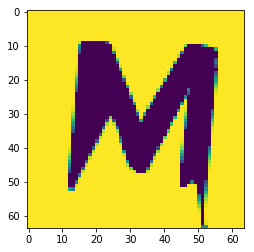

Epoch 0 -0.012049198150634766 0.0003041916061192751
Epoch 1 -0.012049198150634766 0.0004599879903253168
Epoch 2 -0.011779427528381348 0.0005915842484682798
Epoch 3 -0.0382997989654541 0.0006134659051895142
Epoch 4 -0.033132314682006836 0.0007591659668833017
Epoch 5 -0.033132314682006836 0.0006982641061767936
Epoch 6 -8.952617645263672e-05 0.0009626786923035979
Epoch 7 -8.952617645263672e-05 0.000977108022198081
Epoch 8 -8.952617645263672e-05 0.0008320621564052999
Epoch 9 -8.952617645263672e-05 0.0008194714318960905
Epoch 10 -8.952617645263672e-05 0.0009021158330142498
Epoch 11 -8.952617645263672e-05 0.001059780828654766
Epoch 12 0.0 0.0010033033322542906
Epoch 13 0.0 0.0010256809182465076
Epoch 14 -8.952617645263672e-05 0.001161503023467958
Epoch 15 -0.011779427528381348 0.001182792242616415
Epoch 16 -8.952617645263672e-05 0.0012074564583599567
Epoch 17 -0.011779427528381348 0.001337640336714685
Epoch 18 -0.01099097728729248 0.0014844448305666447
Epoch 19 -0.011779427528381348 0.001333

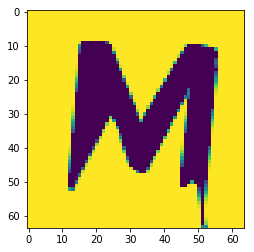

Epoch 0 0.011553823947906494 0.00025262607960030437
Epoch 1 -0.007792115211486816 0.00041154370410367846
Epoch 2 0.011553823947906494 0.00045086530735716224
Epoch 3 0.01164233684539795 0.0006767328595742583
Epoch 4 -0.0022639036178588867 0.0008033103076741099
Epoch 5 0.01164233684539795 0.0006922596949152648
Epoch 6 0.01164233684539795 0.0005601045559160411
Epoch 7 0.0007792115211486816 0.0006761291297152638
Epoch 8 0.01164233684539795 0.0006615824531763792
Epoch 9 0.01164233684539795 0.0006993852439336479
Epoch 10 -0.00026667118072509766 0.0007281004218384624
Epoch 11 0.0007792115211486816 0.0007367684738710523
Epoch 12 0.01164233684539795 0.0009232197771780193
Epoch 13 -0.02621161937713623 0.0008806490222923458
Epoch 14 0.01164233684539795 0.0009302310645580292
Epoch 15 0.01164233684539795 0.000993622001260519
Epoch 16 -0.007792115211486816 0.0011114375665783882
Epoch 17 -0.007792115211486816 0.0010612125042825937
Epoch 18 -0.0022639036178588867 0.0010997614590451121
Epoch 19 -0.0022

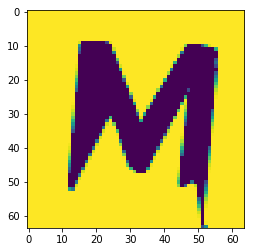

Epoch 0 0.013874828815460205 0.0003428962954785675
Epoch 1 0.013874828815460205 0.0004469979030545801
Epoch 2 0.0 0.00044878837070427835
Epoch 3 0.013874828815460205 0.0004978240467607975
Epoch 4 0.0 0.0003448805946391076
Epoch 5 0.013874828815460205 0.0005605800542980433
Epoch 6 0.013874828815460205 0.000551072065718472
Epoch 7 0.013874828815460205 0.0006585196824744344
Epoch 8 0.013874828815460205 0.0007755656260997057
Epoch 9 0.013874828815460205 0.0006903099128976464
Epoch 10 0.013786494731903076 0.0006926321657374501
Epoch 11 0.013786494731903076 0.0005795854958705604
Epoch 12 0.013874828815460205 0.0005603663739748299
Epoch 13 0.013874828815460205 0.0005520936101675034
Epoch 14 0.0 0.0004954074393026531
Epoch 15 0.0 0.00043285934953019023
Epoch 16 0.0 0.00044013449223712087
Epoch 17 0.0 0.0005744604859501123
Epoch 18 -0.005515694618225098 0.0007382619078271091
Epoch 19 0.002258777618408203 0.0007943272357806563
torch.Size([3, 4]) torch.Size([3, 4]) 20 34
20 0.8392497897148132 0.4

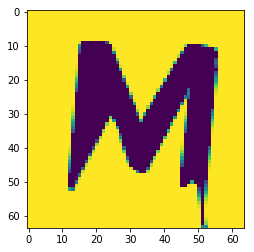

Epoch 0 0.011553823947906494 0.00032514327904209495
Epoch 1 -0.00040018558502197266 0.0002193423279095441
Epoch 2 -0.00040018558502197266 0.00047383946366608143
Epoch 3 0.01164233684539795 0.0006489398656412959
Epoch 4 0.01164233684539795 0.0007299676071852446
Epoch 5 -0.0006669759750366211 0.0010283803567290306
Epoch 6 -0.028567194938659668 0.0010516491020098329
Epoch 7 0.0022083520889282227 0.0010501662036404014
Epoch 8 -0.028567194938659668 0.0010832868283614516
Epoch 9 0.0004201531410217285 0.001134320511482656
Epoch 10 0.004151046276092529 0.0013461958151310682
Epoch 11 -0.00851595401763916 0.0013649010797962546
Epoch 12 -0.00851595401763916 0.001479234779253602
Epoch 13 -0.0006015300750732422 0.0014367324765771627
Epoch 14 -0.00851595401763916 0.0012801744742318988
Epoch 15 -0.00851595401763916 0.0013363774633035064
Epoch 16 0.002711176872253418 0.0015333284391090274
Epoch 17 -0.00851595401763916 0.0014961970737203956
Epoch 18 0.002711176872253418 0.0014961098786443472
Epoch 19 0

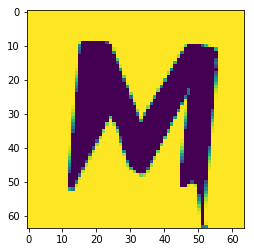

Epoch 0 0.00010919570922851562 0.00020424785907380283
Epoch 1 0.00023239850997924805 0.00042223132913932204
Epoch 2 -0.004403114318847656 0.00066681660246104
Epoch 3 -0.004403114318847656 0.0007189243915490806
Epoch 4 -0.004403114318847656 0.0006913428078405559
Epoch 5 -0.003937244415283203 0.0007114126347005367
Epoch 6 -0.020021557807922363 0.0008836735505610704
Epoch 7 -0.0011527538299560547 0.0008314362494274974
Epoch 8 0.008292913436889648 0.0005789304850623012
Epoch 9 0.004203140735626221 0.000874820165336132
Epoch 10 -0.001644730567932129 0.0009820846607908607
Epoch 11 0.0028306245803833008 0.0008894732454791665
Epoch 12 -0.001644730567932129 0.0009815391385927796
Epoch 13 0.0028306245803833008 0.0010432646377012134
Epoch 14 -0.001644730567932129 0.0010894088773056865
Epoch 15 0.005179643630981445 0.001116920611821115
Epoch 16 -0.002606987953186035 0.001142749097198248
Epoch 17 0.0016804933547973633 0.0011219113366678357
Epoch 18 0.0016804933547973633 0.0011692694388329983
Epoch 

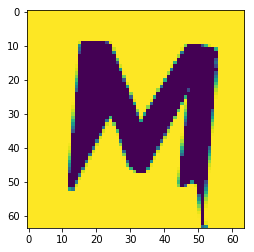

In [ ]:
# target_features = feature_encoder(targets[[0]])
# pen = start_state_pens[0].clone()
# l = torch.nonzero(start_state_tools[0] == 9)[0].item()
# print(f"Length: {l}")
# state = start_state[0,0]
# init_mse, init_mse_feature = F.mse_loss(state,targets[0]), F.mse_loss(feature_encoder(state[None,None]),target_features)
# state_history = [state]

for pass_num in range(10):
    #mse_balance = 0.5 + 0.5*min(1.0,pass_num/10)
    mse_balance = 1.0
    print(f"Pass {pass_num}")
    for i in range(1,l):
        #tl = len(tool_dict[data.vocab[start_state_tools[0][i]]])
        #if tl == 0: continue
        ks = 3
        adj = torch.zeros(ks,4).cuda()#.normal_(0.0,0.03)
        npop = 32
        base_sigma = 3 #/ np.power(3,pass_num)
        lr = 1e-3
        base_mse, base_mse_feature = F.mse_loss(state,targets[0]) , F.mse_loss(feature_encoder(state[None,None]),target_features)
        best_mse = 0.0
        prev_skip = False
        sigma = base_sigma
        for epoch in range(20):
#             if prev_skip:
#                 sigma = sigma * 1.2
#             else:
#                 sigma = max(sigma / 1.2,0.005)
            N = torch.randn(npop,ks,4).cuda()
            R = torch.zeros(npop).cuda()
            for j in range(npop):
                w_try = adj + sigma*N[j]*0.002
                b,f,_ = eval_pen_kernel(w_try,tool=i,tools=start_state_tools[0],pen=pen,target=targets[0],target_features=target_features,l=l,ks=ks)
                b = b / base_mse
                f = f / base_mse_feature
                R[j] = 1.0 - (mse_balance*b+(1-mse_balance)*f)
            A = (R - R.mean()) / (R.std() + 1e-6)
            old_adj = adj
            N = N.view(npop,-1)
            d = (1/(npop))*torch.mm(N.transpose(0,1),A.unsqueeze(1)).view(ks,4)
            adj = adj + d*0.002
            #print(adj/0.002)
            #adj = adj + (lr/(npop*sigma))*torch.mm(N.transpose(0,1),A.unsqueeze(1)).view(ks,4)
            b,f,_ = eval_pen_kernel(adj,tool=i,tools=start_state_tools[0],pen=pen,target=targets[0],target_features=target_features,l=l,ks=ks)
            b = b / base_mse
            f = f / base_mse_feature
            mse = 1.0 - (mse_balance*b+(1-mse_balance)*f)
#             if mse <= best_mse:
#                 adj = old_adj
#                 prev_skip = True
#                 continue
#             else:
#                 prev_skip = False
#                 best_mse = mse
            print(f"Epoch {epoch} {mse} {adj.abs().mean().item()}")
        mse_b,mse_f,state = eval_pen_kernel(adj,tool=i,tools=start_state_tools[0],pen=pen,target=targets[0],target_features=target_features,l=l,ks=ks)
        mse_b = mse_b / init_mse
        mse_f = mse_f / init_mse_feature
        state_history.append(state.detach().cpu())

        if i - ks//2 < 0:
            adj= adj[(ks//2) - i:]
        elif i + ks//2 >= l:
            adj = adj[:ks//2+(l-i)]
        print(adj.shape,pen[max(i-ks//2,0):min(i+ks//2+1,l)].shape,i,l)
        pen[max(i-ks//2,0):min(i+ks//2+1,l)] += adj
        mse = 1.0 - (mse_balance*mse_b + (1-mse_balance)*mse_f)
        print(f"{i} {1.0 - mse_b} {1.0 - mse_f}")
        plt.imshow(state)
        plt.show()

In [69]:
len(state_history)

115

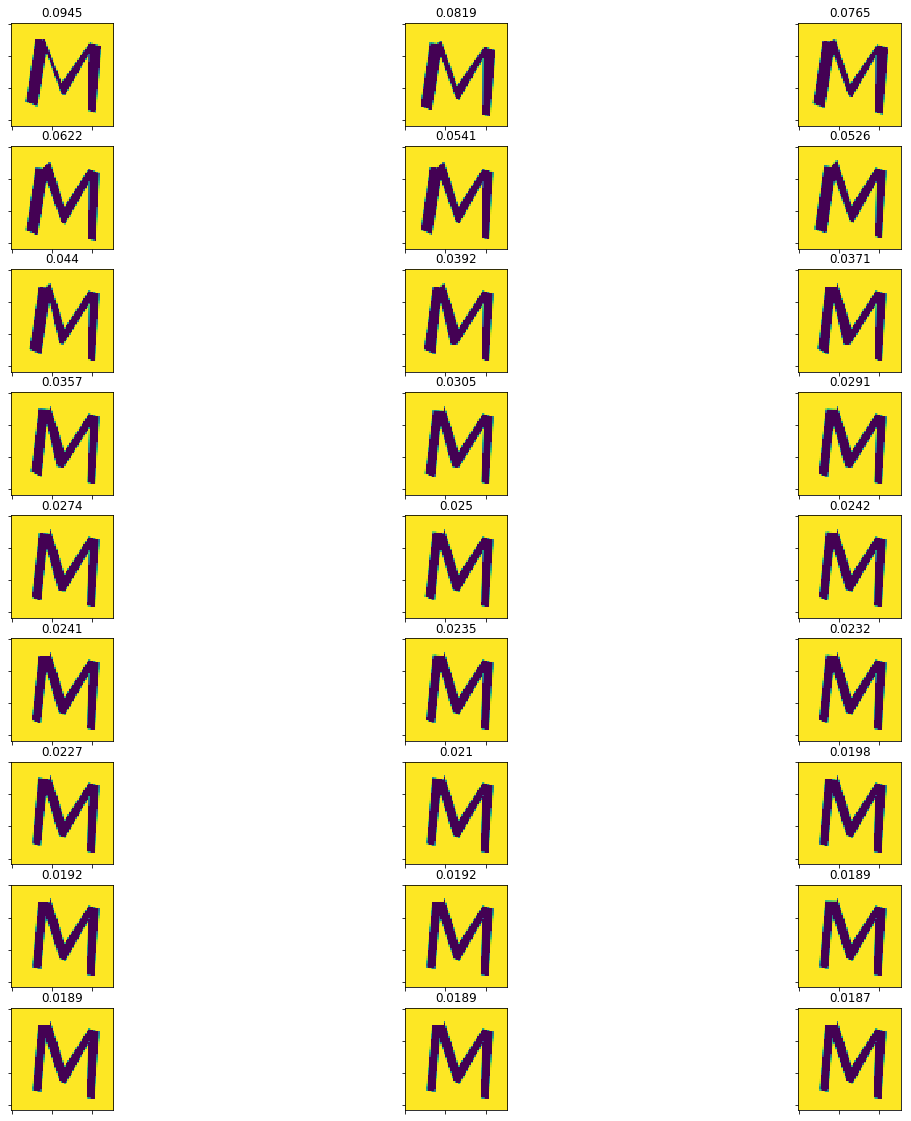

In [70]:
fig,axes = plt.subplots(9,3,figsize=(20,20))
for i,ax in enumerate(axes.flatten()):
    mse = F.mse_loss(state_history[i*3].cuda(),targets[0]).item()
    ax.set_title(f"{np.round(mse,4)}")
    ax.tick_params(labelbottom=False,labelleft=False) 
    ax.imshow(state_history[i*3].squeeze(0))

In [210]:
adj = torch.zeros(4).cuda()#.normal_(0.0,0.03)
npop = 32
sigma = 0.01
lr = 1e-3
base_mse = F.mse_loss(start_state[0],targets[0])
best_mse = 0.0
for epoch in range(10):
    N = torch.randn(npop,4).cuda()
    R = torch.zeros(npop).cuda()
    for j in range(npop):
        w_try = 0.05*torch.tanh(adj + sigma*N[j])
        R[j] = 1.0 - (eval_pen(w_try,tool=1,tools=start_state_tools[0],pen=start_state_pens[0],target=targets[0]) / base_mse)
    A = (R - R.mean()) / R.std()
    old_adj = adj
    adj = adj + (lr/(npop*sigma))*torch.mm(N.transpose(0,1),A.unsqueeze(1)).squeeze(-1)
    mse = 1.0 - (eval_pen(0.05*torch.tanh(adj),tool=1,tools=start_state_tools[0],pen=start_state_pens[0],target=targets[0]) / base_mse)
    if mse < best_mse:
        adj = old_adj
        continue
    else:
        best_mse = mse
    print(adj)
    if epoch % 1 == 0: print(f"Epoch {epoch} {mse}")

tensor([-0.0706, -0.0385,  0.0096,  0.0321], device='cuda:0')
Epoch 0 0.25620442628860474
tensor([-0.1407, -0.0265, -0.0208,  0.0197], device='cuda:0')
Epoch 1 0.3615841269493103
tensor([-0.1382, -0.0694, -0.0179,  0.0095], device='cuda:0')
Epoch 2 0.42491990327835083
tensor([-0.1950, -0.0535, -0.0094,  0.0314], device='cuda:0')
Epoch 3 0.43687665462493896
tensor([-0.2225, -0.1066, -0.0171,  0.0483], device='cuda:0')
Epoch 4 0.5162799954414368
tensor([-0.2163, -0.1409, -0.0111,  0.0394], device='cuda:0')
Epoch 5 0.5576333403587341
tensor([-0.2345, -0.1849, -0.0269,  0.0265], device='cuda:0')
Epoch 6 0.5833011865615845
tensor([-0.2311, -0.2340, -0.0333,  0.0250], device='cuda:0')
Epoch 7 0.6061954498291016
tensor([-0.2288, -0.2744, -0.0457,  0.0366], device='cuda:0')
Epoch 8 0.63477623462677


In [189]:
class AdjMod(nn.Module):
    def __init__(self):
        super().__init__()
        self.mean = nn.Parameter(torch.zeros(4).cuda().normal_(0.0,0.003))
        self.std = nn.Parameter(torch.zeros(4).cuda().normal_(0.0,0.003))
        
adj = AdjMod()
opt_adj = torch.optim.SGD(adj.parameters(),5e-5)
init_mse = F.mse_loss(start_state[0],targets[0])

for epoch in range(1000):
    dist = torch.distributions.Normal(0.05*torch.tanh(adj.mean),0.02*torch.sigmoid(adj.std))
    s = dist.sample()
    mse = eval_pen(s,tool=1,tools=start_state_tools[0],pen=start_state_pens[0],target=targets[0])
    mse = 1.0 - (mse / init_mse)
    log_prob = dist.log_prob(s)
    loss = -log_prob * mse
    loss = loss[:2].mean()
    opt_adj.zero_grad()
    loss.backward()
    #print(adj.std)
    opt_adj.step()
#     for p in adj.parameters():
#         p.data.add_(-5e-4*p.grad)
    #adj.std.data.clamp_(1e-5,0.02)
    #adj.mean.data.clamp_(-0.05,0.05)
    mse_mean = eval_pen(adj.mean.data,tool=1,tools=start_state_tools[0],pen=start_state_pens[0],target=targets[0])
    mse_mean = 1.0 - (mse_mean / init_mse)
    if epoch % 20 == 0: print(f"Epoch {epoch} {mse} {mse_mean} {loss.item()} {adj.mean.data.detach().cpu().numpy()} {adj.std.data.detach().cpu().numpy()}")

Epoch 0 -0.0971829891204834 -0.11905980110168457 0.22362446784973145 [ 0.002538 -0.000127 -0.004067  0.000927] [-0.001534  0.00297   0.005304  0.001486]
Epoch 20 -0.6482799053192139 0.07598596811294556 2.1625702381134033 [ 0.001694 -0.001211 -0.004067  0.000927] [-0.001493  0.002834  0.005304  0.001486]
Epoch 40 -0.5266410112380981 0.07598596811294556 1.8590443134307861 [ 0.000685 -0.001703 -0.004067  0.000927] [-0.00163   0.002689  0.005304  0.001486]
Epoch 60 0.5131700038909912 0.07598596811294556 -1.5105366706848145 [ 0.000283 -0.002239 -0.004067  0.000927] [-0.001654  0.002683  0.005304  0.001486]
Epoch 80 0.252521812915802 0.17523348331451416 -0.8416745662689209 [-0.000807 -0.002317 -0.004067  0.000927] [-0.001867  0.002713  0.005304  0.001486]
Epoch 100 -0.0880054235458374 0.2504045367240906 0.3071601986885071 [-0.001586 -0.003012 -0.004067  0.000927] [-0.0019    0.002668  0.005304  0.001486]
Epoch 120 0.5756377577781677 0.324782133102417 -1.461417317390442 [-0.002336 -0.003651 -

KeyboardInterrupt: 

In [125]:
pen = start_state_pens[0].clone()
l = torch.argmax(start_state_tools[0] == 9).item()
init_mse = F.mse_loss(start_state[0],targets[0])
print(f"init mse: {init_mse.item()}")
for i in range(l-1,0,-1):
    f = partial(eval_pen,tool=i,tools=start_state_tools[0],pen=pen,target=targets[0])
    tl = len(tool_dict[data.vocab[start_state_tools[0][i]]])
    if tl == 0: continue
    ranges = [(-0.045,0.045)] * tl
    res = gp_minimize(f,ranges,acq_func="EI",n_calls=100,n_random_starts=25)
    if res.fun > init_mse: continue
    init_mse = res.fun
    print(f"{i} {res.fun}")
    r = torch.tensor(res.x_iters[-1]).cuda()
    pen[i,:r.shape[0]] += r

init mse: 0.01977711170911789
6 0.01866341196000576
3 0.01568601466715336


Epoch 0: actor_real: -2.7615313627897677 actor_l: 0.16721633076667786 critic_l: 0.11050960421562195 reward: -0.7786890268325806 avg_reward: -0.07717651128768921 std_reward: 0.39068251848220825 avg_value: 0.3461968004703522 return: 0.17627544701099396 
mse: 1.0771764516830444 alp: 0.1833040714263916 deltas: 0.008025158196687698 mu: 0.0006105444044806063 sigma: 0.00991161447018385


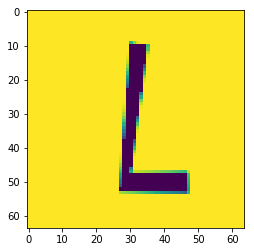

Epoch 1: actor_real: -2.7661054180709015 actor_l: -0.03661874681711197 critic_l: 0.08937074989080429 reward: 0.01030576229095459 avg_reward: -0.05077321082353592 std_reward: 0.3366203010082245 avg_value: -0.054602500051259995 return: -0.05627461522817612 
mse: 1.0507732629776 alp: 0.18331411480903625 deltas: 0.008394654840230942 mu: 0.0007310393848456442 sigma: 0.009906729683279991


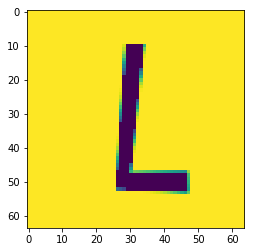

Epoch 2: actor_real: -2.7894591559501514 actor_l: 0.025900714099407196 critic_l: 0.1452624797821045 reward: 0.13901525735855103 avg_reward: -0.10320309549570084 std_reward: 0.4917212426662445 avg_value: -0.3241282105445862 return: -0.2884855568408966 
mse: 1.1032030582427979 alp: 0.18334892392158508 deltas: 0.007921221666038036 mu: 0.0008559715934097767 sigma: 0.00989227369427681


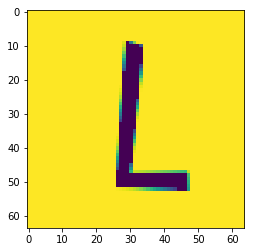

Epoch 3: actor_real: -2.6881190207747534 actor_l: -0.12949901819229126 critic_l: 0.1169186607003212 reward: -0.5638846158981323 avg_reward: -0.012050095945596695 std_reward: 0.38551709055900574 avg_value: -0.4593300521373749 return: -0.3180622458457947 
mse: 1.0120501518249512 alp: 0.1830291599035263 deltas: 0.007601829711347818 mu: 0.00096269475761801 sigma: 0.009883862920105457


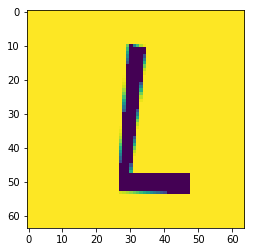

Epoch 4: actor_real: -2.7353149308205618 actor_l: -0.05501597374677658 critic_l: 0.12652666866779327 reward: -0.11133253574371338 avg_reward: 0.010424468666315079 std_reward: 0.384490966796875 avg_value: -0.40107962489128113 return: -0.2694171667098999 
mse: 0.9895755052566528 alp: 0.18414300680160522 deltas: 0.007846691645681858 mu: 0.001103403978049755 sigma: 0.009863034822046757


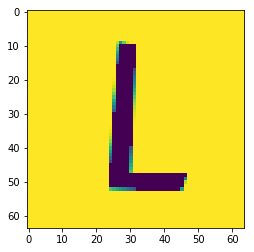

Epoch 5: actor_real: -2.640172864439697 actor_l: -0.04476625472307205 critic_l: 0.09199687838554382 reward: 0.017640233039855957 avg_reward: -0.002611159346997738 std_reward: 0.31656238436698914 avg_value: -0.2585589289665222 return: -0.22290176153182983 
mse: 1.0026111602783203 alp: 0.18235933780670166 deltas: 0.008251314051449299 mu: 0.001412142883054912 sigma: 0.009837910532951355


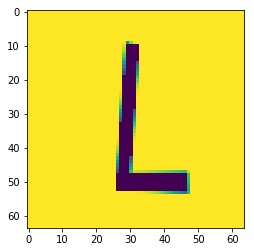

Epoch 6: actor_real: -2.465164125907262 actor_l: -0.08795482665300369 critic_l: 0.10063875466585159 reward: 0.4487155079841614 avg_reward: 0.07544626295566559 std_reward: 0.3090706169605255 avg_value: -0.11593270301818848 return: -0.058061633259058 
mse: 0.9245536923408508 alp: 0.18568482995033264 deltas: 0.009401003830134869 mu: 0.0019039504695683718 sigma: 0.009791801683604717


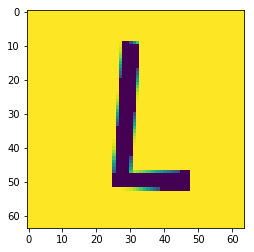

Epoch 7: actor_real: -2.565047054935563 actor_l: -0.060432419180870056 critic_l: 0.06418132781982422 reward: 0.39165759086608887 avg_reward: 0.142105370759964 std_reward: 0.24323131144046783 avg_value: 0.0403856597840786 return: 0.09143958240747452 
mse: 0.8578945994377136 alp: 0.18455618619918823 deltas: 0.00888043362647295 mu: 0.0025199544616043568 sigma: 0.009740674868226051


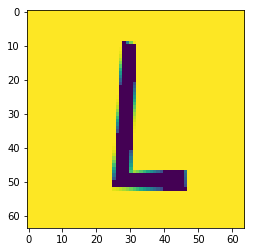

Epoch 8: actor_real: -2.2829585757842663 actor_l: 0.08877984434366226 critic_l: 0.0958123505115509 reward: 0.4442020654678345 avg_reward: 0.1003485769033432 std_reward: 0.29669132828712463 avg_value: 0.20753508806228638 return: 0.14634673297405243 
mse: 0.8996514081954956 alp: 0.18415158987045288 deltas: 0.009478313848376274 mu: 0.003083690069615841 sigma: 0.009679242968559265


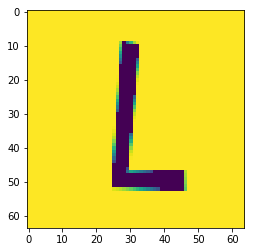

Epoch 9: actor_real: -1.9201615610600873 actor_l: 0.17020367085933685 critic_l: 0.1135692447423935 reward: 0.15003573894500732 avg_reward: 0.05211072042584419 std_reward: 0.31064218282699585 avg_value: 0.30738526582717896 return: 0.1622532308101654 
mse: 0.9478893280029297 alp: 0.1839076578617096 deltas: 0.010269418358802795 mu: 0.003833858296275139 sigma: 0.009587511420249939


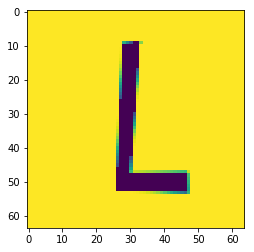

Epoch 10: actor_real: -1.8231661333888283 actor_l: 0.047170963138341904 critic_l: 0.07260001450777054 reward: 0.4783164858818054 avg_reward: 0.16387176513671875 std_reward: 0.25852543115615845 avg_value: 0.30543917417526245 return: 0.25532957911491394 
mse: 0.836128294467926 alp: 0.1876809149980545 deltas: 0.009724757634103298 mu: 0.004100415389984846 sigma: 0.009484095498919487


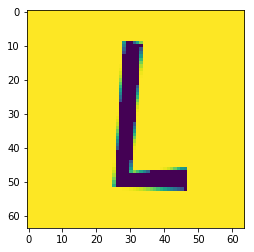

Epoch 11: actor_real: -2.0410485703173626 actor_l: 0.053094327449798584 critic_l: 0.08077952265739441 reward: 0.3716853857040405 avg_reward: 0.15767452120780945 std_reward: 0.23464956879615784 avg_value: 0.27404171228408813 return: 0.21673369407653809 
mse: 0.8423255085945129 alp: 0.18393349647521973 deltas: 0.009940105490386486 mu: 0.004402177408337593 sigma: 0.009399552829563618


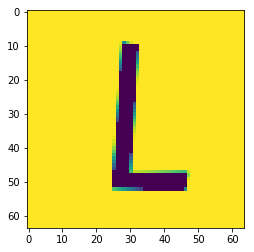

Epoch 12: actor_real: -2.0210254694420127 actor_l: 0.050286710262298584 critic_l: 0.07063336670398712 reward: 0.1794862151145935 avg_reward: 0.09526444971561432 std_reward: 0.2579033672809601 avg_value: 0.21342796087265015 return: 0.1220533475279808 
mse: 0.9047355055809021 alp: 0.18398147821426392 deltas: 0.010903269052505493 mu: 0.005210740491747856 sigma: 0.009276540949940681


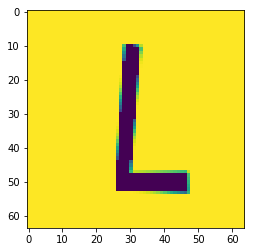

Epoch 13: actor_real: -1.7807412698148843 actor_l: 0.06406882405281067 critic_l: 0.06654289364814758 reward: 0.6184225082397461 avg_reward: 0.09537024050951004 std_reward: 0.214742973446846 avg_value: 0.1121811792254448 return: 0.04760478436946869 
mse: 0.9046297669410706 alp: 0.1851654052734375 deltas: 0.011913194321095943 mu: 0.005900856107473373 sigma: 0.009152628481388092


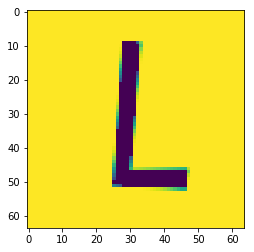

Epoch 14: actor_real: -0.720855923487938 actor_l: 0.03223048150539398 critic_l: 0.05830799415707588 reward: -0.12408328056335449 avg_reward: 0.1321098655462265 std_reward: 0.2106449007987976 avg_value: -0.012155880220234394 return: -0.0042784810066223145 
mse: 0.8678901195526123 alp: 0.1856456696987152 deltas: 0.011013692244887352 mu: 0.006256772205233574 sigma: 0.009052643552422523


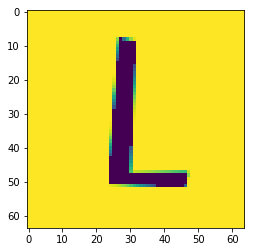

Epoch 15: actor_real: -1.1378444744284422 actor_l: 0.07771458476781845 critic_l: 0.07687653601169586 reward: 0.04930979013442993 avg_reward: 0.07705360651016235 std_reward: 0.27132660150527954 avg_value: -0.1214590072631836 return: -0.15139752626419067 
mse: 0.9229464530944824 alp: 0.1849597841501236 deltas: 0.011694095097482204 mu: 0.006576757878065109 sigma: 0.00897338055074215


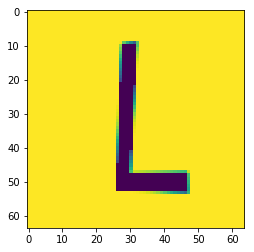

Epoch 16: actor_real: -0.523515489209032 actor_l: 0.010755658149719238 critic_l: 0.08074451237916946 reward: -0.32267653942108154 avg_reward: 0.11714839935302734 std_reward: 0.2509118616580963 avg_value: -0.23726056516170502 return: -0.19734524190425873 
mse: 0.8828516006469727 alp: 0.18437029421329498 deltas: 0.011329270899295807 mu: 0.007028868887573481 sigma: 0.008911926299333572


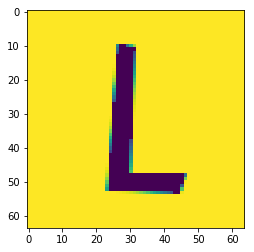

Epoch 17: actor_real: -0.02438240559358952 actor_l: 0.10333985835313797 critic_l: 0.11275315284729004 reward: 0.3970361351966858 avg_reward: -5.325302481651306e-06 std_reward: 0.29146817326545715 avg_value: -0.3178510367870331 return: -0.384870707988739 
mse: 1.0000053644180298 alp: 0.1834155172109604 deltas: 0.012823151424527168 mu: 0.007659719325602055 sigma: 0.008813412860035896


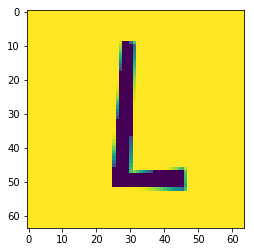

Epoch 18: actor_real: 0.5099783527739598 actor_l: 0.1391811966896057 critic_l: 0.11142978072166443 reward: 0.20667994022369385 avg_reward: -0.033572591841220856 std_reward: 0.2773997485637665 avg_value: -0.42812061309814453 return: -0.5145882368087769 
mse: 1.0335725545883179 alp: 0.18351797759532928 deltas: 0.014917455613613129 mu: 0.00840823631733656 sigma: 0.008714618161320686


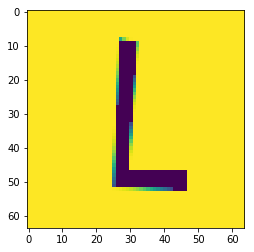

Epoch 19: actor_real: 0.03092650399096039 actor_l: 0.1547044813632965 critic_l: 0.13010726869106293 reward: -0.054387569427490234 avg_reward: -0.037020012736320496 std_reward: 0.3826614320278168 avg_value: -0.574740469455719 return: -0.6406790018081665 
mse: 1.037019968032837 alp: 0.18311035633087158 deltas: 0.014585797674953938 mu: 0.0085467379540205 sigma: 0.008742441423237324


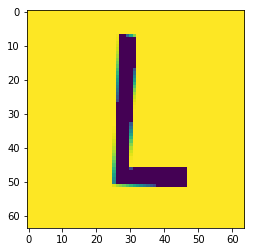

Epoch 20: actor_real: 0.9060345351986034 actor_l: 0.04089232161641121 critic_l: 0.11365803331136703 reward: -0.1035468578338623 avg_reward: 0.003628399223089218 std_reward: 0.31459200382232666 avg_value: -0.7427622675895691 return: -0.7199488282203674 
mse: 0.9963715672492981 alp: 0.18413037061691284 deltas: 0.015568466857075691 mu: 0.009160888381302357 sigma: 0.008709849789738655


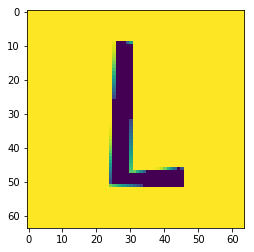

Epoch 21: actor_real: 1.20417550695442 actor_l: 0.1633644700050354 critic_l: 0.12461406737565994 reward: 0.11750102043151855 avg_reward: -0.11441627889871597 std_reward: 0.2908130884170532 avg_value: -0.8857966065406799 return: -0.9596865177154541 
mse: 1.114416241645813 alp: 0.18283642828464508 deltas: 0.016882535070180893 mu: 0.009895220398902893 sigma: 0.00856318324804306


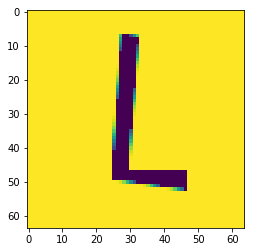

Epoch 22: actor_real: 2.675014498841362 actor_l: 0.3022010922431946 critic_l: 0.1673770546913147 reward: -0.6170309782028198 avg_reward: -0.20299458503723145 std_reward: 0.3693383038043976 avg_value: -1.057373046875 return: -1.1702654361724854 
mse: 1.202994465827942 alp: 0.1824588179588318 deltas: 0.017809471115469933 mu: 0.010770181193947792 sigma: 0.008354881778359413


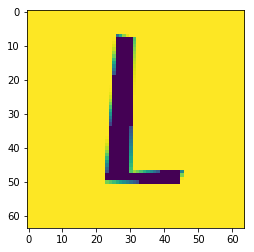

Epoch 23: actor_real: 4.476900793411912 actor_l: 0.017914045602083206 critic_l: 0.13751935958862305 reward: -0.02854776382446289 avg_reward: -0.12262926995754242 std_reward: 0.33417320251464844 avg_value: -1.2612298727035522 return: -1.2563855648040771 
mse: 1.1226292848587036 alp: 0.1854478120803833 deltas: 0.018763041123747826 mu: 0.011672144755721092 sigma: 0.008129183202981949


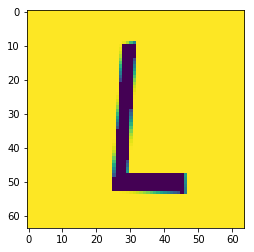

Epoch 24: actor_real: 8.581502240696123 actor_l: 0.14229795336723328 critic_l: 0.16843432188034058 reward: -0.44265997409820557 avg_reward: -0.2631714344024658 std_reward: 0.3383074402809143 avg_value: -1.4440099000930786 return: -1.5502982139587402 
mse: 1.2631714344024658 alp: 0.18606826663017273 deltas: 0.02048688568174839 mu: 0.012628169730305672 sigma: 0.00787242129445076


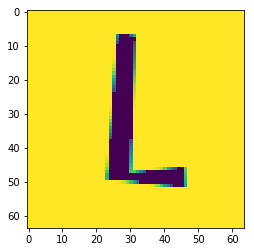

Epoch 25: actor_real: 7.435662578857324 actor_l: 0.27771538496017456 critic_l: 0.1900789439678192 reward: -0.7252041101455688 avg_reward: -0.27994534373283386 std_reward: 0.37006616592407227 avg_value: -1.6545920372009277 return: -1.7568254470825195 
mse: 1.2799453735351562 alp: 0.18851864337921143 deltas: 0.022300709038972855 mu: 0.013558298349380493 sigma: 0.007639388553798199


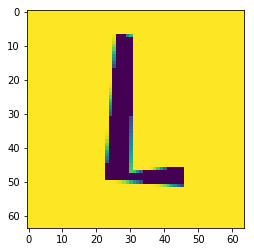

Epoch 26: actor_real: 17.31263225652412 actor_l: 0.21057426929473877 critic_l: 0.18372243642807007 reward: -0.1775679588317871 avg_reward: -0.2669314742088318 std_reward: 0.3615434765815735 avg_value: -1.887374997138977 return: -1.9300880432128906 
mse: 1.2669312953948975 alp: 0.19956235587596893 deltas: 0.02214501053094864 mu: 0.013928227126598358 sigma: 0.007428611628711224


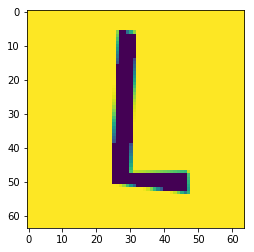

Epoch 27: actor_real: 23.82461184386118 actor_l: 0.12041780352592468 critic_l: 0.18770486116409302 reward: -0.14751577377319336 avg_reward: -0.31416791677474976 std_reward: 0.3478022813796997 avg_value: -2.1130902767181396 return: -2.1547720432281494 
mse: 1.3141679763793945 alp: 0.20564453303813934 deltas: 0.02277931571006775 mu: 0.014618998393416405 sigma: 0.007170273456722498


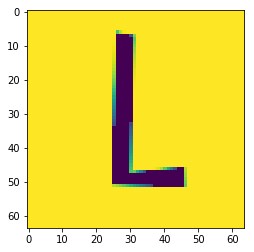

KeyboardInterrupt: 

In [56]:
agent = Agent(len(data.vocab),learnAE.model.encoder.state_dict(),learnSVG.model.token_emb.state_dict()).cuda()
opt_agent = torch.optim.Adam(agent.parameters(),lr=1e-5)#,weight_decay=0.01)
critic = Critic(len(data.vocab),learnInit.model[1].state_dict(),learnSVG.model.token_emb.state_dict()).cuda()
#critic_copy = Critic(len(data.vocab),learnInit.model[1].state_dict(),learnSVG.model.token_emb.state_dict()).cuda()
#critic_copy.load_state_dict(critic.state_dict())
#requires_grad(critic_copy,False)
opt_critic = torch.optim.Adam(critic.parameters(),lr=3e-5,weight_decay=0.01)
action_mask = [torch.ByteTensor([1]*len(tool_dict[data.vocab[i]]) + [0]*(4-len(tool_dict[data.vocab[i]]))) for i in range(len(data.vocab))]
action_mask = torch.stack(action_mask).cuda()
sigma_mult = 1
feature_encoder = nn.Sequential(
    conv2d(1,32,5,1,2),
    nn.InstanceNorm2d(32,affine=True),
    nn.ReLU(),
    conv2d(32,32,5,2,2),
    nn.InstanceNorm2d(32,affine=True),
    nn.ReLU(),
    conv2d(32,64,5,1,2),
    nn.InstanceNorm2d(64,affine=True),
    nn.ReLU(),
    conv2d(64,64,5,2,2),
    nn.InstanceNorm2d(64,affine=True),
    nn.ReLU(),
    conv2d(64,64,3,2,1),
    nn.InstanceNorm2d(64,affine=True),
    nn.ReLU(),
    conv2d(64,64,3,2,1),
    nn.InstanceNorm2d(64,affine=True),
    nn.ReLU()).cuda()
feature_encoder.load_state_dict(learnAE.model.encoder.state_dict())
feature_encoder = feature_encoder[:-2]
requires_grad(feature_encoder,False)

best_avg_reward = -1e10
agent_sd,agent_opt_sd,critic_sd,critic_opt_sd = None,None,None,None

with torch.autograd.detect_anomaly():
    return_store = []
    for epoch in range(150):
        state, state_tools, state_pens = start_state, start_state_tools, start_state_pens
        state_history = [state.cpu()]
        state_pen_history = [state_pens]
        action_log_probs, pen_log_probs, rewards, actions, mses, entropy_a, entropy_p, values, deltas, mus, sigmas = [], [], [], [], [], [], [], [], [], [], []
        #target_features = feature_encoder(targets).detach()
        baseline_mse = F.l1_loss(start_state,targets,reduction="none").view(start_state.shape[0],-1).mean(dim=1) #+ 0.05*F.mse_loss(feature_encoder(start_state),target_features,reduction="none").view(start_state.shape[0],-1).mean(dim=1)
        baseline = torch.ones_like(baseline_mse)
        max_return = baseline.max()
        seq_mask = torch.ones(state_tools.shape[0],state_tools.shape[1]).byte().cuda()
        mask_history = [seq_mask.clone()]
        agent.eval()
        critic.train()
        for t in range(2):
            npens, delta, action_probs, pen_probs, action, action_entropy, pen_entropy, mu, sigma = agent(state,targets,state_tools,state_pens,seq_mask=seq_mask,sigma_mult=sigma_mult)
            v = critic(state,targets,state_tools,state_pens,npens)
            #v = torch.clamp_max(v,max_return)
            seq_mask[torch.arange(seq_mask.shape[0]),action] = 0
            mask_history.append(seq_mask.clone())
            #print(state_pens-npens)
            state_pens = npens.detach()
            state_pen_history.append(state_pens)
            #print(tensors_to_path_string(state_tools[:,1:],state_pens[:,1:]))
            #state = nparallel(render_paths(tensors_to_path_string(state_tools[:,1:],state_pens[:,1:]))
            state = torch.stack(nparallel(render_path,tensors_to_path_string(state_tools[:,1:],state_pens[:,1:]))).unsqueeze(1).cuda()
            state_history.append(state.detach().cpu())
            mse = F.l1_loss(state,targets,reduction="none").view(state.shape[0],-1).mean(dim=1) #+ 0.05*F.mse_loss(feature_encoder(state),target_features,reduction="none").view(state.shape[0],-1).mean(dim=1)
            mse = mse / baseline_mse
            reward = baseline - mse
            baseline = mse
            action_log_probs.append(action_probs.detach())
            pen_log_probs.append(pen_probs.detach())
            rewards.append(reward.detach())
            actions.append(action.detach())
            mses.append(mse.detach())
            entropy_a.append(action_entropy.detach())
            entropy_p.append(pen_entropy.detach())
            deltas.append(delta.detach())
            values.append(v)
            mus.append(mu.detach())
            sigmas.append(sigma.detach())
    
        action_log_probs = torch.stack(action_log_probs,dim=1)
        pen_log_probs = torch.stack(pen_log_probs,dim=1)
        rewards = torch.stack(rewards,dim=1)
        actions = torch.stack(actions,dim=1)
        mses = torch.stack(mses,dim=1)
        entropy_a = torch.stack(entropy_a,dim=1)
        entropy_p = torch.stack(entropy_p,dim=1)
        values = torch.stack(values,dim=1)
        deltas = torch.stack(deltas,dim=1)
        mus = torch.stack(mus,dim=1)
        sigmas = torch.stack(sigmas,dim=1)
        state_history = torch.stack(state_history,dim=1)[:,:-1]
        state_pen_history = torch.stack(state_pen_history,dim=1)[:,:-1]
        mask_history = torch.stack(mask_history,dim=1)[:,:-1]
        tool = torch.gather(state_tools,1,actions)
        
        avg_rewards = rewards.sum(dim=1).mean().item()
        if avg_rewards >= best_avg_reward:
            best_avg_reward = avg_rewards
            torch.save(agent.state_dict(),"agent.pth")
            torch.save(critic.state_dict(),"critic.pth")

            
        npens, delta, action_probs, pen_probs, action, action_entropy, pen_entropy, mu, sigma = agent(state,targets,state_tools,state_pens,seq_mask=seq_mask,sigma_mult=sigma_mult)
        v = critic(state,targets,state_tools,state_pens,npens)
        #v = torch.clamp_max(v,max_return)
        
        R = v
        next_value = v.detach()
        advantage = torch.zeros_like(v)
        #R = torch.zeros_like(v)
        returns = []
        advantages = []
        for i in reversed(range(rewards.shape[1])):
            R = rewards[:,i] + 0.95 * R
            returns.insert(0,R)
            d = rewards[:,i] + 0.95*next_value - values[:,i]
            next_value = values[:,i].detach()
            advantage = advantage*0.95*0.5 + d
            advantages.insert(0,advantage)
        returns = torch.stack(returns,dim=1).detach()    
        advantages = torch.stack(advantages,dim=1)
                
        #advantages = returns - values
        loss_critic = advantages.pow(2).mean() #+ 0.1*values.pow(2).mean()
        #set_lr(opt_critic,max(2e-5,2e-4/(1+(10*(epoch/100.0)))))
        opt_critic.zero_grad()
        loss_critic.backward()
        opt_critic.step()
        #nn.utils.clip_grad_norm_(critic.parameters(),0.01)
        
#         alpha = min(epoch/10,0.9)
#         for npa,opa in zip(critic_copy.parameters(),critic.parameters()):
#             npa.data.mul_(alpha).add_((1-alpha)*opa.data)
        
        advantages = advantages.detach()
        #advantages = (advantages - advantages.mean()) / advantages.std()
        def get_minibatch(t,size,idxs):
            t = t.contiguous().view(-1,*t.shape[2:])
            t = t[idxs][:size]
            return t
        
        #set_lr(opt_agent,max(1e-4,1e-3/(1+(10*(epoch/100.0)))))
        
        agent.train()
        eps = 0.1
        num_samples = actions.shape[0] * actions.shape[1]
        bs = num_samples//2
        smooth_actor = SmoothenValue(0.90)
        for j in range(10):
            idxs = torch.randperm(num_samples)
            mb_actions = get_minibatch(actions,bs,idxs)
            mb_deltas = get_minibatch(deltas,bs,idxs)
            mb_states = get_minibatch(state_history,bs,idxs).cuda()
            mb_pens = get_minibatch(state_pen_history,bs,idxs)
            mb_pens_comp = get_minibatch(state_pen_history[:,:,1:],bs,idxs)
            mb_old_pen_probs = get_minibatch(pen_log_probs,bs,idxs)
            mb_old_action_probs = get_minibatch(action_log_probs,bs,idxs)
            mb_advantages = get_minibatch(advantages,bs,idxs)
            mb_masks = get_minibatch(mask_history,bs,idxs)
            mb_targets = get_minibatch(targets.unsqueeze(1).expand(-1,actions.shape[1],-1,-1,-1),bs,idxs)
            mb_tools = get_minibatch(start_state_tools.unsqueeze(1).expand(-1,actions.shape[1],-1),bs,idxs)
            mb_tool = mb_tools[torch.arange(mb_tools.shape[0]),mb_actions]
            mb_real = get_minibatch(target_pens[:,1:].unsqueeze(1).expand(-1,actions.shape[1],-1,-1),bs,idxs)
            mb_real = mb_real[torch.arange(mb_real.shape[0]),mb_actions]
            #print(state_pen_history.view(-1,*state_pen_history.shape[2:])[:20],target_pens.unsqueeze(1).view(-1,*target_pens.shape[1:])[:20])
            #print(mb_pens_comp[torch.arange(mb_pens_comp.shape[0]),mb_actions],mb_real)
            #print(f"pen {(mb_pens_comp[torch.arange(mb_pens_comp.shape[0]),mb_actions] - mb_real).pow(2).mean().item()}")
            new_action_probs, new_pen_probs, real_pen_probs = agent.get_log_probs(mb_states.detach(), mb_targets.detach(), mb_tools.detach(), mb_pens.detach(), mb_pens_comp.detach(), mb_actions.detach(), mb_deltas.detach(), mb_real.detach(), mb_masks.detach())

            r_pen = torch.exp(new_pen_probs-mb_old_pen_probs.detach()) 
            loss = torch.where(mb_advantages.unsqueeze(-1) >= 0,torch.min(r_pen,torch.zeros_like(r_pen).fill_(1+eps)),torch.max(r_pen,torch.zeros_like(r_pen).fill_(1-eps))) * mb_advantages.unsqueeze(-1)
            #loss = torch.min((mb_advantages.unsqueeze(-1) * r_pen),mb_advantages.unsqueeze(-1) * torch.clamp(r_pen,1.0-eps,1.0+eps))
            loss[~action_mask[mb_tool]] = 0.0
            l_pos = loss[(mb_advantages.unsqueeze(-1).expand(-1,4)>0) & action_mask[mb_tool]].mean()
            l_neg = -loss[(mb_advantages.unsqueeze(-1).expand(-1,4)<0) & action_mask[mb_tool]].mean()
#             if(not torch.isnan(l_pos) and not torch.isnan(l_neg)):
#                 sf = l_pos / (l_neg+1e-7)
#                 sf /= 10
#                 loss[(mb_advantages.unsqueeze(-1).expand(-1,4)<0) & action_mask[mb_tool]] *= sf
#             loss = torch.clamp(loss,-1.0,3.0)
            #print(loss[(mb_advantages.unsqueeze(-1).expand(-1,4)>0) & action_mask[mb_tool]].mean().item(),loss[(mb_advantages.unsqueeze(-1).expand(-1,4)<0) & action_mask[mb_tool]].mean().item())
            loss = -loss.mean()
            r_action = torch.exp(new_action_probs-mb_old_action_probs.detach())
            loss = loss + -torch.min((mb_advantages * r_action),mb_advantages * torch.clamp(r_action,1.0-eps,1.0+eps)).mean()
            lp = loss.item()
            loss_real = -real_pen_probs[mb_real!=-2.0].mean()
            #loss = loss + loss_real
            smooth_actor.add_value(loss_real.item())
            opt_agent.zero_grad()
            loss.backward()
            opt_agent.step()

        
        #agent_copy.load_state_dict(agent.state_dict())
            
#         opt_agent.zero_grad()
#         loss.backward()
#         rnn_grads,mdn_grads = [],[]
#         for p in agent.path_encoder.parameters():
#             if p.grad is not None: rnn_grads.append(p.grad.abs().mean().item())
#         for p in agent.adjust.parameters():
#             if p.grad is not None: mdn_grads.append(p.grad.abs().mean().item())
#         print(agent.tool_sel.weight.grad.abs().mean().item() if agent.tool_sel.weight.grad is not None else "",np.mean(rnn_grads),np.mean(mdn_grads))
#         opt_agent.step()

        if epoch % 1 == 0:
            print(f"Epoch {epoch}: actor_real: {smooth_actor.smooth} actor_l: {lp} critic_l: {loss_critic.item()} reward: {rewards[0].sum().item()} avg_reward: {rewards.sum(dim=1).mean().item()} std_reward: {rewards.sum(dim=1).std().item()} avg_value: {values[:,0].mean().item()} return: {returns[:,0].mean().item()} \nmse: {mses[:,-1].mean().item()} alp: {action_log_probs.exp().mean().item()} deltas: {deltas[action_mask[tool]].abs().mean().item()} mu: {mus.abs().mean().item()} sigma: {sigmas.mean().item()}")# {0.01*entropy_a.mean()},{entropy_p.mean()}")
            plt.imshow(state[0,0])
            plt.show()

In [74]:
torch.save(agent.state_dict(),"agent.pth")
torch.save(critic.state_dict(),"critic.pth")

In [64]:
agent.load_state_dict(torch.load("agent.pth"))

In [ ]:
state, state_tools, state_pens = start_state, start_state_tools, start_state_pens
seq_mask = torch.ones(state_tools.shape[0],state_tools.shape[1]).byte().cuda()
agent.eval()
fig, axes = plt.subplots(2,3,figsize=(10,10))
axes[0,0].imshow(state[0,0])
axes[0,0].set_title(f"{F.mse_loss(state,targets).item()}")
prev_best = 1e10
with torch.no_grad():
    for t,ax in enumerate(axes.flatten()[1:]):
        cont = True
        while cont:
            npens, delta, action_probs, pen_probs, action, action_entropy, pen_entropy, mus, sigmas = agent(state,targets,state_tools,state_pens,seq_mask=seq_mask,sigma_mult=1)
            #npens, action = agent(state,targets,state_tools,state_pens,seq_mask=seq_mask,sigma_mult=1,explore=False)
            nstate = torch.stack(nparallel(render_path,tensors_to_path_string(state_tools[:,1:],npens[:,1:]))).unsqueeze(1).cuda()
            mse = F.mse_loss(state,targets,reduction="none").view(state.shape[0],-1).mean(dim=1)
            if torch.min(mse) < prev_best:
                cont = False
        seq_mask[torch.arange(seq_mask.shape[0]),action] = 0
        state_pens = npens.detach()
        state = nstate
        prev_best = torch.min(mse).item()
        best_mse = torch.argmax(-mse)
        state = state[[best_mse]].expand(64,-1,-1,-1)
        state_pens = state_pens[[best_mse]].expand(64,-1,-1)
        #ax.set_title(f"{F.mse_loss(state,targets).item()}")
        ax.set_title(f"{mse[best_mse]}")
        ax.imshow(state[0,0])

KeyboardInterrupt: 

0.0007655286462977529 1.2924983768887918e-05 0.0003777239279768955
Epoch 0: 1.5739831924438477 2.4039342403411865 1.4901161193847656e-08 0.018389882519841194 0.0914267897605896 0.02395102009177208,-1.5775117874145508


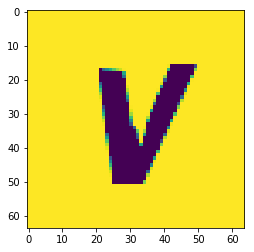

0.0009326579165644944 1.7194013262648394e-05 0.00037489978470972574
Epoch 1: 1.561108946800232 2.070552110671997 7.82310962677002e-08 0.020015019923448563 0.09142689406871796 0.023951232433319092,-1.5774612426757812


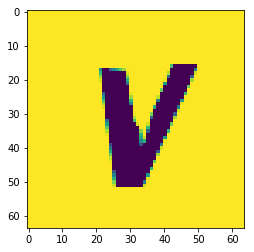

0.0006039472646079957 1.1025403490331579e-05 0.00037603016308425846
Epoch 2: 1.5781974792480469 1.879138708114624 7.450580596923828e-09 0.017964664846658707 0.09136654436588287 0.02395121566951275,-1.5772302150726318


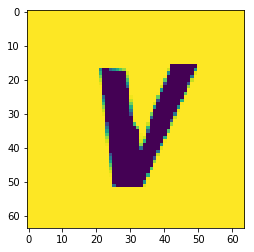

0.0010488081024959683 1.6846847382604817e-05 0.0003741710689427376
Epoch 3: 1.556400179862976 -1.3929425477981567 0.0 0.020292334258556366 0.09142100811004639 0.023951243609189987,-1.5771358013153076


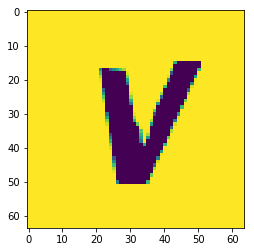

0.0004085150721948594 9.761140262298795e-06 0.00036842876510778666
Epoch 4: 1.5252052545547485 1.1384105682373047 1.4901161193847656e-08 0.017085842788219452 0.0915037989616394 0.023950936272740364,-1.5769259929656982


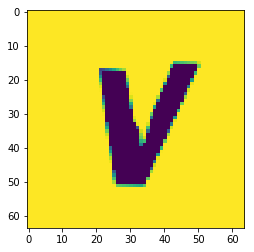

0.00048161915037781 1.0622512239895817e-05 0.0003767231536637716
Epoch 5: 1.5866397619247437 0.9410641193389893 6.705522537231445e-08 0.020083006471395493 0.09141425788402557 0.023951156064867973,-1.5767778158187866


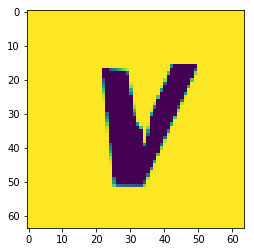

0.00048629799857735634 9.960291739237922e-06 0.000375014017416353
Epoch 6: 1.5709348917007446 0.9184969067573547 -7.450580596923828e-09 0.019257405772805214 0.0914444774389267 0.023951087146997452,-1.5766652822494507


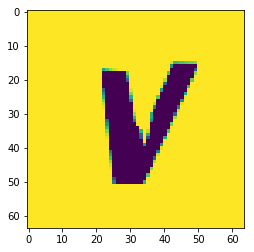

0.0003649643622338772 9.290185355818418e-06 0.00036978993450994163
Epoch 7: 1.5402048826217651 0.02615821361541748 4.470348358154297e-08 0.018773391842842102 0.09134145826101303 0.023950887843966484,-1.5765231847763062


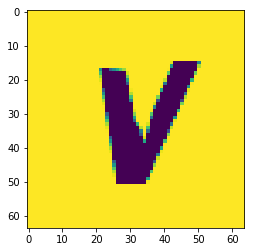

0.0008707435335963964 1.4366645568012851e-05 0.00037943517756981276
Epoch 8: 1.593172550201416 1.3749525547027588 0.0 0.018388399854302406 0.09141828864812851 0.023951029404997826,-1.5763511657714844


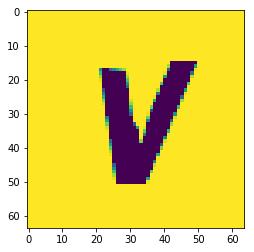

0.0006879209540784359 1.133736193992263e-05 0.0003805988965458103
Epoch 9: 1.602858304977417 1.1019940376281738 -1.4901161193847656e-08 0.01912587694823742 0.09150992333889008 0.023950647562742233,-1.5762107372283936


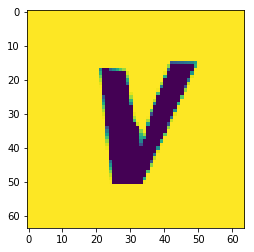

0.00043669913429766893 9.723004817866846e-06 0.0003766766654250316
Epoch 10: 1.5876693725585938 0.31071239709854126 -1.4901161193847656e-08 0.017661938443779945 0.09148506820201874 0.023951081559062004,-1.5760622024536133


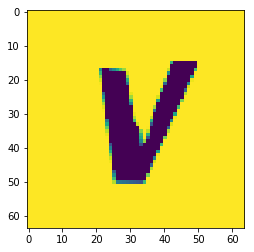

0.00038936847704462707 8.85360989855144e-06 0.00036779041721946015
Epoch 11: 1.5345131158828735 1.8910677433013916 -2.9802322387695312e-08 0.019292179495096207 0.09140323102474213 0.02395119145512581,-1.5759286880493164


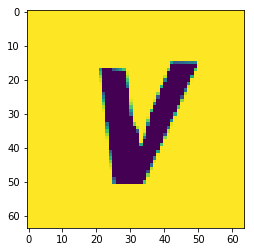

0.001021744916215539 1.629601260807097e-05 0.00037522267538843873
Epoch 12: 1.5813205242156982 0.48323962092399597 -5.960464477539063e-08 0.018888793885707855 0.09143664687871933 0.02395109087228775,-1.5758042335510254


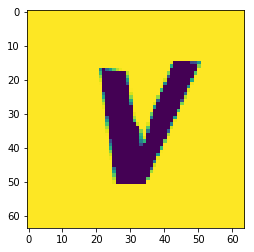

0.0006036236300133169 1.024126684493846e-05 0.000365239287522634
Epoch 13: 1.5218082666397095 1.0375059843063354 -5.21540641784668e-08 0.018759872764348984 0.09140165150165558 0.02395113743841648,-1.5756810903549194


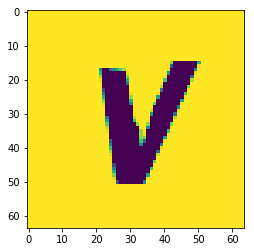

0.0004147301078774035 9.079561290074404e-06 0.00037063118085615504
Epoch 14: 1.5471470355987549 0.7391600012779236 0.0 0.0183428805321455 0.09139315783977509 0.02395097352564335,-1.5755376815795898


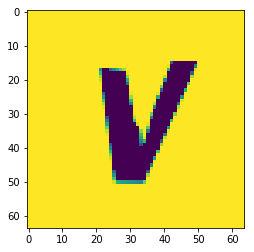

0.0003315091016702354 9.6396603055382e-06 0.0003728779158399161
Epoch 15: 1.5516663789749146 1.7136069536209106 -5.587935447692871e-08 0.017962437123060226 0.09150181710720062 0.023951105773448944,-1.575425148010254


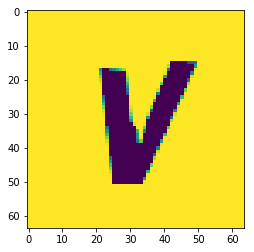

0.0005884903366677463 1.054373411572366e-05 0.0003715477510866094
Epoch 16: 1.5507041215896606 -1.9451879262924194 4.470348358154297e-08 0.017360668629407883 0.09147670120000839 0.023951184004545212,-1.5752171277999878


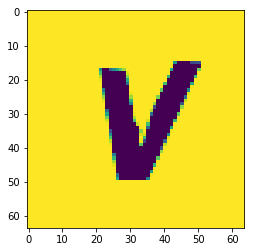

0.0008508397149853408 1.4755490582274433e-05 0.0003669771390468017
Epoch 17: 1.5282245874404907 0.4316696524620056 1.1175870895385742e-08 0.01913905330002308 0.09145413339138031 0.023951005190610886,-1.5751454830169678


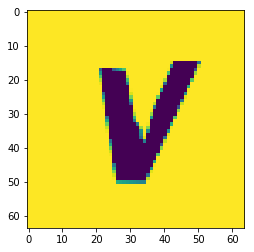

0.0002866482827812433 8.404746102049407e-06 0.00037440777307658674
Epoch 18: 1.5790526866912842 1.996781587600708 -7.450580596923828e-08 0.018293533474206924 0.09143200516700745 0.023951109498739243,-1.5749835968017578


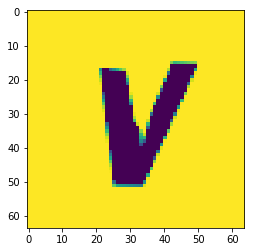

0.0005392531165853143 1.0092570680816001e-05 0.0003696671262200339
Epoch 19: 1.5456653833389282 1.6558709144592285 3.3527612686157227e-08 0.017963318154215813 0.09140841662883759 0.023951219394803047,-1.5748538970947266


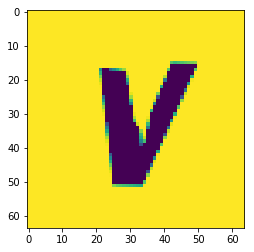

0.00044667714973911643 8.919230502613118e-06 0.00037129320293753193
Epoch 20: 1.5613256692886353 -0.30547499656677246 8.195638656616211e-08 0.018400507047772408 0.09143980592489243 0.023951129987835884,-1.5747636556625366


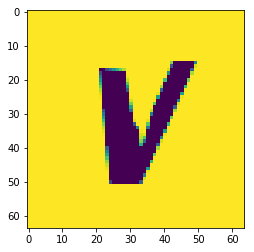

0.000546663417480886 1.0136792807221203e-05 0.00037255051631834846
Epoch 21: 1.5674761533737183 -2.1189165115356445 2.2351741790771484e-08 0.018715832382440567 0.09145301580429077 0.023950980976223946,-1.5745658874511719


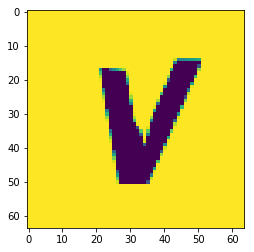

0.000570518895983696 9.861204193365817e-06 0.00037330573051737775
Epoch 22: 1.557784914970398 0.9924583435058594 -1.862645149230957e-08 0.01826183870434761 0.09137740731239319 0.023950980976223946,-1.574446439743042


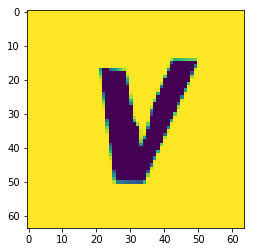

0.00035559647949412465 8.556852764722104e-06 0.00037959002530851826
Epoch 23: 1.603359580039978 -1.5301926136016846 7.450580596923828e-09 0.01894778572022915 0.09141482412815094 0.023950818926095963,-1.5743091106414795


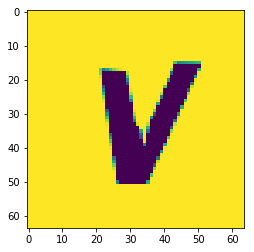

0.0005643945769406855 9.727412096556995e-06 0.0003695773441464804
Epoch 24: 1.5439081192016602 0.33431553840637207 2.2351741790771484e-08 0.01952330581843853 0.09142687171697617 0.023951184004545212,-1.5742535591125488


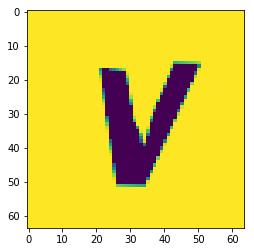

0.0005033951019868255 1.0861388564838611e-05 0.0003681977171409538
Epoch 25: 1.537068486213684 0.5411909222602844 -2.9802322387695312e-08 0.018443455919623375 0.09146171063184738 0.023951180279254913,-1.5740747451782227


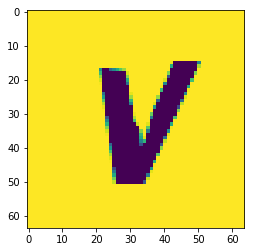

0.0006574810249730945 1.1866545520433647e-05 0.00037570807307870285
Epoch 26: 1.5780330896377563 0.7724370956420898 4.470348358154297e-08 0.018724653869867325 0.09135472774505615 0.023950990289449692,-1.5739296674728394


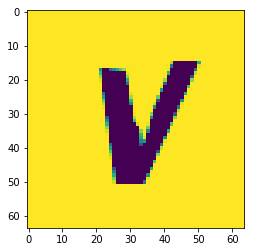

0.00042088303598575294 8.86066919984311e-06 0.0003700062067215996
Epoch 27: 1.55061936378479 -1.5120853185653687 2.9802322387695312e-08 0.01917196437716484 0.09143660962581635 0.023950627073645592,-1.573778510093689


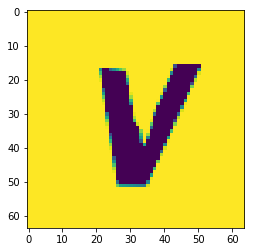

0.00037487279041670263 9.276476795605504e-06 0.0003694837176517751
Epoch 28: 1.5484273433685303 0.5742212533950806 3.725290298461914e-08 0.019655240699648857 0.09147932380437851 0.02395094558596611,-1.5736620426177979


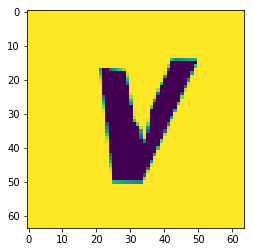

0.000479950598673895 9.24818162199396e-06 0.00037645971708003917
Epoch 29: 1.5748915672302246 2.1320037841796875 2.2351741790771484e-08 0.016562262549996376 0.09124588221311569 0.0239507257938385,-1.573547601699829


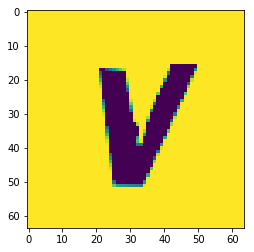

0.00036308279959484935 9.078182680847627e-06 0.00037460190466465093
Epoch 30: 1.5676467418670654 1.566877007484436 2.2351741790771484e-08 0.01793655753135681 0.09130861610174179 0.02395036444067955,-1.5734323263168335


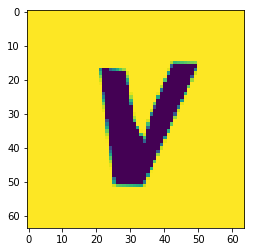

0.0004942354280501604 9.864752674578389e-06 0.0003719724384494416
Epoch 31: 1.550946831703186 0.6194518804550171 1.4901161193847656e-08 0.018924307078123093 0.09143271297216415 0.0239503663033247,-1.5732848644256592


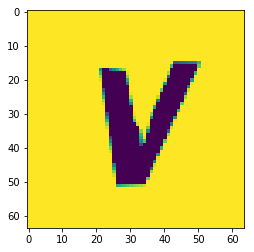

0.0003445904585532844 8.620129960945633e-06 0.00037190814408938344
Epoch 32: 1.5588306188583374 0.25724780559539795 -1.1175870895385742e-08 0.018342284485697746 0.09141162037849426 0.02395050972700119,-1.5731513500213623


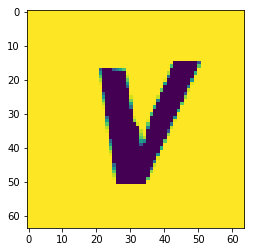

0.00022686079319100827 7.505151520111515e-06 0.00037494494888390406
Epoch 33: 1.581728219985962 -0.5730633735656738 7.450580596923828e-09 0.01885944791138172 0.09143425524234772 0.023950399830937386,-1.573014736175537


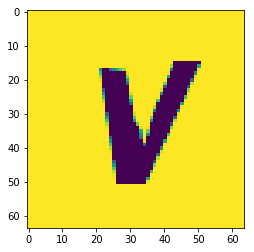

0.00033404334681108594 8.705404603404077e-06 0.0003762043404280657
Epoch 34: 1.5684750080108643 -1.6133760213851929 1.1175870895385742e-08 0.019002225250005722 0.09137323498725891 0.023950524628162384,-1.5728487968444824


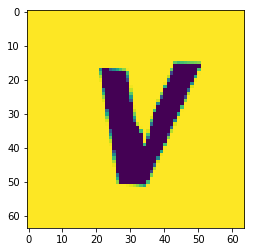

0.0005174188991077244 1.0057252450697737e-05 0.00037135747853334067
Epoch 35: 1.5462450981140137 -2.0334157943725586 2.60770320892334e-08 0.01871112547814846 0.09153378009796143 0.023950567469000816,-1.572695255279541


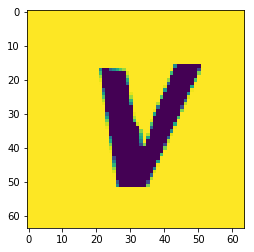

0.0004360843449831009 8.287559680297818e-06 0.00036802168355254405
Epoch 36: 1.531430721282959 -0.17070189118385315 -1.4901161193847656e-08 0.018501481041312218 0.09142667055130005 0.02395031601190567,-1.5725778341293335


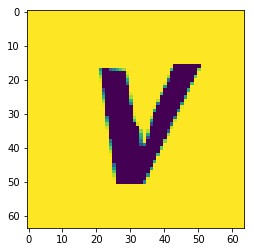

0.0004999451339244843 1.0820205252078571e-05 0.00037612319144786355
Epoch 37: 1.581923246383667 -0.04718303680419922 -1.4901161193847656e-08 0.01848045364022255 0.09143417328596115 0.023950451985001564,-1.5724185705184937


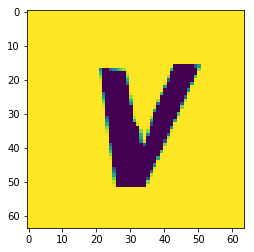

0.0002866222057491541 8.544485960252738e-06 0.0003790503857149889
Epoch 38: 1.5939096212387085 0.06297999620437622 -1.4901161193847656e-08 0.019989803433418274 0.09143047034740448 0.023950543254613876,-1.5722987651824951


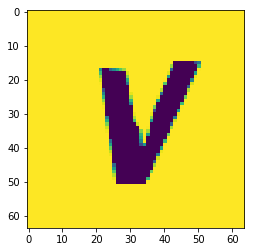

0.00038629959453828633 8.533639710132471e-06 0.0003748642380309401
Epoch 39: 1.54929780960083 -0.13380205631256104 -4.470348358154297e-08 0.0200739037245512 0.0913749560713768 0.0239506047219038,-1.5721696615219116


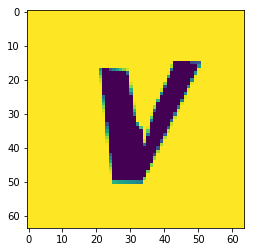

0.000334407901391387 8.442452210507176e-06 0.0003820751188406228
Epoch 40: 1.599822998046875 0.1428394466638565 0.0 0.019440624862909317 0.09128062427043915 0.02395058050751686,-1.5720057487487793


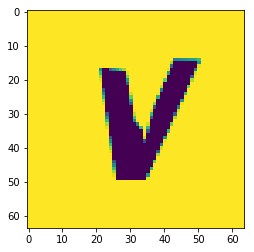

0.00045169374789111316 9.077495003377104e-06 0.00037754239900496717
Epoch 41: 1.5665167570114136 0.5461674928665161 1.4901161193847656e-08 0.018099868670105934 0.09142258763313293 0.023950450122356415,-1.5718806982040405


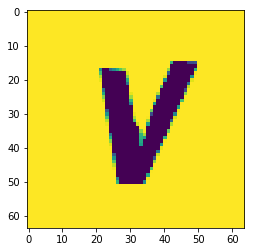

0.0005555139505304396 1.012211506197976e-05 0.00037877103835470827
Epoch 42: 1.5817601680755615 -0.5901409387588501 4.470348358154297e-08 0.01814926229417324 0.09141220897436142 0.023950209841132164,-1.571706771850586


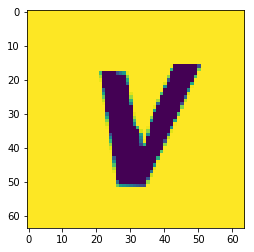

0.0007767287315800786 1.3729967614987496e-05 0.0003790039241514294
Epoch 43: 1.5738463401794434 0.012950539588928223 2.9802322387695312e-08 0.01918400079011917 0.09142172336578369 0.023950209841132164,-1.5716197490692139


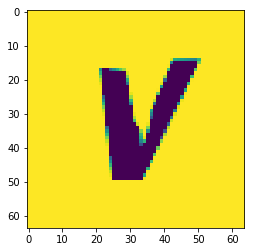

0.0006729266024194658 1.0998762398628514e-05 0.0003759165595556002
Epoch 44: 1.576522707939148 -1.419722318649292 7.450580596923828e-09 0.01842220313847065 0.09139000624418259 0.023950189352035522,-1.5714335441589355


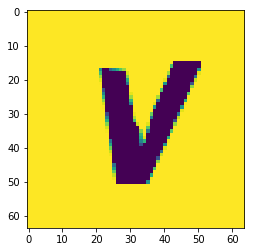

0.0005925212753936648 1.1442721787583801e-05 0.0003704546573414976
Epoch 45: 1.5362355709075928 -1.342843770980835 1.1920928955078125e-07 0.0194283165037632 0.09152381122112274 0.023949598893523216,-1.5712928771972656


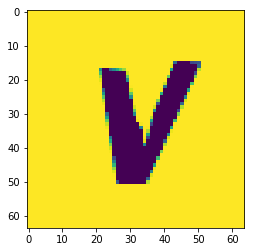

0.0003557904274202883 8.461902948416386e-06 0.0003706364671024846
Epoch 46: 1.540804386138916 -2.6078851222991943 1.4901161193847656e-08 0.01932075433433056 0.09154467284679413 0.023949861526489258,-1.571112036705017


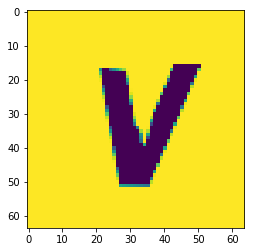

0.0007889112457633018 1.255102501337054e-05 0.0003758226634071882
Epoch 47: 1.5571941137313843 -0.4347555637359619 -2.2351741790771484e-08 0.02000799961388111 0.09145107120275497 0.023949848487973213,-1.5709636211395264


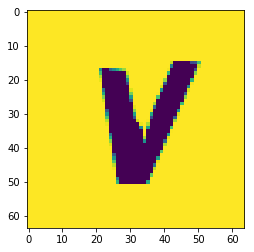

0.00048290210543200374 9.043372280359563e-06 0.0003666712034402497
Epoch 48: 1.5117557048797607 -3.9057998657226562 5.21540641784668e-08 0.01818658411502838 0.09131696075201035 0.02394927851855755,-1.5707995891571045


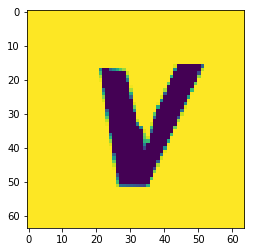

0.0002515163505449891 7.706441735422231e-06 0.00038101584627788415
Epoch 49: 1.5920428037643433 -3.4584245681762695 2.9802322387695312e-08 0.019034288823604584 0.09140288829803467 0.023949207738041878,-1.570658564567566


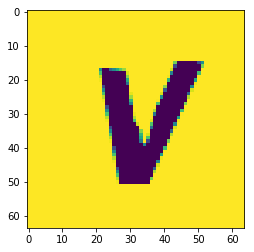

0.0003024580655619502 9.233772201374299e-06 0.0003747310332719393
Epoch 50: 1.5396755933761597 -3.261648178100586 4.470348358154297e-08 0.020226307213306427 0.09156307578086853 0.023949692025780678,-1.5704530477523804


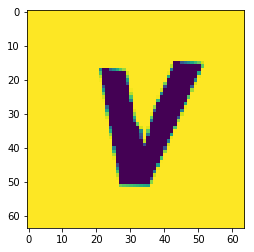

0.00020029059669468552 7.643798535165539e-06 0.00037283536744921647
Epoch 51: 1.5354814529418945 0.24410368502140045 -3.725290298461914e-08 0.017885547131299973 0.09146663546562195 0.02394888736307621,-1.5703370571136475


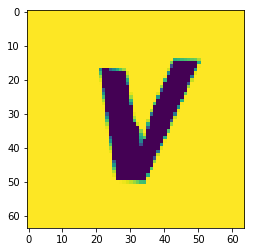

0.00028210890013724566 8.568323574801676e-06 0.00038152906014832233
Epoch 52: 1.5822359323501587 1.709949016571045 0.0 0.01938103884458542 0.0914318785071373 0.023949185386300087,-1.5701870918273926


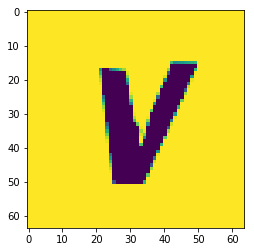

0.00046144978841766715 9.057928582005085e-06 0.00037664704840482494
Epoch 53: 1.561238408088684 1.9531776905059814 2.9802322387695312e-08 0.019048623740673065 0.09121166169643402 0.02394922450184822,-1.5700010061264038


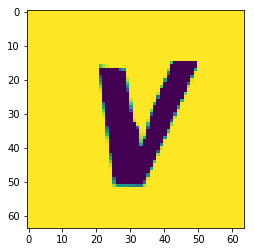

0.0002393134345766157 7.851906335787362e-06 0.0003800624078088936
Epoch 54: 1.5689458847045898 0.6184909343719482 2.9802322387695312e-08 0.018842477351427078 0.09155502170324326 0.023949140682816505,-1.5697702169418335


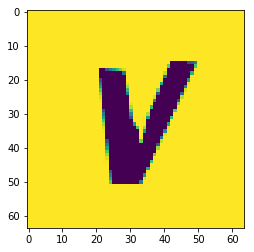

0.0003182940708938986 8.610205062116924e-06 0.0003839175265761459
Epoch 55: 1.590466856956482 -1.3576617240905762 3.725290298461914e-08 0.018561286851763725 0.09152626246213913 0.02394898422062397,-1.5696837902069092


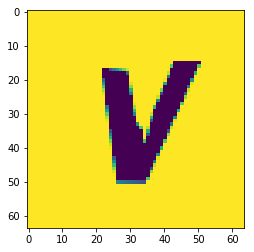

0.0002241573529317975 8.030994488687307e-06 0.0003796175956751006
Epoch 56: 1.5664454698562622 1.0402774810791016 1.4901161193847656e-08 0.017832225188612938 0.09139250218868256 0.023949431255459785,-1.5695257186889648


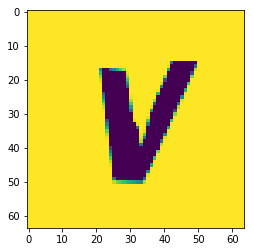

0.00025217252550646663 8.56177627639454e-06 0.00038058383765660064
Epoch 57: 1.5531476736068726 0.44525575637817383 -5.21540641784668e-08 0.018513206392526627 0.09125771373510361 0.02394901216030121,-1.5693063735961914


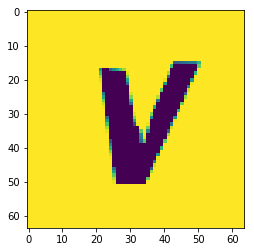

0.00019768040510825813 7.738347496418404e-06 0.00037584322590148805
Epoch 58: 1.537975549697876 0.7276041507720947 -1.862645149230957e-08 0.01818200573325157 0.09158362448215485 0.023949678987264633,-1.5691277980804443


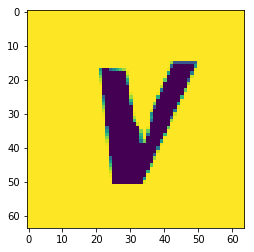

0.00032255559926852584 8.532447987856054e-06 0.00037928437719814134
Epoch 59: 1.5523303747177124 -1.8368730545043945 0.0 0.01789739355444908 0.09162409603595734 0.02394914999604225,-1.568901777267456


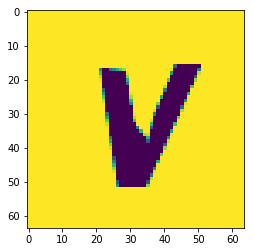

0.0004777978756465018 9.74614525735736e-06 0.00038257117042113836
Epoch 60: 1.5654945373535156 0.38480639457702637 0.0 0.018249912187457085 0.09122289717197418 0.023949259892106056,-1.568764090538025


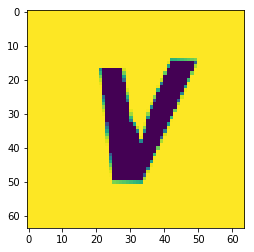

0.0004867149982601404 9.293010530579219e-06 0.0003876143223513114
Epoch 61: 1.589884877204895 -2.871781587600708 2.9802322387695312e-08 0.018676435574889183 0.09165439009666443 0.02394881844520569,-1.5685977935791016


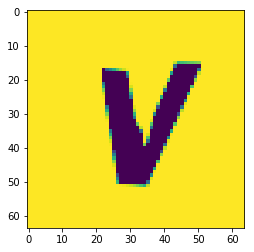

0.00017507791926618665 7.815608877118999e-06 0.00037813249702567386
Epoch 62: 1.5534989833831787 0.02835923433303833 1.4901161193847656e-08 0.020276932045817375 0.09146086871623993 0.02394949458539486,-1.568375587463379


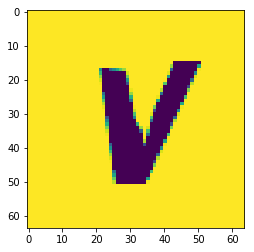

0.00036013187491334975 9.069321829239621e-06 0.0003823356722221967
Epoch 63: 1.5951374769210815 -0.356833815574646 7.450580596923828e-09 0.018233537673950195 0.09152011573314667 0.023949608206748962,-1.5681794881820679


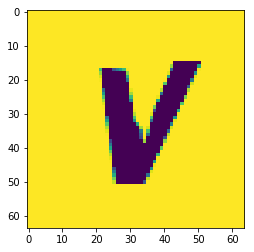

0.00017378971097059548 7.996434020422308e-06 0.00038179740389991207
Epoch 64: 1.567477822303772 -0.10984742641448975 2.9802322387695312e-08 0.01893450692296028 0.09133198112249374 0.023949632421135902,-1.5679943561553955


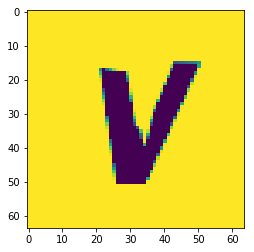

0.00030088951461948454 9.091272095436883e-06 0.0003849704343999634
Epoch 65: 1.5744706392288208 0.3552968204021454 2.9802322387695312e-08 0.018915362656116486 0.09155213087797165 0.023949474096298218,-1.5678441524505615


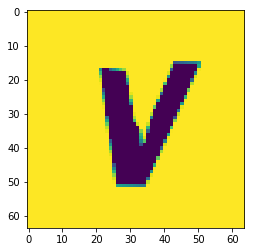

0.0006855432293377817 1.2262061019896464e-05 0.0003823582548041493
Epoch 66: 1.557108998298645 -2.1567113399505615 -7.450580596923828e-09 0.018737727776169777 0.09148150682449341 0.023949656635522842,-1.5675840377807617


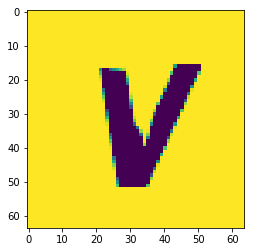

0.0002743506047409028 8.325016748263655e-06 0.0003774614618714163
Epoch 67: 1.5347651243209839 -0.07403188943862915 7.450580596923828e-08 0.019229402765631676 0.09143941104412079 0.023949913680553436,-1.5673778057098389


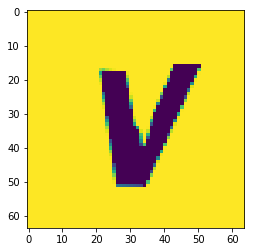

0.00017838997882790864 8.527085545514032e-06 0.00038892957846359266
Epoch 68: 1.5971906185150146 -0.20142579078674316 -1.1175870895385742e-08 0.018904130905866623 0.09154674410820007 0.0239496398717165,-1.5671954154968262


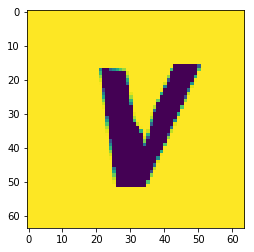

0.0005332703585736454 1.1010814821095968e-05 0.00038003754284628616
Epoch 69: 1.5407487154006958 0.09254777431488037 2.9802322387695312e-08 0.018931910395622253 0.0913313552737236 0.023949863389134407,-1.5670264959335327


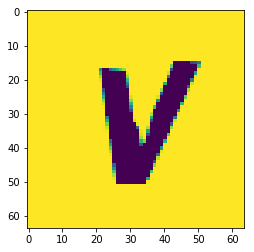

0.00036075239768251777 9.046292646530674e-06 0.0003790654930081831
Epoch 70: 1.533777117729187 -2.23095703125 3.725290298461914e-08 0.017919111996889114 0.09163486212491989 0.023949960246682167,-1.5668039321899414


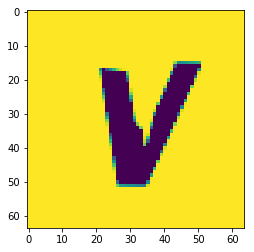

0.00018027963233180344 8.525775073782901e-06 0.0003859536571593954
Epoch 71: 1.574520468711853 0.31088805198669434 1.4901161193847656e-08 0.01959257945418358 0.09140782058238983 0.023949891328811646,-1.5665414333343506


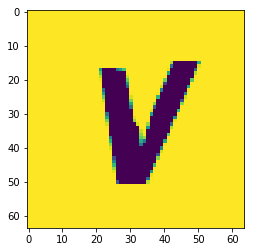

0.0001454615849070251 7.972360973459066e-06 0.0003751683619125738
Epoch 72: 1.5068359375 -1.2910369634628296 0.0 0.019042059779167175 0.09158311784267426 0.023949792608618736,-1.566327452659607


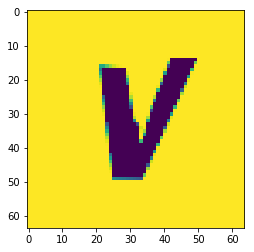

0.00048632657853886485 1.027403958649605e-05 0.0003825749539719814
Epoch 73: 1.5616270303726196 2.0288546085357666 1.862645149230957e-08 0.0199105367064476 0.09120281785726547 0.023949794471263885,-1.566124677658081


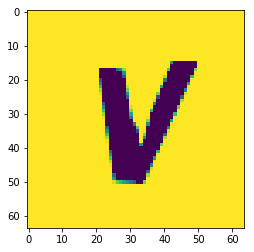

0.00018756912322714925 8.703968725617036e-06 0.00038935415369730403
Epoch 74: 1.576825737953186 -1.8368754386901855 -7.450580596923828e-09 0.0186002254486084 0.09167920053005219 0.023949673399329185,-1.5658735036849976


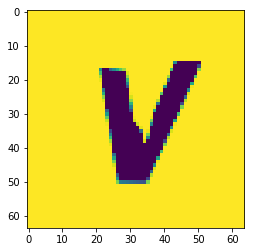

0.0001504236424807459 8.684640055397116e-06 0.00038538396074331666
Epoch 75: 1.5630742311477661 -2.2800486087799072 7.450580596923828e-08 0.01881289854645729 0.09142065048217773 0.023950133472681046,-1.5656393766403198


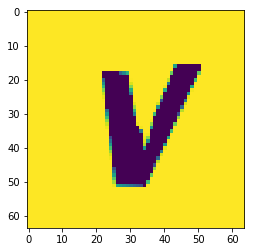

0.00023700219753663987 9.037613023584376e-06 0.0003793326463159552
Epoch 76: 1.5308936834335327 1.407119870185852 1.30385160446167e-08 0.01812971755862236 0.09155227243900299 0.023950280621647835,-1.5654000043869019


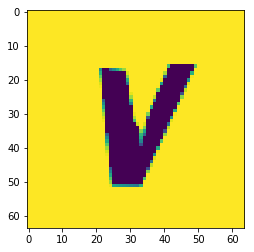

0.00044504881952889264 1.0915803670741298e-05 0.00038728941089383184
Epoch 77: 1.5696585178375244 0.7628931999206543 -7.450580596923828e-09 0.017550289630889893 0.09151880443096161 0.02394985407590866,-1.5651941299438477


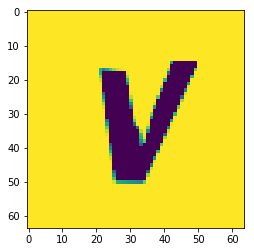

0.0003225567052140832 9.444013948941196e-06 0.0003808931881997453
Epoch 78: 1.5313273668289185 -1.718631625175476 5.960464477539063e-08 0.01889983005821705 0.09128563106060028 0.023950306698679924,-1.5649545192718506


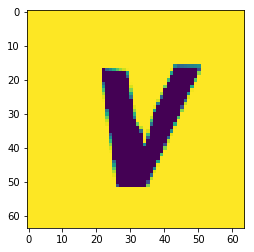

0.0003204624226782471 9.031530758818462e-06 0.0003771905546528324
Epoch 79: 1.4991557598114014 0.9655970335006714 1.1920928955078125e-07 0.019526513293385506 0.09152713418006897 0.02395028993487358,-1.5646841526031494


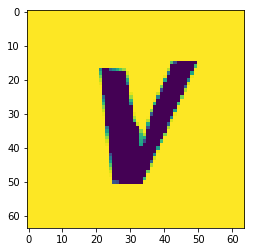

0.00026598863769322634 9.347691523942103e-06 0.00038632452794473693
Epoch 80: 1.5642439126968384 0.8736521601676941 -2.2351741790771484e-08 0.01754555106163025 0.09137128293514252 0.02395053580403328,-1.5644335746765137


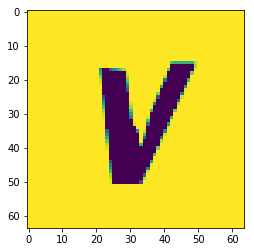

0.0004262271977495402 1.1118256137384227e-05 0.00039432334658240364
Epoch 81: 1.5958027839660645 0.5030153393745422 -6.705522537231445e-08 0.018987882882356644 0.09139382839202881 0.023950351402163506,-1.5641788244247437


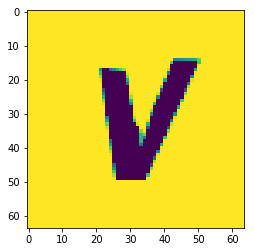

0.00041570860776118934 1.0722123524449975e-05 0.00038322192430732355
Epoch 82: 1.5240610837936401 -0.7769990563392639 5.960464477539063e-08 0.018881376832723618 0.09148404002189636 0.02395051345229149,-1.5638965368270874


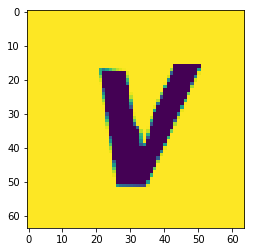

0.00023697706637904048 9.341414906790154e-06 0.00038428576737577674
Epoch 83: 1.547385334968567 1.399869680404663 1.4901161193847656e-08 0.018823379650712013 0.09130346029996872 0.02395043708384037,-1.5637166500091553


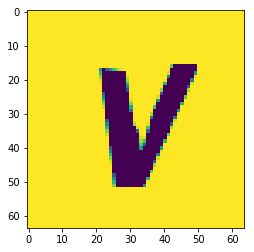

0.00038954574847593904 1.036345129416342e-05 0.0003903629191122822
Epoch 84: 1.572421908378601 0.7142634391784668 3.725290298461914e-08 0.018394287675619125 0.09136717766523361 0.02395039238035679,-1.5633976459503174


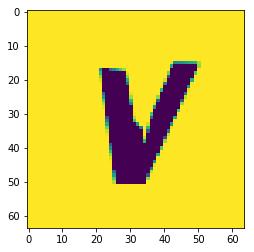

0.0006745688733644783 1.3874826464643775e-05 0.0003828418012451114
Epoch 85: 1.5169095993041992 -0.8496339321136475 1.2665987014770508e-07 0.019994040951132774 0.09134690463542938 0.023950332775712013,-1.5631396770477295


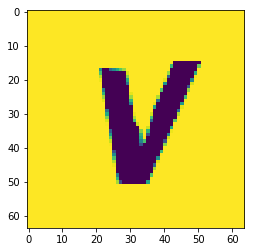

0.00040998775511980057 1.0977143875360676e-05 0.0003870056238409377
Epoch 86: 1.5585403442382812 -0.3473479449748993 5.960464477539063e-08 0.017452659085392952 0.09139770269393921 0.02395043522119522,-1.5628488063812256


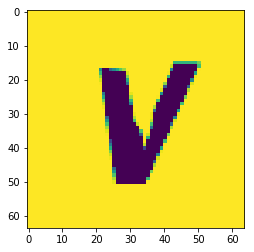

0.00017764615768101066 9.6901589661987e-06 0.0004011515651018982
Epoch 87: 1.608903169631958 -2.2086970806121826 2.2351741790771484e-08 0.019720207899808884 0.09128235280513763 0.023950504139065742,-1.5625677108764648


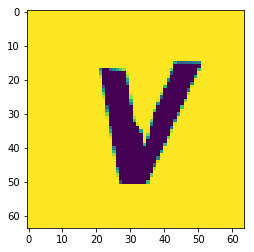

0.0001821805926738307 9.821134779504822e-06 0.00038741825700766563
Epoch 88: 1.5280749797821045 0.5520428419113159 6.705522537231445e-08 0.0182822123169899 0.09141993522644043 0.023949718102812767,-1.5622568130493164


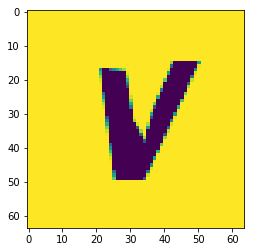

0.0001702659938018769 9.71234214356779e-06 0.0003902606947592628
Epoch 89: 1.540946364402771 -2.5359418392181396 4.6566128730773926e-08 0.017994163557887077 0.09141423553228378 0.023950137197971344,-1.5619392395019531


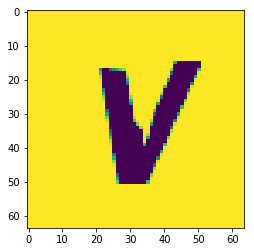

0.00021886028116568923 1.0069070834598884e-05 0.00039141411940076437
Epoch 90: 1.5694048404693604 -1.3498220443725586 7.450580596923828e-08 0.019213246181607246 0.09143172204494476 0.02395007014274597,-1.5616512298583984


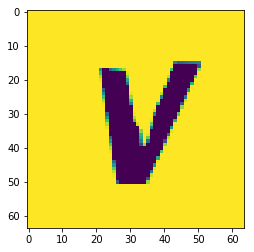

0.00033276795875281096 1.111469531167586e-05 0.00039549852628328885
Epoch 91: 1.568005919456482 0.540112316608429 7.450580596923828e-08 0.018475664779543877 0.0912453755736351 0.023950185626745224,-1.5613330602645874


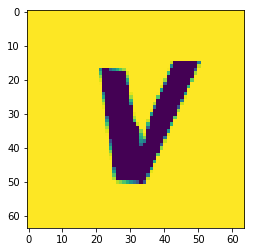

0.0005028869491070509 1.2659254765641966e-05 0.0003888741148236156
Epoch 92: 1.5342791080474854 0.9582873582839966 2.2351741790771484e-08 0.019641276448965073 0.09141625463962555 0.02394995093345642,-1.5610356330871582


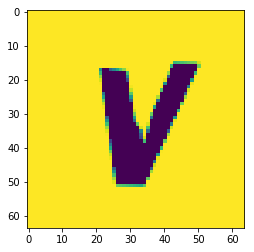

0.00048376433551311493 1.2205588343287369e-05 0.00039511384330133864
Epoch 93: 1.571165680885315 0.10733024775981903 2.9802322387695312e-08 0.017402581870555878 0.0914580449461937 0.023949822410941124,-1.5606908798217773


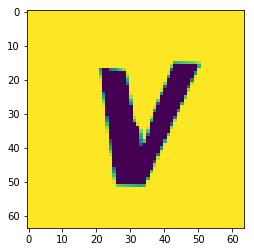

0.00028049806132912636 1.0800047139269964e-05 0.0003926903231428562
Epoch 94: 1.548253059387207 -1.93698251247406 1.862645149230957e-08 0.01904415711760521 0.09136436879634857 0.023950079455971718,-1.5603671073913574


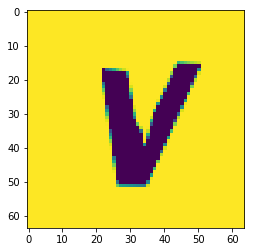

0.00035283830948174 1.1579556980242009e-05 0.00038613864404809145
Epoch 95: 1.5158157348632812 -2.9487318992614746 -7.450580596923828e-09 0.019000405445694923 0.09132393449544907 0.023949822410941124,-1.5600064992904663


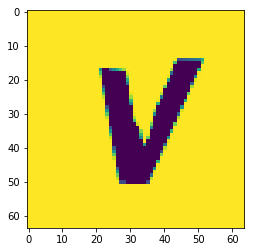

0.0005287080421112478 1.370277944801046e-05 0.0003981465360703244
Epoch 96: 1.5701632499694824 -0.043222665786743164 -4.470348358154297e-08 0.019016388803720474 0.09154407680034637 0.023950040340423584,-1.5596413612365723


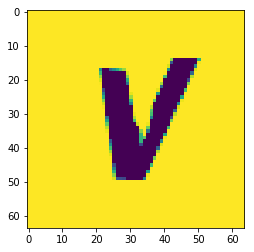

0.00025662261759862304 1.1585684970801443e-05 0.0004018423733252637
Epoch 97: 1.5832804441452026 -2.249629020690918 1.4901161193847656e-08 0.018747469410300255 0.09149562567472458 0.023949766531586647,-1.559314250946045


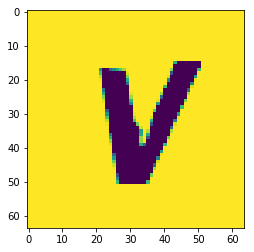

0.00014932863996364176 1.176189084025244e-05 0.0004101012867859429
Epoch 98: 1.6162545680999756 0.7008324861526489 5.21540641784668e-08 0.01878487691283226 0.09158243238925934 0.02394970692694187,-1.558884859085083


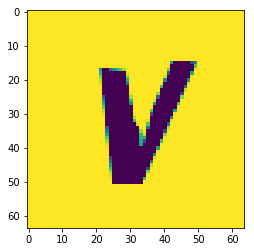

0.0003046157071366906 1.2258128087694331e-05 0.00039569934157276016
Epoch 99: 1.5381603240966797 -3.864898443222046 4.0978193283081055e-08 0.019263895228505135 0.09157001972198486 0.023949570953845978,-1.5585026741027832


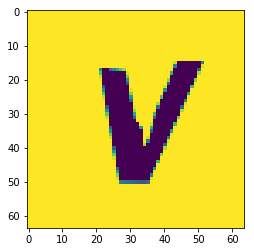

0.0003265546984039247 1.227110161513186e-05 0.0003983711234823624
Epoch 100: 1.5566869974136353 -1.1267260313034058 -7.450580596923828e-09 0.01763833314180374 0.09132581949234009 0.023949192836880684,-1.5581282377243042


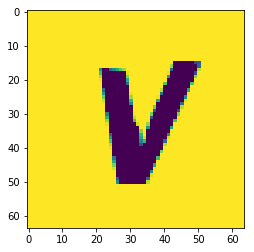

0.00028441642643883824 1.2188073450640028e-05 0.00039256864971304317
Epoch 101: 1.5280673503875732 0.6173598766326904 -5.960464477539063e-08 0.017406390979886055 0.0914861187338829 0.023949580267071724,-1.5576938390731812


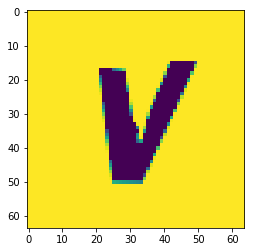

0.00014407941489480436 1.1947329773202378e-05 0.0003985726285650933
Epoch 102: 1.5482048988342285 -1.204088807106018 -2.9802322387695312e-08 0.018059147521853447 0.09126138687133789 0.023949453607201576,-1.5572738647460938


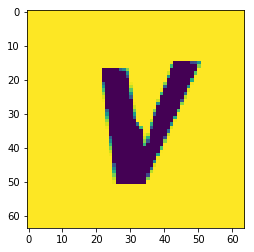

0.00013254969962872565 1.2511813759867133e-05 0.0004012249147295662
Epoch 103: 1.5593327283859253 0.0691291093826294 3.725290298461914e-08 0.01920994184911251 0.09158023446798325 0.02394941821694374,-1.5568830966949463


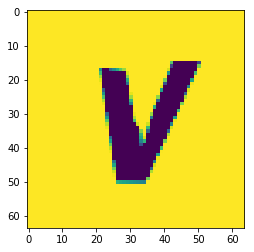

0.0001546473358757794 1.2326693227038277e-05 0.0003955006878860005
Epoch 104: 1.5260359048843384 -5.822074890136719 -1.1175870895385742e-08 0.01927242986857891 0.09139209985733032 0.02394944801926613,-1.5564486980438232


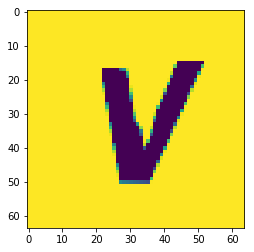

0.00012968177907168865 1.225255660723216e-05 0.00039002375245219173
Epoch 105: 1.4984947443008423 0.022519946098327637 5.960464477539063e-08 0.018709661439061165 0.09134819358587265 0.02394977957010269,-1.5559451580047607


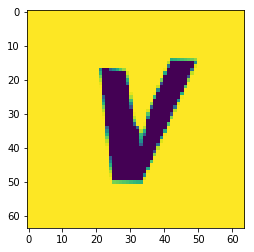

0.0004397517768666148 1.4347104539069733e-05 0.0004104590033414309
Epoch 106: 1.5970221757888794 1.1838923692703247 -1.4901161193847656e-08 0.01727168634533882 0.09136509895324707 0.023949431255459785,-1.555485486984253


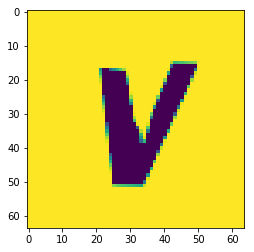

0.00010571340681053698 1.3247654102599427e-05 0.00039751426831139786
Epoch 107: 1.5182970762252808 -1.5246902704238892 4.470348358154297e-08 0.01922435127198696 0.09158496558666229 0.023949939757585526,-1.5550297498703003


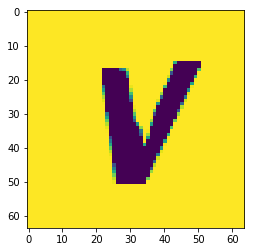

0.0005672015249729156 1.564452254617284e-05 0.00039641043184716435
Epoch 108: 1.5042216777801514 0.49501603841781616 -4.470348358154297e-08 0.019992658868432045 0.09135101735591888 0.023949861526489258,-1.5545337200164795


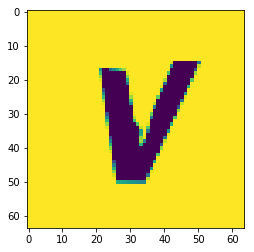

7.034502050373703e-05 1.3317137954752903e-05 0.0003934195291930287
Epoch 109: 1.4927889108657837 -0.7572165131568909 2.9802322387695312e-08 0.018194258213043213 0.09144877642393112 0.023949630558490753,-1.5540651082992554


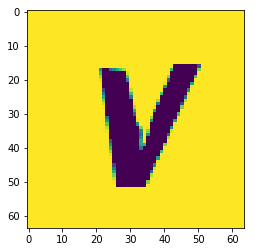

0.0002768288250081241 1.502503779941359e-05 0.00039813045722251567
Epoch 110: 1.5218393802642822 0.6047828197479248 1.4901161193847656e-08 0.018581371754407883 0.09156843274831772 0.023949826136231422,-1.553483009338379


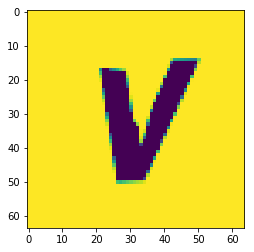

0.00022946626995690167 1.4743757081584855e-05 0.00041004605763609686
Epoch 111: 1.5652319192886353 -2.4351882934570312 4.470348358154297e-08 0.018293077126145363 0.09139382839202881 0.023949813097715378,-1.5529435873031616


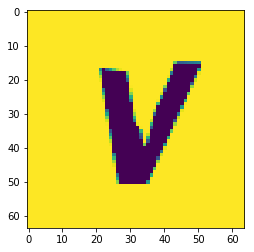

0.00025147644919343293 1.496344071938438e-05 0.0004026257519356702
Epoch 112: 1.5305806398391724 -0.966873288154602 2.9802322387695312e-08 0.018521640449762344 0.09139186143875122 0.02394982986152172,-1.5524801015853882


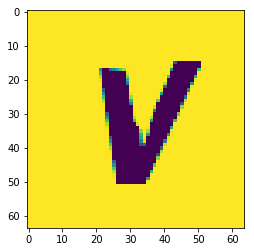

0.00017917549121193588 1.4965546981215994e-05 0.0004021842283217965
Epoch 113: 1.5331718921661377 2.2173707485198975 4.470348358154297e-08 0.019094455987215042 0.09130384773015976 0.023950120434165,-1.5519359111785889


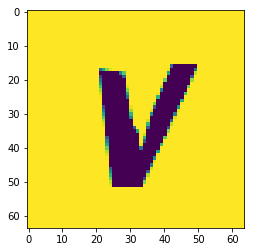

0.00014401046792045236 1.550966067812946e-05 0.0004047941258255028
Epoch 114: 1.5318275690078735 0.7573002576828003 -2.9802322387695312e-08 0.01838652417063713 0.09140267223119736 0.023950006812810898,-1.5513134002685547


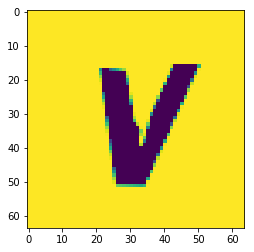

0.000301861873595044 1.666352302957345e-05 0.00040110107926231525
Epoch 115: 1.5139968395233154 -0.6527942419052124 1.4901161193847656e-08 0.01911989226937294 0.09165124595165253 0.023949982598423958,-1.5506576299667358


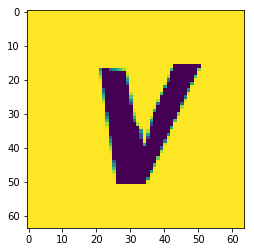

0.00022776771220378578 1.6569049459273327e-05 0.00041166419344969746
Epoch 116: 1.5543476343154907 1.97709321975708 4.284083843231201e-08 0.019093433395028114 0.09140589833259583 0.023949870839715004,-1.5500519275665283


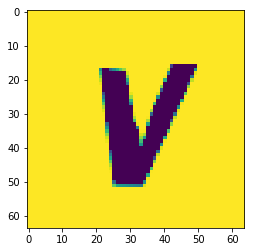

0.0003552138223312795 1.7461776717908606e-05 0.00041120247436365887
Epoch 117: 1.55857515335083 -4.652106285095215 7.450580596923828e-09 0.017516447231173515 0.09152539819478989 0.023950232192873955,-1.5493478775024414


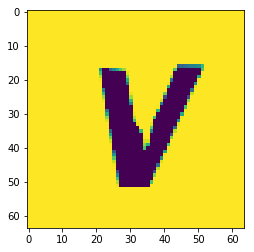

0.00018420636479277164 1.7740529213957263e-05 0.00041607465037030167
Epoch 118: 1.5775192975997925 1.0924140214920044 -2.60770320892334e-08 0.01745769940316677 0.09144717454910278 0.02395021542906761,-1.5486787557601929


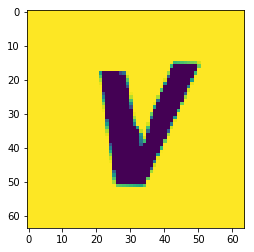

0.00020556845993269235 1.7924811947030623e-05 0.00040698089110557945
Epoch 119: 1.541869878768921 1.4330800771713257 4.470348358154297e-08 0.01910608820617199 0.09145452827215195 0.02395031601190567,-1.5479564666748047


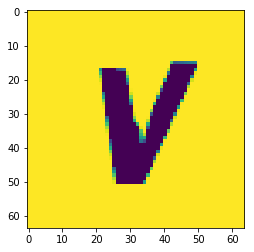

0.0001646154560148716 1.793939279555919e-05 0.00040212414792599
Epoch 120: 1.4936437606811523 -0.31970351934432983 -1.4901161193847656e-08 0.018537363037467003 0.09143616259098053 0.02395038492977619,-1.5471742153167725


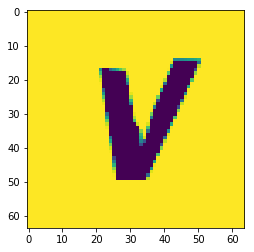

8.589585922891274e-05 1.805413501543285e-05 0.00040166117377415933
Epoch 121: 1.477007508277893 0.6426280736923218 -2.9802322387695312e-08 0.01990605518221855 0.09144028276205063 0.02395038492977619,-1.5465278625488281


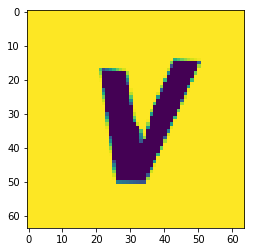

0.00021285451657604426 1.9449126639869974e-05 0.000418874316796584
Epoch 122: 1.5607632398605347 -1.4188194274902344 6.332993507385254e-08 0.01953471451997757 0.0914447009563446 0.023950600996613503,-1.5457050800323486


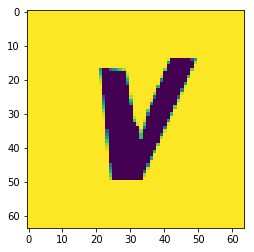

0.0002432610490359366 2.0445817648114446e-05 0.00042242956583860014
Epoch 123: 1.5875837802886963 -2.7019662857055664 3.725290298461914e-09 0.017990225926041603 0.0914391428232193 0.023950567469000816,-1.5448119640350342


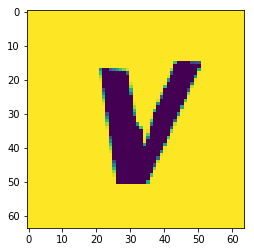

0.0002558603882789612 2.0687173884444594e-05 0.00041003252235090787
Epoch 124: 1.517457365989685 1.1663960218429565 -3.3527612686157227e-08 0.019431473687291145 0.09156887233257294 0.023950424045324326,-1.5438652038574219


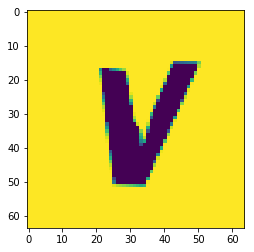

0.0002976945834234357 2.1330750143988553e-05 0.00041736340800128485
Epoch 125: 1.5393975973129272 -0.661771833896637 -2.9802322387695312e-08 0.018363412469625473 0.09128665924072266 0.02395058050751686,-1.5431898832321167


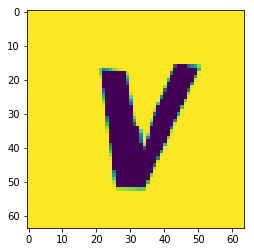

0.000522288610227406 2.242999136825574e-05 0.00040780279981881645
Epoch 126: 1.4871580600738525 2.0462257862091064 5.960464477539063e-08 0.019373809918761253 0.09127216786146164 0.023950519040226936,-1.5421881675720215


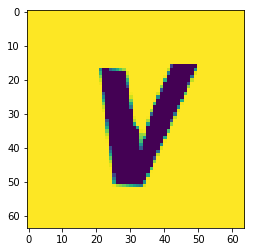

0.0004924368113279343 2.3496056509012913e-05 0.0004127239835558516
Epoch 127: 1.5107660293579102 -2.4601705074310303 0.0 0.019724315032362938 0.09129314869642258 0.023950424045324326,-1.5410975217819214


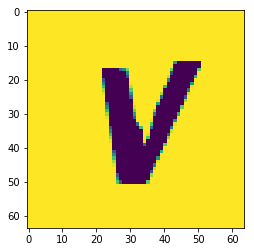

0.00013629520253743976 2.31171338202311e-05 0.0004098696450651751
Epoch 128: 1.486404538154602 -5.664463996887207 5.960464477539063e-08 0.018428655341267586 0.09171043336391449 0.02395017258822918,-1.5400514602661133


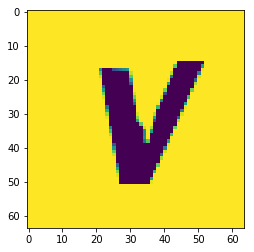

0.00017559752450324595 2.404476102431848e-05 0.00041973094281477774
Epoch 129: 1.5345168113708496 -1.6169008016586304 5.21540641784668e-08 0.018698465079069138 0.09138010442256927 0.023950519040226936,-1.5390986204147339


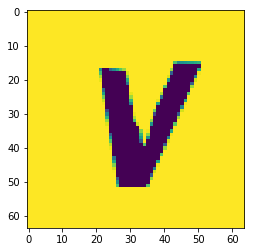

0.0004929127171635628 2.531639992871722e-05 0.0004175485998375213
Epoch 130: 1.5299550294876099 0.7402362823486328 -4.470348358154297e-08 0.020330695435404778 0.09124676883220673 0.023950161412358284,-1.5379915237426758


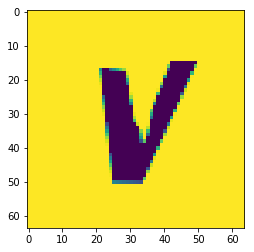

0.0002108233456965536 2.5569921917896938e-05 0.0004127526372682914
Epoch 131: 1.5105849504470825 0.9757373332977295 -5.960464477539063e-08 0.018532786518335342 0.0914955884218216 0.02395005151629448,-1.536673903465271


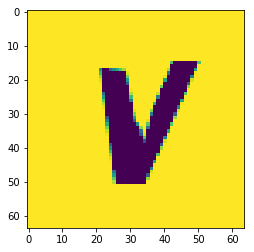

0.00024718380882404745 2.7187194452456726e-05 0.00042670245174299587
Epoch 132: 1.5635159015655518 0.9587148427963257 3.725290298461914e-08 0.0197974294424057 0.09150784462690353 0.023949570953845978,-1.53558349609375


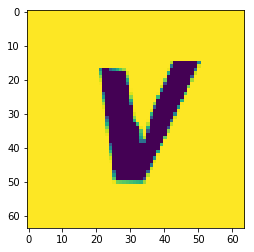

9.596630115993321e-05 2.831866977004438e-05 0.0004340226451442497
Epoch 133: 1.5855066776275635 -0.9377292990684509 2.60770320892334e-08 0.018533535301685333 0.09156107902526855 0.023949652910232544,-1.5340840816497803


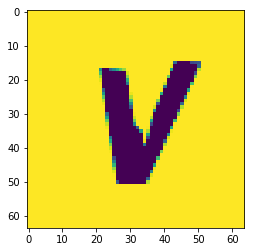

0.00016166198474820703 2.9187924039793717e-05 0.00043123021538971074
Epoch 134: 1.5660176277160645 1.4575895071029663 5.21540641784668e-08 0.01760246604681015 0.09144552797079086 0.02394954115152359,-1.532682180404663


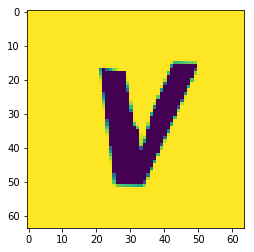

0.0004750267544295639 2.997478260861423e-05 0.0004140511371348854
Epoch 135: 1.4818127155303955 0.33927103877067566 7.82310962677002e-08 0.018392160534858704 0.09128882735967636 0.023949546739459038,-1.5312979221343994


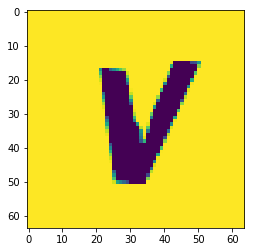

9.655642497818917e-05 3.079964339628797e-05 0.00042259047442494424
Epoch 136: 1.5112979412078857 1.5389889478683472 -3.725290298461914e-08 0.018788475543260574 0.09145637601613998 0.023949414491653442,-1.5296697616577148


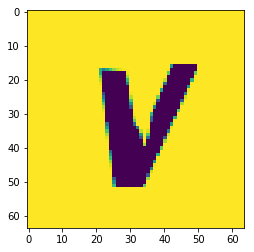

0.00023800699273124337 3.313145758928234e-05 0.00042525986239161373
Epoch 137: 1.5288134813308716 -1.0083504915237427 2.9802322387695312e-08 0.018946826457977295 0.09168680012226105 0.023949023336172104,-1.5279964208602905


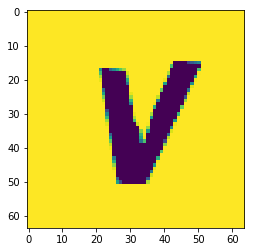

0.00023999839322641492 3.350145714501688e-05 0.00042352229579515715
Epoch 138: 1.4953211545944214 1.3112599849700928 -5.960464477539063e-08 0.019683513790369034 0.09141175448894501 0.023949231952428818,-1.5260837078094482


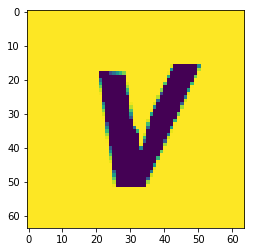

0.0003769095055758953 3.513616228545402e-05 0.00041926722485045403
Epoch 139: 1.48134183883667 -1.4487428665161133 3.725290298461914e-08 0.018480118364095688 0.09146495163440704 0.023949099704623222,-1.52447509765625


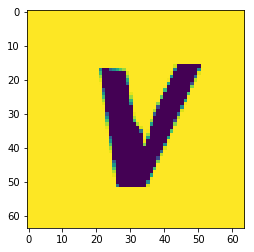

4.779649316333234e-05 3.664011847230123e-05 0.000425107559589281
Epoch 140: 1.4919203519821167 -0.7775877714157104 -2.9802322387695312e-08 0.018560899421572685 0.09168575704097748 0.023948807269334793,-1.5223510265350342


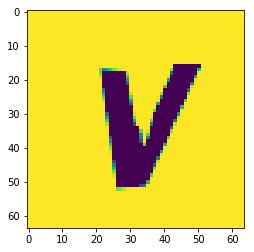

0.00031769732595421374 3.967997483063831e-05 0.00043267624020811485
Epoch 141: 1.539678692817688 0.3573960065841675 4.842877388000488e-08 0.0201251320540905 0.09165513515472412 0.023948444053530693,-1.5199470520019531


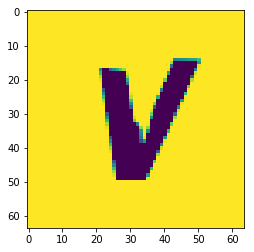

0.00013228622265160084 3.9307532258447964e-05 0.0004281588850544675
Epoch 142: 1.4961731433868408 1.7655978202819824 0.0 0.019426386803388596 0.09130601584911346 0.023948434740304947,-1.51796293258667


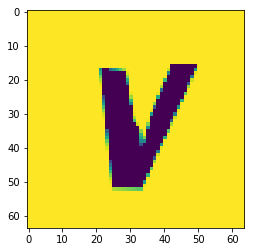

0.00037311954656615853 4.255379386582566e-05 0.0004324573692134903
Epoch 143: 1.5175423622131348 1.136125087738037 2.2351741790771484e-08 0.01942400261759758 0.09145325422286987 0.023948263376951218,-1.5155963897705078


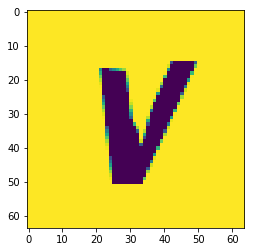

0.00013108723214827478 4.318830734935849e-05 0.000424356565540777
Epoch 144: 1.456153154373169 0.27836450934410095 5.21540641784668e-08 0.018500788137316704 0.09143476188182831 0.023947929963469505,-1.5127859115600586


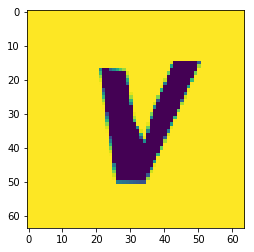

0.0005175578990019858 4.710061684913095e-05 0.00043181199364876005
Epoch 145: 1.5014859437942505 1.255084753036499 -7.450580596923828e-09 0.019759170711040497 0.0914103239774704 0.02394779585301876,-1.5100873708724976


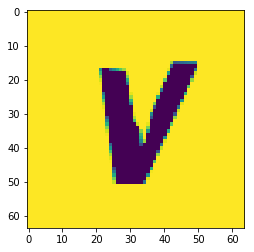

4.458136027096771e-05 4.837316488703891e-05 0.000432994728751616
Epoch 146: 1.4937450885772705 0.6520676612854004 2.2351741790771484e-08 0.01772383041679859 0.09141066670417786 0.023947391659021378,-1.5069739818572998


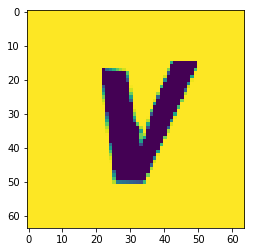

0.0003710987512022257 5.2545775472386445e-05 0.00043781554838458653
Epoch 147: 1.5004030466079712 1.5671753883361816 1.4901161193847656e-08 0.01754140853881836 0.09174785017967224 0.023947523906826973,-1.5034725666046143


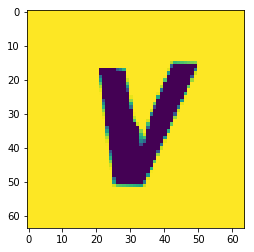

0.00015563108900096267 5.3865278019316065e-05 0.0004383890648413935
Epoch 148: 1.5089147090911865 2.0919079780578613 -1.4901161193847656e-08 0.01787024736404419 0.09111493080854416 0.02394700050354004,-1.499754786491394


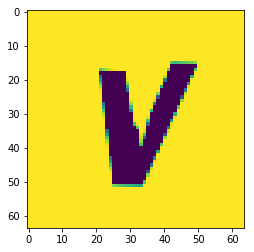

0.00028619763907045126 5.7221643992022564e-05 0.0004326762480362234
Epoch 149: 1.4724477529525757 -0.13738249242305756 8.195638656616211e-08 0.018723178654909134 0.09138604253530502 0.023946866393089294,-1.495536208152771


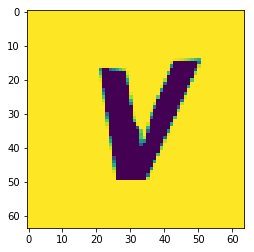

In [53]:
agent = Agent(len(data.vocab),learnAE.model.encoder.state_dict(),learnSVG.model.token_emb.state_dict()).cuda()
opt_agent = torch.optim.Adam(agent.parameters(),lr=1e-4,weight_decay=0.01)
action_mask = [torch.ByteTensor([1]*len(tool_dict[data.vocab[i]]) + [0]*(4-len(tool_dict[data.vocab[i]]))) for i in range(len(data.vocab))]
action_mask = torch.stack(action_mask).cuda()

with torch.autograd.detect_anomaly():
    for epoch in range(150):
        state, state_tools, state_pens = start_state, start_state_tools, start_state_pens
        action_log_probs, pen_log_probs, rewards, actions, mses, entropy_a, entropy_p = [], [], [], [], [], [], []
        baseline = F.mse_loss(start_state,targets,reduction="none").view(start_state.shape[0],-1).mean(dim=1)
        seq_mask = torch.ones(state_tools.shape[0],state_tools.shape[1]).byte().cuda()
        for t in range(3):
            npens, delta, action_probs, pen_probs, action, action_entropy, pen_entropy, mu = agent(state,targets,state_tools,state_pens,seq_mask=seq_mask)
            seq_mask[torch.arange(seq_mask.shape[0]),action] = 0
            #print(state_pens-npens)
            state_pens = npens
            #print(tensors_to_path_string(state_tools[:,1:],state_pens[:,1:]))
            #state = nparallel(render_paths(tensors_to_path_string(state_tools[:,1:],state_pens[:,1:]))
            state = torch.stack(nparallel(render_path,tensors_to_path_string(state_tools[:,1:],state_pens[:,1:]))).unsqueeze(1).cuda()
            mse = F.mse_loss(state,targets,reduction="none").view(state.shape[0],-1).mean(dim=1)
            reward = baseline - mse
            baseline = mse
            action_log_probs.append(action_probs)
            pen_log_probs.append(pen_probs)
            rewards.append(reward)
            actions.append(action.detach())
            mses.append(mse)
            entropy_a.append(action_entropy)
            entropy_p.append(pen_entropy)

        action_log_probs = torch.stack(action_log_probs,dim=1)
        pen_log_probs = torch.stack(pen_log_probs,dim=1)
        rewards = torch.stack(rewards,dim=1)
        rewards = (rewards - rewards.mean()) / rewards.std()
        actions = torch.stack(actions,dim=1)
        mses = torch.stack(mses,dim=1)
        entropy_a = torch.stack(entropy_a,dim=1)
        entropy_p = torch.stack(entropy_p,dim=1)
        tool = torch.gather(state_tools,1,actions)
        #print(rewards.shape)
        ##print(rewards)
        #rewards = (rewards - torch.mean(rewards)) / torch.std(rewards)
        #print(action_log_probs.shape,pen_log_probs.shape,rewards.shape)
        #loss = (rewards * action_log_probs).mean() + 100*(rewards.unsqueeze(-1) * pen_log_probs)[action_mask[tool]].mean()
        #loss = -100*(rewards.unsqueeze(-1) * pen_log_probs)[action_mask[tool]].mean()
        loss = (rewards.unsqueeze(-1) * pen_log_probs)
        loss[~action_mask[tool]] = 0.0
        loss = loss.mean()
        loss = loss + (rewards * -action_log_probs).mean() - 0.01*entropy_a.mean() - entropy_p.mean()
        opt_agent.zero_grad()
        loss.backward()
        rnn_grads,mdn_grads = [],[]
        for p in agent.path_encoder.parameters():
            if p.grad is not None: rnn_grads.append(p.grad.abs().mean().item())
        for p in agent.adjust.parameters():
            if p.grad is not None: mdn_grads.append(p.grad.abs().mean().item())
        print(agent.tool_sel.weight.grad.abs().mean().item() if agent.tool_sel.weight.grad is not None else "",np.mean(rnn_grads),np.mean(mdn_grads))
        opt_agent.step()

        if epoch % 1 == 0:
            print(f"Epoch {epoch}: {loss.item()} {rewards[0].sum().item()} {rewards.sum(dim=1).mean().item()} {mses[:,-1].mean().item()} {action_log_probs.exp().mean().item()} {0.01*entropy_a.mean()},{entropy_p.mean()}")
            plt.imshow(state[0,0])
            plt.show()